# 多模态融合方法对比实验

本 notebook 实现多模态情感识别的融合方法对比实验：

**模态分支：**
- **视觉分支 (CLIP)**: CNN + LSTM + GlobalMaxPooling → 128维
- **文本分支 (BERT)**: Attention + BiLSTM + GlobalMaxPooling → 128维

**融合方法对比：**
1. **Concat** - 拼接融合 (基准方法)
2. **LMF** - Low-rank Multimodal Fusion (ACL 2018)
3. **Gated** - 门控融合
4. **TFN** - Tensor Fusion Network (EMNLP 2017)
5. **MulT** - Multimodal Transformer (ACL 2019)

**正则化配置：**
- 视觉分支: L2(0.001) + Dropout(0.3)
- 文本分支: L2(0.01) + Dropout(0.2/0.3/0.4)
- 分类头: L2(0.001) + Dropout(0.5/0.3)
- 类别权重: 已启用 (处理类别不平衡)

## 1. 环境配置与库导入

In [1]:
# ===== GPU 配置 =====
import os

# 设置 cuDNN 库路径 (TensorFlow 2.15 需要)
cudnn_path = os.path.expanduser('~/.conda/envs/textcnn_bert/lib/python3.9/site-packages/nvidia/cudnn/lib')
if os.path.exists(cudnn_path):
    current_ld = os.environ.get('LD_LIBRARY_PATH', '')
    if cudnn_path not in current_ld:
        os.environ['LD_LIBRARY_PATH'] = cudnn_path + ':' + current_ld

import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import Model, backend as K
from keras.layers import (Input, Dense, Conv1D, LSTM, Bidirectional,
                          Concatenate, Add, Multiply, Attention,
                          GlobalMaxPooling1D, Dropout, BatchNormalization,
                          Lambda, Layer)
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from utilz import load_features

print("库导入成功！")
print(f"TensorFlow 版本: {tf.__version__}")

# 检查 GPU
gpus = tf.config.list_physical_devices('GPU')
print(f"可用 GPU 数量: {len(gpus)}")
for gpu in gpus:
    print(f"  - {gpu.name}")

# 限制 GPU 内存增长
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2025-12-26 23:49:26.916938: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-26 23:49:26.972460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-26 23:49:26.972513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-26 23:49:26.973944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-26 23:49:26.984052: I tensorflow/core/platform/cpu_feature_guar

2025-12-26 23:49:27.818602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


库导入成功！
TensorFlow 版本: 2.15.0
可用 GPU 数量: 4
  - /physical_device:GPU:0
  - /physical_device:GPU:1
  - /physical_device:GPU:2
  - /physical_device:GPU:3


## 2. 数据加载

In [2]:
# ========== 加载多模态数据 ==========
print("正在加载数据...")

# 视觉特征 (CLIP)
visual_clip = load_features('./data2025/fold2_visual_clip.pkl')

# 文本特征 (BERT)
bert_embs = load_features('./data2025/fold2_textual_bert.pkl')

# 标签
label = load_features('./data2025/fold2_labels.pkl')

print("\n数据加载完成！")

# ========== 数据形状检查 ==========
print("="*60)
print("数据形状汇总")
print("="*60)
print(f"视觉特征 (CLIP): Train {np.shape(visual_clip['train'])}, Test {np.shape(visual_clip['test'])}")
print(f"文本特征 (BERT): Train {np.shape(bert_embs['train'])}, Test {np.shape(bert_embs['test'])}")
print(f"训练集: {len(label['train'])} 样本")
print(f"测试集: {len(label['test'])} 样本")
print("="*60)

正在加载数据...



数据加载完成！
数据形状汇总
视觉特征 (CLIP): Train (343, 16, 512), Test (179, 16, 512)
文本特征 (BERT): Train (343, 82, 768), Test (179, 82, 768)
训练集: 343 样本
测试集: 179 样本


In [3]:
# ========== 计算类别权重 (处理类别不平衡) ==========
class_labels = ['Bored', 'Happy', 'Interested', 'Tired', 'Confused']
train_labels = np.array(label['train'])
test_labels = np.array(label['test'])

# 计算平衡权重
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))

print("="*60)
print("类别权重 (用于处理类别不平衡)")
print("="*60)
for cls, weight in class_weight_dict.items():
    print(f"  {class_labels[cls]:<12}: {weight:.4f}")
print("="*60)
print("\n说明: 权重 > 1 表示该类别样本较少，训练时会加大关注")

类别权重 (用于处理类别不平衡)
  Bored       : 0.7376
  Happy       : 1.1627
  Interested  : 1.1627
  Tired       : 0.9397
  Confused    : 1.1627

说明: 权重 > 1 表示该类别样本较少，训练时会加大关注


## 3. 模型分支定义

### 正则化配置说明：
- **视觉分支**: L2(0.001) + Dropout(0.3)
- **文本分支**: L2(0.01) + Dropout(0.2→0.3→0.4)

In [4]:
# ==================== 视觉分支 (CLIP): CNN + LSTM + GlobalMaxPooling ====================
def build_visual_branch(input_shape=(16, 512)):
    """
    视觉分支: Conv1D + LSTM + GlobalMaxPooling
    
    输入: CLIP特征 (16帧, 512维)
    输出: 128维特征向量
    
    正则化:
        - L2正则: 0.001
        - Dropout: 0.3
    """
    vis_ipt = Input(input_shape, name='visual_input')
    
    # ===== CNN层 (L2正则化) =====
    h = Conv1D(128, 3, 1, 'same', kernel_regularizer=l2(0.001))(vis_ipt)
    
    h = Conv1D(128, 1, 1, 'same', kernel_regularizer=l2(0.001))(h)
    h = BatchNormalization()(h)
    h = tf.keras.layers.ReLU()(h)
    
    h = Conv1D(64, 3, 2, 'same', kernel_regularizer=l2(0.001))(h)  # stride=2 降采样
    h = BatchNormalization()(h)
    h = tf.keras.layers.ReLU()(h)
    
    # ===== LSTM层 (L2正则化 + Dropout) =====
    h = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))(h)
    h = Dropout(0.3)(h)  # Dropout正则化
    
    # ===== 池化 =====
    vis_out = GlobalMaxPooling1D()(h)
    
    return vis_ipt, vis_out  # 输出形状: (batch, 128)


# ==================== 文本分支 (BERT): Attention + BiLSTM + GlobalMaxPooling ====================
def build_text_branch(input_shape=(82, 768)):
    """
    文本分支: Attention + BiLSTM + GlobalMaxPooling
    
    输入: BERT特征 (82 tokens, 768维)
    输出: 128维特征向量
    
    正则化:
        - L2正则: 0.01 (更强)
        - Dropout: 0.2 → 0.3 → 0.4
    """
    tex_ipt = Input(input_shape, name='text_input')
    
    # ===== 输入Dropout =====
    h = Dropout(0.2)(tex_ipt)
    
    # ===== Self-Attention =====
    h = Attention()([h, h])
    h = Dropout(0.3)(h)  # Attention后Dropout
    
    # ===== BiLSTM (L2正则化) =====
    h = Bidirectional(LSTM(64, return_sequences=True, return_state=False,
                           kernel_regularizer=l2(0.01),      # L2正则化
                           recurrent_regularizer=l2(0.01)))(h)  # 循环层也加L2
    
    # ===== 池化 + Dropout =====
    tex_out = GlobalMaxPooling1D()(h)
    tex_out = Dropout(0.4)(tex_out)  # 输出Dropout
    
    return tex_ipt, tex_out  # 输出形状: (batch, 128)


print("分支定义完成！")
print("\n【正则化配置】")
print("视觉分支: L2(0.001) + Dropout(0.3)")
print("文本分支: L2(0.01) + Dropout(0.2→0.3→0.4)")
print("\n【输出维度】")
print("视觉分支: 128维")
print("文本分支: 128维")

分支定义完成！

【正则化配置】
视觉分支: L2(0.001) + Dropout(0.3)
文本分支: L2(0.01) + Dropout(0.2→0.3→0.4)

【输出维度】
视觉分支: 128维
文本分支: 128维


## 4. 融合方法定义

In [5]:
# ==================== 融合方法 1: Concatenation ====================
def fusion_concat(vis_feat, tex_feat):
    """
    拼接融合 (基准方法)
    输出维度: 128 + 128 = 256
    """
    return Concatenate(name='fusion_concat')([vis_feat, tex_feat])


# ==================== 融合方法 2: Low-rank Multimodal Fusion (LMF) ====================
def fusion_lmf(vis_feat, tex_feat, rank=4, output_dim=128):
    """
    Low-rank Multimodal Fusion (ACL 2018)
    TFN的低秩分解版本，大幅减少参数量
    
    公式: f = sum_r(W_v^r * v) ⊙ (W_t^r * t) * W_o^r
    输出维度: output_dim (128)
    
    正则化: L2(0.001)
    """
    # 添加常数1，形成 [v; 1] 和 [t; 1]
    vis_with_1 = Lambda(lambda x: tf.concat([x, tf.ones((tf.shape(x)[0], 1))], axis=1),
                        name='lmf_vis_append')(vis_feat)  # (batch, 129)
    tex_with_1 = Lambda(lambda x: tf.concat([x, tf.ones((tf.shape(x)[0], 1))], axis=1),
                        name='lmf_tex_append')(tex_feat)  # (batch, 129)
    
    # 低秩因子投影 (L2正则化)
    vis_factor = Dense(rank, use_bias=False, kernel_regularizer=l2(0.001),
                       name='lmf_vis_factor')(vis_with_1)  # (batch, rank)
    tex_factor = Dense(rank, use_bias=False, kernel_regularizer=l2(0.001),
                       name='lmf_tex_factor')(tex_with_1)  # (batch, rank)
    
    # 元素级乘法融合
    fusion_factor = Multiply(name='lmf_multiply')([vis_factor, tex_factor])  # (batch, rank)
    
    # 投影到输出维度 (L2正则化)
    fused = Dense(output_dim, activation='relu', kernel_regularizer=l2(0.001),
                  name='fusion_lmf')(fusion_factor)
    
    return fused


# ==================== 融合方法 3: Gated Fusion ====================
def fusion_gated(vis_feat, tex_feat):
    """
    门控融合 - 自适应学习模态权重
    
    公式: f = g ⊙ v + (1-g) ⊙ t, where g = sigmoid(W[v;t])
    输出维度: 128
    
    正则化: L2(0.001)
    """
    # 拼接计算门控权重 (L2正则化)
    concat_feat = Concatenate()([vis_feat, tex_feat])  # (batch, 256)
    gate = Dense(128, activation='sigmoid', kernel_regularizer=l2(0.001),
                 name='gated_gate')(concat_feat)  # (batch, 128)
    
    # 门控融合: g * vis + (1-g) * tex
    gated_vis = Multiply(name='gated_vis')([gate, vis_feat])
    inv_gate = Lambda(lambda x: 1.0 - x, name='gated_inv')(gate)
    gated_tex = Multiply(name='gated_tex')([inv_gate, tex_feat])
    
    fused = Add(name='fusion_gated')([gated_vis, gated_tex])
    return fused


# ==================== 融合方法 4: Tensor Fusion Network (TFN) ====================
from keras.layers import Flatten, Reshape

def fusion_tfn(vis_feat, tex_feat, output_dim=128):
    """
    Tensor Fusion Network (EMNLP 2017)
    计算模态间的外积张量，捕捉所有模态交互
    
    公式: z = [v; 1] ⊗ [t; 1] (外积)
    输出维度: output_dim (128)
    
    正则化: L2(0.001)
    """
    # 添加常数1 (使用固定形状)
    vis_with_1 = Lambda(lambda x: tf.concat([x, tf.ones_like(x[:, :1])], axis=1),
                        name='tfn_vis_append')(vis_feat)  # (batch, 129)
    tex_with_1 = Lambda(lambda x: tf.concat([x, tf.ones_like(x[:, :1])], axis=1),
                        name='tfn_tex_append')(tex_feat)  # (batch, 129)
    
    # 计算外积: (batch, 129, 1) * (batch, 1, 129) = (batch, 129, 129)
    vis_expanded = Lambda(lambda x: tf.expand_dims(x, axis=2),
                          name='tfn_vis_expand')(vis_with_1)
    tex_expanded = Lambda(lambda x: tf.expand_dims(x, axis=1),
                          name='tfn_tex_expand')(tex_with_1)
    tensor_product = Lambda(lambda x: x[0] * x[1],
                            name='tfn_outer_product')([vis_expanded, tex_expanded])
    
    # 展平: 使用 Flatten 层保留静态形状信息
    flattened = Flatten(name='tfn_flatten')(tensor_product)  # (batch, 16641)
    
    # 投影到输出维度 (L2正则化)
    fused = Dense(output_dim, activation='relu', kernel_regularizer=l2(0.001),
                  name='fusion_tfn')(flattened)
    
    return fused


# ==================== 融合方法 5: Multimodal Transformer (MulT) ====================
class MultiheadCrossAttention(Layer):
    """多头跨模态注意力层 (带L2正则化)"""
    def __init__(self, d_model=128, num_heads=4, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        
    def build(self, input_shape):
        # 所有Dense层都加L2正则化
        self.wq = Dense(self.d_model, kernel_regularizer=l2(0.001))
        self.wk = Dense(self.d_model, kernel_regularizer=l2(0.001))
        self.wv = Dense(self.d_model, kernel_regularizer=l2(0.001))
        self.dense = Dense(self.d_model, kernel_regularizer=l2(0.001))
        super().build(input_shape)
        
    def call(self, query, key_value):
        batch_size = tf.shape(query)[0]
        
        q = self.wq(query)
        k = self.wk(key_value)
        v = self.wv(key_value)
        
        # 分割多头
        q = tf.reshape(q, (batch_size, -1, self.num_heads, self.depth))
        q = tf.transpose(q, perm=[0, 2, 1, 3])
        k = tf.reshape(k, (batch_size, -1, self.num_heads, self.depth))
        k = tf.transpose(k, perm=[0, 2, 1, 3])
        v = tf.reshape(v, (batch_size, -1, self.num_heads, self.depth))
        v = tf.transpose(v, perm=[0, 2, 1, 3])
        
        # 注意力计算
        scores = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        attn_weights = tf.nn.softmax(scores, axis=-1)
        context = tf.matmul(attn_weights, v)
        
        # 合并多头
        context = tf.transpose(context, perm=[0, 2, 1, 3])
        context = tf.reshape(context, (batch_size, -1, self.d_model))
        
        output = self.dense(context)
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({'d_model': self.d_model, 'num_heads': self.num_heads})
        return config


def fusion_multimodal_transformer(vis_feat, tex_feat, d_model=128, num_heads=4):
    """
    Multimodal Transformer (ACL 2019) 简化版
    使用跨模态Transformer进行双向注意力融合
    
    输出维度: d_model * 2 = 256
    
    正则化: L2(0.001) 在MultiheadCrossAttention中
    """
    # 扩展为序列格式 (batch, 1, dim)
    vis_seq = Lambda(lambda x: tf.expand_dims(x, 1), name='mult_vis_expand')(vis_feat)
    tex_seq = Lambda(lambda x: tf.expand_dims(x, 1), name='mult_tex_expand')(tex_feat)
    
    # 跨模态Transformer: 双向注意力 (带L2正则化)
    cross_attn_v2t = MultiheadCrossAttention(d_model, num_heads, name='mult_v2t')
    cross_attn_t2v = MultiheadCrossAttention(d_model, num_heads, name='mult_t2v')
    
    vis_transformed = cross_attn_v2t(vis_seq, tex_seq)  # 视觉查询文本
    tex_transformed = cross_attn_t2v(tex_seq, vis_seq)  # 文本查询视觉
    
    # 压缩并拼接
    vis_out = Lambda(lambda x: tf.squeeze(x, 1), name='mult_vis_squeeze')(vis_transformed)
    tex_out = Lambda(lambda x: tf.squeeze(x, 1), name='mult_tex_squeeze')(tex_transformed)
    
    fused = Concatenate(name='fusion_mult')([vis_out, tex_out])
    return fused


print("融合方法定义完成！")
print("\n【融合方法汇总】")
print("1. Concat: 拼接融合 → 256维")
print("2. LMF: 低秩多模态融合 → 128维 (L2正则化)")
print("3. Gated: 门控融合 → 128维 (L2正则化)")
print("4. TFN: 张量融合网络 → 128维 (L2正则化)")
print("5. MulT: 多模态Transformer → 256维 (L2正则化)")

融合方法定义完成！

【融合方法汇总】
1. Concat: 拼接融合 → 256维
2. LMF: 低秩多模态融合 → 128维 (L2正则化)
3. Gated: 门控融合 → 128维 (L2正则化)
4. TFN: 张量融合网络 → 128维 (L2正则化)
5. MulT: 多模态Transformer → 256维 (L2正则化)


## 5. 构建完整模型

In [6]:
def build_multimodal_model(fusion_method='concat', num_classes=5):
    """
    构建多模态融合模型
    
    Args:
        fusion_method: 融合方法 ['concat', 'lmf', 'gated', 'tfn', 'mult']
        num_classes: 分类数量
    
    Returns:
        model: 编译好的Keras模型
    
    正则化配置:
        - 分类头: L2(0.001) + Dropout(0.5, 0.3)
        - 学习率: 0.0001
    """
    # 清理内存
    K.clear_session()
    gc.collect()
    
    # 构建两个分支
    vis_ipt, vis_feat = build_visual_branch()
    tex_ipt, tex_feat = build_text_branch()
    
    # 选择融合方法
    fusion_methods = {
        'concat': fusion_concat,
        'lmf': fusion_lmf,
        'gated': fusion_gated,
        'tfn': fusion_tfn,
        'mult': fusion_multimodal_transformer
    }
    
    fused = fusion_methods[fusion_method](vis_feat, tex_feat)
    
    # ===== 分类头 (L2正则化 + Dropout) =====
    h = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(fused)
    h = Dropout(0.5)(h)  # Dropout正则化
    h = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(h)
    h = Dropout(0.3)(h)  # Dropout正则化
    output = Dense(num_classes, activation='softmax', name='output')(h)
    
    model = Model(inputs=[vis_ipt, tex_ipt], outputs=output)
    
    # ===== 编译模型 =====
    optimizer = Adam(learning_rate=0.0001)  # 较低学习率
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['acc']
    )
    
    return model


print("模型构建函数定义完成！")
print("\n【分类头正则化】")
print("  - Dense(128): L2(0.001)")
print("  - Dropout: 0.5")
print("  - Dense(64): L2(0.001)")
print("  - Dropout: 0.3")
print("  - 学习率: 0.0001")

模型构建函数定义完成！

【分类头正则化】
  - Dense(128): L2(0.001)
  - Dropout: 0.5
  - Dense(64): L2(0.001)
  - Dropout: 0.3
  - 学习率: 0.0001


## 6. 训练和评估函数

In [7]:
def train_and_evaluate(fusion_method, save_dir='./data2025/resm/fusion_comparison'):
    """
    训练和评估指定融合方法的模型
    
    Args:
        fusion_method: 融合方法名称
        save_dir: 模型保存目录
    
    Returns:
        results: 包含训练结果的字典
    
    注意: 使用类别权重 class_weight_dict 处理类别不平衡
    """
    print(f"\n{'='*60}")
    print(f"训练融合方法: {fusion_method.upper()}")
    print(f"{'='*60}")
    
    # 创建保存目录
    os.makedirs(save_dir, exist_ok=True)
    
    # 构建模型
    model = build_multimodal_model(fusion_method=fusion_method)
    
    # 打印模型摘要
    print(f"\n模型参数量: {model.count_params():,}")
    
    # 准备数据
    X_train_vis = np.asarray(visual_clip['train'])
    X_train_tex = np.asarray(bert_embs['train'])
    y_train = np.asarray(label['train'])
    
    X_test_vis = np.asarray(visual_clip['test'])
    X_test_tex = np.asarray(bert_embs['test'])
    y_test = np.asarray(label['test'])
    
    # 回调函数
    model_path = f'{save_dir}/model_{fusion_method}.tf'
    callbacks = [
        ModelCheckpoint(
            filepath=model_path,
            monitor='val_acc',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_acc',
            patience=15,
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_acc',
            factor=0.5,
            patience=7,
            min_lr=1e-7,
            mode='max',
            verbose=1
        )
    ]
    
    # ===== 训练 (使用类别权重) =====
    print(f"\n使用类别权重: {class_weight_dict}")
    history = model.fit(
        x=[X_train_vis, X_train_tex],
        y=y_train,
        batch_size=16,
        epochs=50,
        validation_data=([X_test_vis, X_test_tex], y_test),
        callbacks=callbacks,
        class_weight=class_weight_dict,  # 类别权重
        verbose=1
    )
    
    # 获取最佳结果
    acc_key = 'acc' if 'acc' in history.history else 'accuracy'
    val_acc_key = 'val_acc' if 'val_acc' in history.history else 'val_accuracy'
    
    best_train_acc = max(history.history[acc_key])
    best_val_acc = max(history.history[val_acc_key])
    best_epoch = history.history[val_acc_key].index(best_val_acc) + 1
    
    # 加载最佳模型进行测试
    model = keras.models.load_model(model_path, custom_objects={
        'MultiheadCrossAttention': MultiheadCrossAttention
    })
    
    # 预测
    pred = model.predict([X_test_vis, X_test_tex])
    predicted_labels = pred.argmax(axis=1)
    
    # 计算指标
    test_acc = np.mean(predicted_labels == y_test)
    
    # 分类报告
    report = classification_report(
        y_test, predicted_labels,
        target_names=class_labels,
        digits=4,
        output_dict=True,
        zero_division=0
    )
    
    # 打印分类报告
    print("\n分类报告:")
    print(classification_report(
        y_test, predicted_labels,
        target_names=class_labels,
        digits=4,
        zero_division=0
    ))
    
    # 混淆矩阵
    cm = confusion_matrix(y_test, predicted_labels)
    
    # 打印结果
    print(f"\n{'='*60}")
    print(f"[{fusion_method.upper()}] 训练结果")
    print(f"{'='*60}")
    print(f"最佳训练准确度: {best_train_acc:.4f}")
    print(f"最佳验证准确度: {best_val_acc:.4f}")
    print(f"测试准确度: {test_acc:.4f}")
    print(f"F1 (Macro): {report['macro avg']['f1-score']:.4f}")
    print(f"F1 (Weighted): {report['weighted avg']['f1-score']:.4f}")
    print(f"最佳Epoch: {best_epoch}")
    print(f"模型参数量: {model.count_params():,}")
    print(f"{'='*60}")
    
    # 返回结果
    results = {
        'method': fusion_method,
        'train_acc': best_train_acc,
        'val_acc': best_val_acc,
        'test_acc': test_acc,
        'best_epoch': best_epoch,
        'params': model.count_params(),
        'history': history.history,
        'confusion_matrix': cm,
        'classification_report': report,
        'f1_macro': report['macro avg']['f1-score'],
        'f1_weighted': report['weighted avg']['f1-score']
    }
    
    # 清理内存
    del model
    K.clear_session()
    gc.collect()
    
    return results


print("训练评估函数定义完成！")
print("\n【训练配置】")
print("  - Batch Size: 16")
print("  - Epochs: 50")
print("  - 类别权重: 已启用")
print("  - EarlyStopping: patience=15")
print("  - ReduceLROnPlateau: factor=0.5, patience=7")

训练评估函数定义完成！

【训练配置】
  - Batch Size: 16
  - Epochs: 50
  - 类别权重: 已启用
  - EarlyStopping: patience=15
  - ReduceLROnPlateau: factor=0.5, patience=7


## 7. 运行对比实验

In [8]:
# ========== 运行所有融合方法对比实验 ==========
fusion_methods = ['concat', 'lmf', 'gated', 'tfn', 'mult']
all_results = {}

print("="*70)
print("多模态融合方法对比实验")
print("="*70)
print(f"\n【实验配置】")
print(f"  视觉分支: CLIP (16, 512) → CNN + LSTM → 128维")
print(f"  文本分支: BERT (82, 768) → Attention + BiLSTM → 128维")
print(f"  融合方法: {fusion_methods}")
print(f"\n【正则化配置】")
print(f"  视觉分支: L2(0.001) + Dropout(0.3)")
print(f"  文本分支: L2(0.01) + Dropout(0.2→0.3→0.4)")
print(f"  分类头: L2(0.001) + Dropout(0.5, 0.3)")
print(f"  类别权重: 已启用")
print("="*70)

for method in fusion_methods:
    results = train_and_evaluate(method)
    all_results[method] = results
    
print("\n" + "="*70)
print("所有实验完成！")
print("="*70)

多模态融合方法对比实验

【实验配置】
  视觉分支: CLIP (16, 512) → CNN + LSTM → 128维
  文本分支: BERT (82, 768) → Attention + BiLSTM → 128维
  融合方法: ['concat', 'lmf', 'gated', 'tfn', 'mult']

【正则化配置】
  视觉分支: L2(0.001) + Dropout(0.3)
  文本分支: L2(0.01) + Dropout(0.2→0.3→0.4)
  分类头: L2(0.001) + Dropout(0.5, 0.3)
  类别权重: 已启用

训练融合方法: CONCAT


2025-12-26 23:49:30.588848: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46872 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:31:00.0, compute capability: 8.6
2025-12-26 23:49:30.590434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46872 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:4b:00.0, compute capability: 8.6
2025-12-26 23:49:30.591386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46872 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:b1:00.0, compute capability: 8.6
2025-12-26 23:49:30.592373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46872 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:ca:00.0, 

2025-12-26 23:49:30.944339: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory



模型参数量: 805,445

使用类别权重: {0: 0.7376344086021506, 1: 1.1627118644067798, 2: 1.1627118644067798, 3: 0.9397260273972603, 4: 1.1627118644067798}


Epoch 1/50


2025-12-26 23:49:36.147668: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-12-26 23:49:36.249743: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2025-12-26 23:49:37.332462: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0c5c2bba00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-26 23:49:37.332524: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-12-26 23:49:37.332538: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2025-12-26 23:49:37.332548: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA RTX A6000, Compute Capability 8.6
2025-12-26 23:49:37.332561: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA RTX A6000, Compute Capability 8.6
2025-12-26 23:49:37.342139: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1766764177.495426 29097

 1/22 [>.............................] - ETA: 2:33 - loss: 11.4875 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 11.4727 - acc: 0.2500  

 6/22 [=======>......................] - ETA: 0s - loss: 11.4120 - acc: 0.2708

 8/22 [=========>....................] - ETA: 0s - loss: 11.4199 - acc: 0.2344

10/22 [============>.................] - ETA: 0s - loss: 11.3884 - acc: 0.2438

12/22 [===============>..............] - ETA: 0s - loss: 11.3869 - acc: 0.2188

14/22 [==================>...........] - ETA: 0s - loss: 11.3784 - acc: 0.2143

16/22 [====================>.........] - ETA: 0s - loss: 11.3711 - acc: 0.2109

18/22 [=======================>......] - ETA: 0s - loss: 11.3596 - acc: 0.2049

21/22 [===========================>..] - ETA: 0s - loss: 11.3327 - acc: 0.2054

22/22 [==============================] - ETA: 0s - loss: 11.3321 - acc: 0.2012


Epoch 1: val_acc improved from -inf to 0.15084, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 18s 493ms/step - loss: 11.3321 - acc: 0.2012 - val_loss: 11.0459 - val_acc: 0.1508 - lr: 1.0000e-04


Epoch 2/50


 1/22 [>.............................] - ETA: 0s - loss: 11.2554 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 11.1401 - acc: 0.2083

 6/22 [=======>......................] - ETA: 0s - loss: 11.1298 - acc: 0.1979

 9/22 [===========>..................] - ETA: 0s - loss: 11.1072 - acc: 0.2083

12/22 [===============>..............] - ETA: 0s - loss: 11.0914 - acc: 0.2031

14/22 [==================>...........] - ETA: 0s - loss: 11.0619 - acc: 0.2009

16/22 [====================>.........] - ETA: 0s - loss: 11.0541 - acc: 0.2070

18/22 [=======================>......] - ETA: 0s - loss: 11.0429 - acc: 0.1910

20/22 [==========================>...] - ETA: 0s - loss: 11.0252 - acc: 0.1844


Epoch 2: val_acc improved from 0.15084 to 0.16201, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 8s 390ms/step - loss: 11.0187 - acc: 0.1808 - val_loss: 10.7522 - val_acc: 0.1620 - lr: 1.0000e-04


Epoch 3/50


 1/22 [>.............................] - ETA: 0s - loss: 11.0529 - acc: 0.0625

 4/22 [====>.........................] - ETA: 0s - loss: 10.8756 - acc: 0.1875

 6/22 [=======>......................] - ETA: 0s - loss: 10.8950 - acc: 0.1875

 8/22 [=========>....................] - ETA: 0s - loss: 10.8984 - acc: 0.1797

10/22 [============>.................] - ETA: 0s - loss: 10.8559 - acc: 0.1875

12/22 [===============>..............] - ETA: 0s - loss: 10.8476 - acc: 0.1875

14/22 [==================>...........] - ETA: 0s - loss: 10.8286 - acc: 0.1875

17/22 [======================>.......] - ETA: 0s - loss: 10.7981 - acc: 0.1801

19/22 [========================>.....] - ETA: 0s - loss: 10.7815 - acc: 0.1908

21/22 [===========================>..] - ETA: 0s - loss: 10.7522 - acc: 0.1875


Epoch 3: val_acc improved from 0.16201 to 0.20670, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 8s 381ms/step - loss: 10.7427 - acc: 0.1953 - val_loss: 10.4762 - val_acc: 0.2067 - lr: 1.0000e-04


Epoch 4/50


 1/22 [>.............................] - ETA: 0s - loss: 10.5736 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 10.5281 - acc: 0.1875

 5/22 [=====>........................] - ETA: 0s - loss: 10.4944 - acc: 0.2125

 7/22 [========>.....................] - ETA: 0s - loss: 10.4586 - acc: 0.2321

 9/22 [===========>..................] - ETA: 0s - loss: 10.4766 - acc: 0.2153

11/22 [==============>...............] - ETA: 0s - loss: 10.4573 - acc: 0.2273

13/22 [================>.............] - ETA: 0s - loss: 10.4514 - acc: 0.2115

15/22 [===================>..........] - ETA: 0s - loss: 10.4478 - acc: 0.2208

17/22 [======================>.......] - ETA: 0s - loss: 10.4379 - acc: 0.2206

19/22 [========================>.....] - ETA: 0s - loss: 10.4176 - acc: 0.2270

21/22 [===========================>..] - ETA: 0s - loss: 10.4139 - acc: 0.2143


Epoch 4: val_acc improved from 0.20670 to 0.22905, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 9s 420ms/step - loss: 10.4122 - acc: 0.2099 - val_loss: 10.2050 - val_acc: 0.2291 - lr: 1.0000e-04


Epoch 5/50


 1/22 [>.............................] - ETA: 0s - loss: 10.3844 - acc: 0.0625

 3/22 [===>..........................] - ETA: 0s - loss: 10.2908 - acc: 0.1875

 5/22 [=====>........................] - ETA: 0s - loss: 10.2338 - acc: 0.2125

 8/22 [=========>....................] - ETA: 0s - loss: 10.2166 - acc: 0.1875

11/22 [==============>...............] - ETA: 0s - loss: 10.2011 - acc: 0.2102

13/22 [================>.............] - ETA: 0s - loss: 10.1804 - acc: 0.2356

15/22 [===================>..........] - ETA: 0s - loss: 10.1720 - acc: 0.2333

17/22 [======================>.......] - ETA: 0s - loss: 10.1683 - acc: 0.2279

19/22 [========================>.....] - ETA: 0s - loss: 10.1413 - acc: 0.2303

21/22 [===========================>..] - ETA: 0s - loss: 10.1201 - acc: 0.2292


Epoch 5: val_acc improved from 0.22905 to 0.24581, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 9s 426ms/step - loss: 10.1166 - acc: 0.2332 - val_loss: 9.9414 - val_acc: 0.2458 - lr: 1.0000e-04


Epoch 6/50


 1/22 [>.............................] - ETA: 0s - loss: 9.8458 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 9.9658 - acc: 0.1875

 5/22 [=====>........................] - ETA: 0s - loss: 9.9855 - acc: 0.1875

 7/22 [========>.....................] - ETA: 0s - loss: 9.9455 - acc: 0.2054

 9/22 [===========>..................] - ETA: 0s - loss: 9.9286 - acc: 0.2153

11/22 [==============>...............] - ETA: 0s - loss: 9.9034 - acc: 0.2159

13/22 [================>.............] - ETA: 0s - loss: 9.8872 - acc: 0.2212

15/22 [===================>..........] - ETA: 0s - loss: 9.8914 - acc: 0.2208

18/22 [=======================>......] - ETA: 0s - loss: 9.8842 - acc: 0.2188

20/22 [==========================>...] - ETA: 0s - loss: 9.8618 - acc: 0.2344

22/22 [==============================] - ETA: 0s - loss: 9.8455 - acc: 0.2362


Epoch 6: val_acc improved from 0.24581 to 0.27374, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 8s 396ms/step - loss: 9.8455 - acc: 0.2362 - val_loss: 9.6870 - val_acc: 0.2737 - lr: 1.0000e-04


Epoch 7/50


 1/22 [>.............................] - ETA: 0s - loss: 9.5724 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 9.6335 - acc: 0.1875

 6/22 [=======>......................] - ETA: 0s - loss: 9.6463 - acc: 0.2083

 9/22 [===========>..................] - ETA: 0s - loss: 9.6332 - acc: 0.2361

12/22 [===============>..............] - ETA: 0s - loss: 9.6280 - acc: 0.2083

15/22 [===================>..........] - ETA: 0s - loss: 9.6192 - acc: 0.2083

17/22 [======================>.......] - ETA: 0s - loss: 9.6006 - acc: 0.2169

19/22 [========================>.....] - ETA: 0s - loss: 9.5861 - acc: 0.2204

21/22 [===========================>..] - ETA: 0s - loss: 9.5735 - acc: 0.2232


Epoch 7: val_acc improved from 0.27374 to 0.29609, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 9s 433ms/step - loss: 9.5695 - acc: 0.2216 - val_loss: 9.4365 - val_acc: 0.2961 - lr: 1.0000e-04


Epoch 8/50


 1/22 [>.............................] - ETA: 0s - loss: 9.5189 - acc: 0.2500

 4/22 [====>.........................] - ETA: 0s - loss: 9.4376 - acc: 0.2656

 7/22 [========>.....................] - ETA: 0s - loss: 9.4060 - acc: 0.2232

10/22 [============>.................] - ETA: 0s - loss: 9.3944 - acc: 0.2313

13/22 [================>.............] - ETA: 0s - loss: 9.3822 - acc: 0.2596

16/22 [====================>.........] - ETA: 0s - loss: 9.3584 - acc: 0.2578

19/22 [========================>.....] - ETA: 0s - loss: 9.3482 - acc: 0.2632

22/22 [==============================] - ETA: 0s - loss: 9.3327 - acc: 0.2653


Epoch 8: val_acc improved from 0.29609 to 0.33520, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 8s 399ms/step - loss: 9.3327 - acc: 0.2653 - val_loss: 9.1934 - val_acc: 0.3352 - lr: 1.0000e-04


Epoch 9/50


 1/22 [>.............................] - ETA: 0s - loss: 9.3785 - acc: 0.0625

 4/22 [====>.........................] - ETA: 0s - loss: 9.1958 - acc: 0.2188

 7/22 [========>.....................] - ETA: 0s - loss: 9.1707 - acc: 0.2500

10/22 [============>.................] - ETA: 0s - loss: 9.1818 - acc: 0.2625

13/22 [================>.............] - ETA: 0s - loss: 9.1449 - acc: 0.2500

15/22 [===================>..........] - ETA: 0s - loss: 9.1449 - acc: 0.2500

17/22 [======================>.......] - ETA: 0s - loss: 9.1217 - acc: 0.2684

19/22 [========================>.....] - ETA: 0s - loss: 9.1064 - acc: 0.2664

22/22 [==============================] - ETA: 0s - loss: 9.0986 - acc: 0.2624


Epoch 9: val_acc improved from 0.33520 to 0.35754, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 8s 393ms/step - loss: 9.0986 - acc: 0.2624 - val_loss: 8.9555 - val_acc: 0.3575 - lr: 1.0000e-04


Epoch 10/50


 1/22 [>.............................] - ETA: 0s - loss: 8.7891 - acc: 0.4375

 4/22 [====>.........................] - ETA: 0s - loss: 8.9194 - acc: 0.3125

 7/22 [========>.....................] - ETA: 0s - loss: 8.9301 - acc: 0.2411

 9/22 [===========>..................] - ETA: 0s - loss: 8.9464 - acc: 0.2292

12/22 [===============>..............] - ETA: 0s - loss: 8.9260 - acc: 0.2396

15/22 [===================>..........] - ETA: 0s - loss: 8.8988 - acc: 0.2417

18/22 [=======================>......] - ETA: 0s - loss: 8.8834 - acc: 0.2326

20/22 [==========================>...] - ETA: 0s - loss: 8.8683 - acc: 0.2313

22/22 [==============================] - ETA: 0s - loss: 8.8589 - acc: 0.2362


Epoch 10: val_acc did not improve from 0.35754


22/22 [==============================] - 1s 32ms/step - loss: 8.8589 - acc: 0.2362 - val_loss: 8.7225 - val_acc: 0.3575 - lr: 1.0000e-04


Epoch 11/50


 1/22 [>.............................] - ETA: 0s - loss: 8.5935 - acc: 0.1875

 3/22 [===>..........................] - ETA: 0s - loss: 8.6175 - acc: 0.3125

 5/22 [=====>........................] - ETA: 0s - loss: 8.6214 - acc: 0.3125

 7/22 [========>.....................] - ETA: 0s - loss: 8.6184 - acc: 0.3214

 9/22 [===========>..................] - ETA: 0s - loss: 8.6256 - acc: 0.2847

11/22 [==============>...............] - ETA: 0s - loss: 8.6053 - acc: 0.2955

13/22 [================>.............] - ETA: 0s - loss: 8.6190 - acc: 0.2788

15/22 [===================>..........] - ETA: 0s - loss: 8.6214 - acc: 0.2792

17/22 [======================>.......] - ETA: 0s - loss: 8.6076 - acc: 0.2757

19/22 [========================>.....] - ETA: 0s - loss: 8.6219 - acc: 0.2730

21/22 [===========================>..] - ETA: 0s - loss: 8.6213 - acc: 0.2560


Epoch 11: val_acc improved from 0.35754 to 0.36313, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 9s 440ms/step - loss: 8.6180 - acc: 0.2536 - val_loss: 8.4937 - val_acc: 0.3631 - lr: 1.0000e-04


Epoch 12/50


 1/22 [>.............................] - ETA: 0s - loss: 8.3535 - acc: 0.5625

 4/22 [====>.........................] - ETA: 0s - loss: 8.5107 - acc: 0.3281

 7/22 [========>.....................] - ETA: 0s - loss: 8.4873 - acc: 0.3482

 9/22 [===========>..................] - ETA: 0s - loss: 8.4764 - acc: 0.3264

11/22 [==============>...............] - ETA: 0s - loss: 8.4414 - acc: 0.3068

13/22 [================>.............] - ETA: 0s - loss: 8.4370 - acc: 0.2933

15/22 [===================>..........] - ETA: 0s - loss: 8.4249 - acc: 0.2833

17/22 [======================>.......] - ETA: 0s - loss: 8.4121 - acc: 0.2757

19/22 [========================>.....] - ETA: 0s - loss: 8.4027 - acc: 0.2730

21/22 [===========================>..] - ETA: 0s - loss: 8.3872 - acc: 0.2708


Epoch 12: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 36ms/step - loss: 8.3810 - acc: 0.2711 - val_loss: 8.2719 - val_acc: 0.3520 - lr: 1.0000e-04


Epoch 13/50


 1/22 [>.............................] - ETA: 0s - loss: 8.3308 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 8.3366 - acc: 0.2708

 5/22 [=====>........................] - ETA: 0s - loss: 8.3484 - acc: 0.2750

 7/22 [========>.....................] - ETA: 0s - loss: 8.3110 - acc: 0.2857

 9/22 [===========>..................] - ETA: 0s - loss: 8.2674 - acc: 0.2917

11/22 [==============>...............] - ETA: 0s - loss: 8.2282 - acc: 0.3011

13/22 [================>.............] - ETA: 0s - loss: 8.2203 - acc: 0.3077

15/22 [===================>..........] - ETA: 0s - loss: 8.2135 - acc: 0.3208

17/22 [======================>.......] - ETA: 0s - loss: 8.2016 - acc: 0.3015

19/22 [========================>.....] - ETA: 0s - loss: 8.1815 - acc: 0.3092

21/22 [===========================>..] - ETA: 0s - loss: 8.1723 - acc: 0.3065


Epoch 13: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 38ms/step - loss: 8.1698 - acc: 0.3061 - val_loss: 8.0515 - val_acc: 0.3575 - lr: 1.0000e-04


Epoch 14/50


 1/22 [>.............................] - ETA: 0s - loss: 7.9701 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 7.9360 - acc: 0.3333

 5/22 [=====>........................] - ETA: 0s - loss: 7.9493 - acc: 0.3000

 7/22 [========>.....................] - ETA: 0s - loss: 7.9753 - acc: 0.3214

 9/22 [===========>..................] - ETA: 0s - loss: 7.9689 - acc: 0.3472

11/22 [==============>...............] - ETA: 0s - loss: 7.9590 - acc: 0.3352

13/22 [================>.............] - ETA: 0s - loss: 7.9463 - acc: 0.3269

15/22 [===================>..........] - ETA: 0s - loss: 7.9610 - acc: 0.3083

17/22 [======================>.......] - ETA: 0s - loss: 7.9520 - acc: 0.2978

19/22 [========================>.....] - ETA: 0s - loss: 7.9411 - acc: 0.2993

21/22 [===========================>..] - ETA: 0s - loss: 7.9372 - acc: 0.3006


Epoch 14: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 40ms/step - loss: 7.9347 - acc: 0.3003 - val_loss: 7.8414 - val_acc: 0.3408 - lr: 1.0000e-04


Epoch 15/50


 1/22 [>.............................] - ETA: 0s - loss: 8.3827 - acc: 0.0625

 3/22 [===>..........................] - ETA: 0s - loss: 7.9260 - acc: 0.3125

 5/22 [=====>........................] - ETA: 0s - loss: 7.8805 - acc: 0.2750

 7/22 [========>.....................] - ETA: 0s - loss: 7.8677 - acc: 0.2768

 9/22 [===========>..................] - ETA: 0s - loss: 7.8241 - acc: 0.2986

11/22 [==============>...............] - ETA: 0s - loss: 7.8130 - acc: 0.3011

13/22 [================>.............] - ETA: 0s - loss: 7.8020 - acc: 0.3077

15/22 [===================>..........] - ETA: 0s - loss: 7.7885 - acc: 0.3042

17/22 [======================>.......] - ETA: 0s - loss: 7.7750 - acc: 0.3015

19/22 [========================>.....] - ETA: 0s - loss: 7.7450 - acc: 0.3059

21/22 [===========================>..] - ETA: 0s - loss: 7.7378 - acc: 0.3155


Epoch 15: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 39ms/step - loss: 7.7366 - acc: 0.3120 - val_loss: 7.6399 - val_acc: 0.3520 - lr: 1.0000e-04


Epoch 16/50


 1/22 [>.............................] - ETA: 0s - loss: 7.6507 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 7.5562 - acc: 0.2708

 5/22 [=====>........................] - ETA: 0s - loss: 7.5944 - acc: 0.2875

 7/22 [========>.....................] - ETA: 0s - loss: 7.5978 - acc: 0.3125

 9/22 [===========>..................] - ETA: 0s - loss: 7.5795 - acc: 0.3194

11/22 [==============>...............] - ETA: 0s - loss: 7.5319 - acc: 0.3523

13/22 [================>.............] - ETA: 0s - loss: 7.5251 - acc: 0.3413

15/22 [===================>..........] - ETA: 0s - loss: 7.5227 - acc: 0.3542

17/22 [======================>.......] - ETA: 0s - loss: 7.5093 - acc: 0.3529

19/22 [========================>.....] - ETA: 0s - loss: 7.4892 - acc: 0.3684

21/22 [===========================>..] - ETA: 0s - loss: 7.4893 - acc: 0.3661


Epoch 16: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 39ms/step - loss: 7.4946 - acc: 0.3586 - val_loss: 7.4314 - val_acc: 0.3296 - lr: 1.0000e-04


Epoch 17/50


 1/22 [>.............................] - ETA: 0s - loss: 7.3220 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 7.2773 - acc: 0.4583

 5/22 [=====>........................] - ETA: 0s - loss: 7.2436 - acc: 0.4750

 8/22 [=========>....................] - ETA: 0s - loss: 7.2605 - acc: 0.4688

10/22 [============>.................] - ETA: 0s - loss: 7.2853 - acc: 0.4437

12/22 [===============>..............] - ETA: 0s - loss: 7.2713 - acc: 0.4583

14/22 [==================>...........] - ETA: 0s - loss: 7.2767 - acc: 0.4330

16/22 [====================>.........] - ETA: 0s - loss: 7.2738 - acc: 0.4141

18/22 [=======================>......] - ETA: 0s - loss: 7.2797 - acc: 0.3958

20/22 [==========================>...] - ETA: 0s - loss: 7.2802 - acc: 0.3812

22/22 [==============================] - ETA: 0s - loss: 7.2911 - acc: 0.3703


Epoch 17: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 36ms/step - loss: 7.2911 - acc: 0.3703 - val_loss: 7.2357 - val_acc: 0.3184 - lr: 1.0000e-04


Epoch 18/50


 1/22 [>.............................] - ETA: 0s - loss: 7.2265 - acc: 0.4375

 4/22 [====>.........................] - ETA: 0s - loss: 7.1370 - acc: 0.3750

 6/22 [=======>......................] - ETA: 0s - loss: 7.1385 - acc: 0.3646

 8/22 [=========>....................] - ETA: 0s - loss: 7.1517 - acc: 0.3750

10/22 [============>.................] - ETA: 0s - loss: 7.1356 - acc: 0.3875

12/22 [===============>..............] - ETA: 0s - loss: 7.1492 - acc: 0.3750

14/22 [==================>...........] - ETA: 0s - loss: 7.1349 - acc: 0.3750

16/22 [====================>.........] - ETA: 0s - loss: 7.1298 - acc: 0.3750

18/22 [=======================>......] - ETA: 0s - loss: 7.1174 - acc: 0.3889

20/22 [==========================>...] - ETA: 0s - loss: 7.0881 - acc: 0.4000

22/22 [==============================] - ETA: 0s - loss: 7.0781 - acc: 0.4023


Epoch 18: val_acc did not improve from 0.36313



Epoch 18: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


22/22 [==============================] - 1s 38ms/step - loss: 7.0781 - acc: 0.4023 - val_loss: 7.0675 - val_acc: 0.3296 - lr: 1.0000e-04


Epoch 19/50


 1/22 [>.............................] - ETA: 0s - loss: 7.0467 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 6.9915 - acc: 0.3333

 5/22 [=====>........................] - ETA: 0s - loss: 6.9534 - acc: 0.3750

 7/22 [========>.....................] - ETA: 0s - loss: 6.9284 - acc: 0.3750

 9/22 [===========>..................] - ETA: 0s - loss: 6.9489 - acc: 0.3750

11/22 [==============>...............] - ETA: 0s - loss: 6.9580 - acc: 0.3807

13/22 [================>.............] - ETA: 0s - loss: 6.9673 - acc: 0.3846

15/22 [===================>..........] - ETA: 0s - loss: 6.9619 - acc: 0.4042

17/22 [======================>.......] - ETA: 0s - loss: 6.9439 - acc: 0.4044

19/22 [========================>.....] - ETA: 0s - loss: 6.9460 - acc: 0.4046

21/22 [===========================>..] - ETA: 0s - loss: 6.9428 - acc: 0.3958


Epoch 19: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 37ms/step - loss: 6.9339 - acc: 0.4023 - val_loss: 6.9785 - val_acc: 0.3352 - lr: 5.0000e-05


Epoch 20/50


 1/22 [>.............................] - ETA: 0s - loss: 6.6802 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 6.8712 - acc: 0.4167

 5/22 [=====>........................] - ETA: 0s - loss: 6.7917 - acc: 0.4875

 8/22 [=========>....................] - ETA: 0s - loss: 6.8130 - acc: 0.4766

11/22 [==============>...............] - ETA: 0s - loss: 6.8413 - acc: 0.4375

14/22 [==================>...........] - ETA: 0s - loss: 6.8485 - acc: 0.4196

16/22 [====================>.........] - ETA: 0s - loss: 6.8468 - acc: 0.4141

18/22 [=======================>......] - ETA: 0s - loss: 6.8257 - acc: 0.4340

20/22 [==========================>...] - ETA: 0s - loss: 6.8190 - acc: 0.4219

22/22 [==============================] - ETA: 0s - loss: 6.8239 - acc: 0.4111


Epoch 20: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 36ms/step - loss: 6.8239 - acc: 0.4111 - val_loss: 6.8949 - val_acc: 0.3631 - lr: 5.0000e-05


Epoch 21/50


 1/22 [>.............................] - ETA: 0s - loss: 6.8749 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 6.8859 - acc: 0.3125

 5/22 [=====>........................] - ETA: 0s - loss: 6.8927 - acc: 0.3750

 7/22 [========>.....................] - ETA: 0s - loss: 6.8523 - acc: 0.3750

 9/22 [===========>..................] - ETA: 0s - loss: 6.8143 - acc: 0.3611

11/22 [==============>...............] - ETA: 0s - loss: 6.7947 - acc: 0.3523

13/22 [================>.............] - ETA: 0s - loss: 6.7495 - acc: 0.3942

15/22 [===================>..........] - ETA: 0s - loss: 6.7254 - acc: 0.3958

17/22 [======================>.......] - ETA: 0s - loss: 6.7364 - acc: 0.3934

19/22 [========================>.....] - ETA: 0s - loss: 6.7304 - acc: 0.3947

21/22 [===========================>..] - ETA: 0s - loss: 6.7178 - acc: 0.3988


Epoch 21: val_acc improved from 0.36313 to 0.36872, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 9s 450ms/step - loss: 6.7253 - acc: 0.3965 - val_loss: 6.8132 - val_acc: 0.3687 - lr: 5.0000e-05


Epoch 22/50


 1/22 [>.............................] - ETA: 0s - loss: 6.6825 - acc: 0.2500

 4/22 [====>.........................] - ETA: 0s - loss: 6.6914 - acc: 0.3594

 7/22 [========>.....................] - ETA: 0s - loss: 6.6817 - acc: 0.3750

10/22 [============>.................] - ETA: 0s - loss: 6.6745 - acc: 0.3812

13/22 [================>.............] - ETA: 0s - loss: 6.6790 - acc: 0.3942

16/22 [====================>.........] - ETA: 0s - loss: 6.6529 - acc: 0.3984

19/22 [========================>.....] - ETA: 0s - loss: 6.6581 - acc: 0.3947

22/22 [==============================] - ETA: 0s - loss: 6.6351 - acc: 0.4111


Epoch 22: val_acc did not improve from 0.36872


22/22 [==============================] - 1s 28ms/step - loss: 6.6351 - acc: 0.4111 - val_loss: 6.7337 - val_acc: 0.3575 - lr: 5.0000e-05


Epoch 23/50


 1/22 [>.............................] - ETA: 0s - loss: 6.7927 - acc: 0.3125

 4/22 [====>.........................] - ETA: 0s - loss: 6.6958 - acc: 0.3125

 7/22 [========>.....................] - ETA: 0s - loss: 6.6924 - acc: 0.3839

10/22 [============>.................] - ETA: 0s - loss: 6.6568 - acc: 0.3625

13/22 [================>.............] - ETA: 0s - loss: 6.6185 - acc: 0.3846

16/22 [====================>.........] - ETA: 0s - loss: 6.5903 - acc: 0.3945

19/22 [========================>.....] - ETA: 0s - loss: 6.5589 - acc: 0.4211

22/22 [==============================] - ETA: 0s - loss: 6.5540 - acc: 0.4198


Epoch 23: val_acc did not improve from 0.36872


22/22 [==============================] - 1s 30ms/step - loss: 6.5540 - acc: 0.4198 - val_loss: 6.6519 - val_acc: 0.3575 - lr: 5.0000e-05


Epoch 24/50


 1/22 [>.............................] - ETA: 0s - loss: 6.7953 - acc: 0.3125

 4/22 [====>.........................] - ETA: 0s - loss: 6.4335 - acc: 0.5000

 7/22 [========>.....................] - ETA: 0s - loss: 6.4997 - acc: 0.4107

 9/22 [===========>..................] - ETA: 0s - loss: 6.4839 - acc: 0.4097

11/22 [==============>...............] - ETA: 0s - loss: 6.4863 - acc: 0.4034

13/22 [================>.............] - ETA: 0s - loss: 6.4850 - acc: 0.4135

15/22 [===================>..........] - ETA: 0s - loss: 6.4852 - acc: 0.3958

17/22 [======================>.......] - ETA: 0s - loss: 6.4761 - acc: 0.4007

19/22 [========================>.....] - ETA: 0s - loss: 6.4733 - acc: 0.3980

21/22 [===========================>..] - ETA: 0s - loss: 6.4545 - acc: 0.4077


Epoch 24: val_acc did not improve from 0.36872


22/22 [==============================] - 1s 37ms/step - loss: 6.4581 - acc: 0.4111 - val_loss: 6.5689 - val_acc: 0.3408 - lr: 5.0000e-05


Epoch 25/50


 1/22 [>.............................] - ETA: 0s - loss: 6.2762 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 6.3659 - acc: 0.5208

 5/22 [=====>........................] - ETA: 0s - loss: 6.3145 - acc: 0.5000

 8/22 [=========>....................] - ETA: 0s - loss: 6.3591 - acc: 0.4766

10/22 [============>.................] - ETA: 0s - loss: 6.3727 - acc: 0.4750

12/22 [===============>..............] - ETA: 0s - loss: 6.3609 - acc: 0.4792

14/22 [==================>...........] - ETA: 0s - loss: 6.3543 - acc: 0.4688

16/22 [====================>.........] - ETA: 0s - loss: 6.3453 - acc: 0.4688

18/22 [=======================>......] - ETA: 0s - loss: 6.3429 - acc: 0.4722

20/22 [==========================>...] - ETA: 0s - loss: 6.3422 - acc: 0.4594


Epoch 25: val_acc did not improve from 0.36872


22/22 [==============================] - 1s 36ms/step - loss: 6.3408 - acc: 0.4548 - val_loss: 6.5069 - val_acc: 0.3631 - lr: 5.0000e-05


Epoch 26/50


 1/22 [>.............................] - ETA: 0s - loss: 6.5654 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 6.3460 - acc: 0.4167

 5/22 [=====>........................] - ETA: 0s - loss: 6.3196 - acc: 0.4625

 7/22 [========>.....................] - ETA: 0s - loss: 6.3092 - acc: 0.4821

 9/22 [===========>..................] - ETA: 0s - loss: 6.3098 - acc: 0.4514

12/22 [===============>..............] - ETA: 0s - loss: 6.3044 - acc: 0.4375

14/22 [==================>...........] - ETA: 0s - loss: 6.2944 - acc: 0.4286

16/22 [====================>.........] - ETA: 0s - loss: 6.2706 - acc: 0.4375

18/22 [=======================>......] - ETA: 0s - loss: 6.2802 - acc: 0.4340

20/22 [==========================>...] - ETA: 0s - loss: 6.2825 - acc: 0.4313

22/22 [==============================] - ETA: 0s - loss: 6.2913 - acc: 0.4315


Epoch 26: val_acc did not improve from 0.36872


22/22 [==============================] - 1s 38ms/step - loss: 6.2913 - acc: 0.4315 - val_loss: 6.4323 - val_acc: 0.3687 - lr: 5.0000e-05


Epoch 27/50


 1/22 [>.............................] - ETA: 0s - loss: 6.1103 - acc: 0.5625

 3/22 [===>..........................] - ETA: 0s - loss: 6.2300 - acc: 0.5000

 5/22 [=====>........................] - ETA: 0s - loss: 6.1723 - acc: 0.5125

 8/22 [=========>....................] - ETA: 0s - loss: 6.1833 - acc: 0.5000

10/22 [============>.................] - ETA: 0s - loss: 6.1831 - acc: 0.4812

12/22 [===============>..............] - ETA: 0s - loss: 6.2246 - acc: 0.4635

14/22 [==================>...........] - ETA: 0s - loss: 6.1952 - acc: 0.4777

16/22 [====================>.........] - ETA: 0s - loss: 6.1866 - acc: 0.4688

18/22 [=======================>......] - ETA: 0s - loss: 6.1850 - acc: 0.4549

20/22 [==========================>...] - ETA: 0s - loss: 6.1751 - acc: 0.4563

22/22 [==============================] - ETA: 0s - loss: 6.1772 - acc: 0.4577


Epoch 27: val_acc did not improve from 0.36872


22/22 [==============================] - 1s 37ms/step - loss: 6.1772 - acc: 0.4577 - val_loss: 6.3320 - val_acc: 0.3575 - lr: 5.0000e-05


Epoch 28/50


 1/22 [>.............................] - ETA: 0s - loss: 6.5954 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 6.2093 - acc: 0.4375

 5/22 [=====>........................] - ETA: 0s - loss: 6.1521 - acc: 0.4875

 7/22 [========>.....................] - ETA: 0s - loss: 6.1229 - acc: 0.4643

 9/22 [===========>..................] - ETA: 0s - loss: 6.2060 - acc: 0.4097

11/22 [==============>...............] - ETA: 0s - loss: 6.1859 - acc: 0.4205

14/22 [==================>...........] - ETA: 0s - loss: 6.1654 - acc: 0.4375

17/22 [======================>.......] - ETA: 0s - loss: 6.1641 - acc: 0.4412

19/22 [========================>.....] - ETA: 0s - loss: 6.1537 - acc: 0.4408

22/22 [==============================] - ETA: 0s - loss: 6.1293 - acc: 0.4461


Epoch 28: val_acc did not improve from 0.36872



Epoch 28: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


22/22 [==============================] - 1s 35ms/step - loss: 6.1293 - acc: 0.4461 - val_loss: 6.2680 - val_acc: 0.3631 - lr: 5.0000e-05


Epoch 29/50


 1/22 [>.............................] - ETA: 0s - loss: 6.1542 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 6.0537 - acc: 0.4583

 5/22 [=====>........................] - ETA: 0s - loss: 6.0704 - acc: 0.4625

 7/22 [========>.....................] - ETA: 0s - loss: 6.0666 - acc: 0.4375

 9/22 [===========>..................] - ETA: 0s - loss: 6.0189 - acc: 0.4583

11/22 [==============>...............] - ETA: 0s - loss: 6.0034 - acc: 0.4659

13/22 [================>.............] - ETA: 0s - loss: 6.0092 - acc: 0.4567

15/22 [===================>..........] - ETA: 0s - loss: 6.0102 - acc: 0.4542

17/22 [======================>.......] - ETA: 0s - loss: 6.0021 - acc: 0.4485

19/22 [========================>.....] - ETA: 0s - loss: 6.0057 - acc: 0.4539

21/22 [===========================>..] - ETA: 0s - loss: 6.0168 - acc: 0.4464


Epoch 29: val_acc did not improve from 0.36872


22/22 [==============================] - 1s 37ms/step - loss: 6.0162 - acc: 0.4490 - val_loss: 6.2323 - val_acc: 0.3687 - lr: 2.5000e-05


Epoch 30/50


 1/22 [>.............................] - ETA: 0s - loss: 5.7931 - acc: 0.5625

 4/22 [====>.........................] - ETA: 0s - loss: 5.9458 - acc: 0.4844

 7/22 [========>.....................] - ETA: 0s - loss: 5.9587 - acc: 0.5179

10/22 [============>.................] - ETA: 0s - loss: 5.9304 - acc: 0.5562

12/22 [===============>..............] - ETA: 0s - loss: 5.9257 - acc: 0.5521

14/22 [==================>...........] - ETA: 0s - loss: 5.9439 - acc: 0.5446

16/22 [====================>.........] - ETA: 0s - loss: 5.9660 - acc: 0.5195

18/22 [=======================>......] - ETA: 0s - loss: 5.9568 - acc: 0.5278

20/22 [==========================>...] - ETA: 0s - loss: 5.9559 - acc: 0.5188

22/22 [==============================] - ETA: 0s - loss: 5.9672 - acc: 0.5131


Epoch 30: val_acc did not improve from 0.36872


22/22 [==============================] - 1s 36ms/step - loss: 5.9672 - acc: 0.5131 - val_loss: 6.1910 - val_acc: 0.3631 - lr: 2.5000e-05


Epoch 31/50


 1/22 [>.............................] - ETA: 0s - loss: 6.0723 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 5.9742 - acc: 0.5833

 5/22 [=====>........................] - ETA: 0s - loss: 5.9261 - acc: 0.5250

 7/22 [========>.....................] - ETA: 0s - loss: 5.9046 - acc: 0.5089

 9/22 [===========>..................] - ETA: 0s - loss: 5.8855 - acc: 0.5069

11/22 [==============>...............] - ETA: 0s - loss: 5.8801 - acc: 0.5114

13/22 [================>.............] - ETA: 0s - loss: 5.8823 - acc: 0.5048

15/22 [===================>..........] - ETA: 0s - loss: 5.9058 - acc: 0.4958

17/22 [======================>.......] - ETA: 0s - loss: 5.9091 - acc: 0.4963

19/22 [========================>.....] - ETA: 0s - loss: 5.9156 - acc: 0.4967

21/22 [===========================>..] - ETA: 0s - loss: 5.9296 - acc: 0.4851


Epoch 31: val_acc did not improve from 0.36872


22/22 [==============================] - 1s 38ms/step - loss: 5.9310 - acc: 0.4840 - val_loss: 6.1549 - val_acc: 0.3631 - lr: 2.5000e-05


Epoch 32/50


 1/22 [>.............................] - ETA: 0s - loss: 5.9782 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 5.9174 - acc: 0.3958

 6/22 [=======>......................] - ETA: 0s - loss: 5.9546 - acc: 0.3750

 8/22 [=========>....................] - ETA: 0s - loss: 5.9297 - acc: 0.4062

10/22 [============>.................] - ETA: 0s - loss: 5.9138 - acc: 0.4125

12/22 [===============>..............] - ETA: 0s - loss: 5.9108 - acc: 0.4167

14/22 [==================>...........] - ETA: 0s - loss: 5.9169 - acc: 0.4107

16/22 [====================>.........] - ETA: 0s - loss: 5.9082 - acc: 0.4141

18/22 [=======================>......] - ETA: 0s - loss: 5.9005 - acc: 0.4410

20/22 [==========================>...] - ETA: 0s - loss: 5.9123 - acc: 0.4406

22/22 [==============================] - ETA: 0s - loss: 5.9265 - acc: 0.4402


Epoch 32: val_acc improved from 0.36872 to 0.37989, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 9s 425ms/step - loss: 5.9265 - acc: 0.4402 - val_loss: 6.1158 - val_acc: 0.3799 - lr: 2.5000e-05


Epoch 33/50


 1/22 [>.............................] - ETA: 0s - loss: 5.6070 - acc: 0.6875

 4/22 [====>.........................] - ETA: 0s - loss: 5.9513 - acc: 0.4219

 7/22 [========>.....................] - ETA: 0s - loss: 5.8893 - acc: 0.4286

10/22 [============>.................] - ETA: 0s - loss: 5.9082 - acc: 0.4062

12/22 [===============>..............] - ETA: 0s - loss: 5.8972 - acc: 0.4323

15/22 [===================>..........] - ETA: 0s - loss: 5.8979 - acc: 0.4250

18/22 [=======================>......] - ETA: 0s - loss: 5.8757 - acc: 0.4583

21/22 [===========================>..] - ETA: 0s - loss: 5.8560 - acc: 0.4673


Epoch 33: val_acc did not improve from 0.37989


22/22 [==============================] - 1s 28ms/step - loss: 5.8577 - acc: 0.4606 - val_loss: 6.0797 - val_acc: 0.3799 - lr: 2.5000e-05


Epoch 34/50


 1/22 [>.............................] - ETA: 0s - loss: 5.7529 - acc: 0.5625

 4/22 [====>.........................] - ETA: 0s - loss: 5.8170 - acc: 0.5312

 6/22 [=======>......................] - ETA: 0s - loss: 5.7850 - acc: 0.5729

 8/22 [=========>....................] - ETA: 0s - loss: 5.7612 - acc: 0.5703

10/22 [============>.................] - ETA: 0s - loss: 5.7944 - acc: 0.5250

12/22 [===============>..............] - ETA: 0s - loss: 5.7896 - acc: 0.5156

14/22 [==================>...........] - ETA: 0s - loss: 5.7959 - acc: 0.5089

17/22 [======================>.......] - ETA: 0s - loss: 5.7949 - acc: 0.4963

19/22 [========================>.....] - ETA: 0s - loss: 5.8052 - acc: 0.4868

21/22 [===========================>..] - ETA: 0s - loss: 5.8029 - acc: 0.4881


Epoch 34: val_acc did not improve from 0.37989


22/22 [==============================] - 1s 37ms/step - loss: 5.7987 - acc: 0.4869 - val_loss: 6.0493 - val_acc: 0.3799 - lr: 2.5000e-05


Epoch 35/50


 1/22 [>.............................] - ETA: 0s - loss: 5.6185 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 5.6756 - acc: 0.5417

 5/22 [=====>........................] - ETA: 0s - loss: 5.7189 - acc: 0.5250

 7/22 [========>.....................] - ETA: 0s - loss: 5.6993 - acc: 0.5536

 9/22 [===========>..................] - ETA: 0s - loss: 5.6884 - acc: 0.5764

11/22 [==============>...............] - ETA: 0s - loss: 5.7471 - acc: 0.5511

13/22 [================>.............] - ETA: 0s - loss: 5.7392 - acc: 0.5385

15/22 [===================>..........] - ETA: 0s - loss: 5.7958 - acc: 0.5083

17/22 [======================>.......] - ETA: 0s - loss: 5.7683 - acc: 0.5147

19/22 [========================>.....] - ETA: 0s - loss: 5.7536 - acc: 0.5132

21/22 [===========================>..] - ETA: 0s - loss: 5.7613 - acc: 0.5060


Epoch 35: val_acc did not improve from 0.37989


22/22 [==============================] - 1s 36ms/step - loss: 5.7539 - acc: 0.5131 - val_loss: 6.0143 - val_acc: 0.3799 - lr: 2.5000e-05


Epoch 36/50


 1/22 [>.............................] - ETA: 0s - loss: 5.6204 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 5.6124 - acc: 0.6042

 5/22 [=====>........................] - ETA: 0s - loss: 5.6557 - acc: 0.5875

 7/22 [========>.....................] - ETA: 0s - loss: 5.6344 - acc: 0.5714

10/22 [============>.................] - ETA: 0s - loss: 5.6777 - acc: 0.5562

12/22 [===============>..............] - ETA: 0s - loss: 5.7261 - acc: 0.5156

14/22 [==================>...........] - ETA: 0s - loss: 5.7175 - acc: 0.5179

17/22 [======================>.......] - ETA: 0s - loss: 5.7014 - acc: 0.5294

19/22 [========================>.....] - ETA: 0s - loss: 5.7051 - acc: 0.5230

21/22 [===========================>..] - ETA: 0s - loss: 5.7190 - acc: 0.5179


Epoch 36: val_acc did not improve from 0.37989


22/22 [==============================] - 1s 36ms/step - loss: 5.7195 - acc: 0.5160 - val_loss: 5.9791 - val_acc: 0.3799 - lr: 2.5000e-05


Epoch 37/50


 1/22 [>.............................] - ETA: 0s - loss: 5.8980 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 5.6644 - acc: 0.5208

 5/22 [=====>........................] - ETA: 0s - loss: 5.6601 - acc: 0.5250

 7/22 [========>.....................] - ETA: 0s - loss: 5.6955 - acc: 0.4911

 9/22 [===========>..................] - ETA: 0s - loss: 5.7144 - acc: 0.4931

12/22 [===============>..............] - ETA: 0s - loss: 5.6727 - acc: 0.5312

14/22 [==================>...........] - ETA: 0s - loss: 5.6771 - acc: 0.5179

16/22 [====================>.........] - ETA: 0s - loss: 5.6616 - acc: 0.5352

19/22 [========================>.....] - ETA: 0s - loss: 5.6690 - acc: 0.5263

21/22 [===========================>..] - ETA: 0s - loss: 5.6660 - acc: 0.5298


Epoch 37: val_acc did not improve from 0.37989


22/22 [==============================] - 1s 35ms/step - loss: 5.6657 - acc: 0.5335 - val_loss: 5.9412 - val_acc: 0.3799 - lr: 2.5000e-05


Epoch 38/50


 1/22 [>.............................] - ETA: 0s - loss: 5.4698 - acc: 0.7500

 3/22 [===>..........................] - ETA: 0s - loss: 5.6658 - acc: 0.6042

 6/22 [=======>......................] - ETA: 0s - loss: 5.6611 - acc: 0.5417

 9/22 [===========>..................] - ETA: 0s - loss: 5.6836 - acc: 0.5000

11/22 [==============>...............] - ETA: 0s - loss: 5.6878 - acc: 0.5000

13/22 [================>.............] - ETA: 0s - loss: 5.6776 - acc: 0.5048

15/22 [===================>..........] - ETA: 0s - loss: 5.6478 - acc: 0.5167

18/22 [=======================>......] - ETA: 0s - loss: 5.6491 - acc: 0.5000

21/22 [===========================>..] - ETA: 0s - loss: 5.6437 - acc: 0.5000


Epoch 38: val_acc improved from 0.37989 to 0.38547, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 10s 458ms/step - loss: 5.6416 - acc: 0.5015 - val_loss: 5.9177 - val_acc: 0.3855 - lr: 2.5000e-05


Epoch 39/50


 1/22 [>.............................] - ETA: 0s - loss: 5.7311 - acc: 0.4375

 4/22 [====>.........................] - ETA: 0s - loss: 5.5249 - acc: 0.5938

 6/22 [=======>......................] - ETA: 0s - loss: 5.5536 - acc: 0.5417

 9/22 [===========>..................] - ETA: 0s - loss: 5.5383 - acc: 0.5208

12/22 [===============>..............] - ETA: 0s - loss: 5.5547 - acc: 0.5365

15/22 [===================>..........] - ETA: 0s - loss: 5.5792 - acc: 0.5333

18/22 [=======================>......] - ETA: 0s - loss: 5.5798 - acc: 0.5382

21/22 [===========================>..] - ETA: 0s - loss: 5.5988 - acc: 0.5208


Epoch 39: val_acc did not improve from 0.38547


22/22 [==============================] - 1s 31ms/step - loss: 5.5982 - acc: 0.5248 - val_loss: 5.8814 - val_acc: 0.3743 - lr: 2.5000e-05


Epoch 40/50


 1/22 [>.............................] - ETA: 0s - loss: 5.7619 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 5.6519 - acc: 0.5000

 5/22 [=====>........................] - ETA: 0s - loss: 5.6098 - acc: 0.5250

 7/22 [========>.....................] - ETA: 0s - loss: 5.6027 - acc: 0.5179

 9/22 [===========>..................] - ETA: 0s - loss: 5.6372 - acc: 0.5000

11/22 [==============>...............] - ETA: 0s - loss: 5.5838 - acc: 0.5568

13/22 [================>.............] - ETA: 0s - loss: 5.5774 - acc: 0.5529

15/22 [===================>..........] - ETA: 0s - loss: 5.5625 - acc: 0.5333

17/22 [======================>.......] - ETA: 0s - loss: 5.5573 - acc: 0.5368

20/22 [==========================>...] - ETA: 0s - loss: 5.5822 - acc: 0.5219


Epoch 40: val_acc did not improve from 0.38547


22/22 [==============================] - 1s 37ms/step - loss: 5.5777 - acc: 0.5190 - val_loss: 5.8414 - val_acc: 0.3799 - lr: 2.5000e-05


Epoch 41/50


 1/22 [>.............................] - ETA: 0s - loss: 5.2802 - acc: 0.7500

 3/22 [===>..........................] - ETA: 0s - loss: 5.4914 - acc: 0.5417

 5/22 [=====>........................] - ETA: 0s - loss: 5.4533 - acc: 0.5250

 7/22 [========>.....................] - ETA: 0s - loss: 5.4707 - acc: 0.5179

 9/22 [===========>..................] - ETA: 0s - loss: 5.4635 - acc: 0.5347

11/22 [==============>...............] - ETA: 0s - loss: 5.4995 - acc: 0.5227

13/22 [================>.............] - ETA: 0s - loss: 5.4956 - acc: 0.5240

15/22 [===================>..........] - ETA: 0s - loss: 5.4888 - acc: 0.5375

17/22 [======================>.......] - ETA: 0s - loss: 5.4547 - acc: 0.5515

19/22 [========================>.....] - ETA: 0s - loss: 5.4536 - acc: 0.5559

21/22 [===========================>..] - ETA: 0s - loss: 5.4471 - acc: 0.5536


Epoch 41: val_acc improved from 0.38547 to 0.39106, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 9s 405ms/step - loss: 5.4496 - acc: 0.5481 - val_loss: 5.8122 - val_acc: 0.3911 - lr: 2.5000e-05


Epoch 42/50


 1/22 [>.............................] - ETA: 0s - loss: 5.5454 - acc: 0.5625

 4/22 [====>.........................] - ETA: 0s - loss: 5.4842 - acc: 0.5156

 7/22 [========>.....................] - ETA: 0s - loss: 5.4972 - acc: 0.5357

10/22 [============>.................] - ETA: 0s - loss: 5.4817 - acc: 0.5250

13/22 [================>.............] - ETA: 0s - loss: 5.4768 - acc: 0.5096

16/22 [====================>.........] - ETA: 0s - loss: 5.4634 - acc: 0.5352

19/22 [========================>.....] - ETA: 0s - loss: 5.4532 - acc: 0.5329

21/22 [===========================>..] - ETA: 0s - loss: 5.4740 - acc: 0.5089


Epoch 42: val_acc did not improve from 0.39106


22/22 [==============================] - 1s 49ms/step - loss: 5.4772 - acc: 0.5131 - val_loss: 5.7864 - val_acc: 0.3911 - lr: 2.5000e-05


Epoch 43/50


 1/22 [>.............................] - ETA: 0s - loss: 5.6677 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 5.4608 - acc: 0.5208

 5/22 [=====>........................] - ETA: 0s - loss: 5.4601 - acc: 0.5125

 7/22 [========>.....................] - ETA: 0s - loss: 5.4858 - acc: 0.4643

 9/22 [===========>..................] - ETA: 0s - loss: 5.4860 - acc: 0.4792

11/22 [==============>...............] - ETA: 0s - loss: 5.4748 - acc: 0.4886

13/22 [================>.............] - ETA: 0s - loss: 5.4545 - acc: 0.5096

15/22 [===================>..........] - ETA: 0s - loss: 5.4463 - acc: 0.5042

17/22 [======================>.......] - ETA: 0s - loss: 5.4452 - acc: 0.5000

19/22 [========================>.....] - ETA: 0s - loss: 5.4458 - acc: 0.5000

21/22 [===========================>..] - ETA: 0s - loss: 5.4561 - acc: 0.4881


Epoch 43: val_acc improved from 0.39106 to 0.40223, saving model to ./data2025/resm/fusion_comparison/model_concat.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_concat.tf/assets


22/22 [==============================] - 9s 416ms/step - loss: 5.4529 - acc: 0.4927 - val_loss: 5.7487 - val_acc: 0.4022 - lr: 2.5000e-05


Epoch 44/50


 1/22 [>.............................] - ETA: 0s - loss: 5.5264 - acc: 0.6250

 4/22 [====>.........................] - ETA: 0s - loss: 5.4641 - acc: 0.5312

 7/22 [========>.....................] - ETA: 0s - loss: 5.4081 - acc: 0.5446

10/22 [============>.................] - ETA: 0s - loss: 5.4244 - acc: 0.5437

13/22 [================>.............] - ETA: 0s - loss: 5.3927 - acc: 0.5673

16/22 [====================>.........] - ETA: 0s - loss: 5.3709 - acc: 0.5664

18/22 [=======================>......] - ETA: 0s - loss: 5.3786 - acc: 0.5625

21/22 [===========================>..] - ETA: 0s - loss: 5.3912 - acc: 0.5357


Epoch 44: val_acc did not improve from 0.40223


22/22 [==============================] - 1s 30ms/step - loss: 5.3977 - acc: 0.5335 - val_loss: 5.7183 - val_acc: 0.3799 - lr: 2.5000e-05


Epoch 45/50


 1/22 [>.............................] - ETA: 0s - loss: 5.2725 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 5.3835 - acc: 0.5208

 5/22 [=====>........................] - ETA: 0s - loss: 5.3299 - acc: 0.6375

 8/22 [=========>....................] - ETA: 0s - loss: 5.3316 - acc: 0.5781

10/22 [============>.................] - ETA: 0s - loss: 5.3556 - acc: 0.5562

12/22 [===============>..............] - ETA: 0s - loss: 5.3294 - acc: 0.5677

14/22 [==================>...........] - ETA: 0s - loss: 5.3288 - acc: 0.5580

16/22 [====================>.........] - ETA: 0s - loss: 5.3353 - acc: 0.5586

18/22 [=======================>......] - ETA: 0s - loss: 5.3291 - acc: 0.5556

21/22 [===========================>..] - ETA: 0s - loss: 5.3435 - acc: 0.5327


Epoch 45: val_acc did not improve from 0.40223


22/22 [==============================] - 1s 37ms/step - loss: 5.3405 - acc: 0.5364 - val_loss: 5.7081 - val_acc: 0.4022 - lr: 2.5000e-05


Epoch 46/50


 1/22 [>.............................] - ETA: 0s - loss: 5.2644 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 5.4559 - acc: 0.5208

 5/22 [=====>........................] - ETA: 0s - loss: 5.4287 - acc: 0.4875

 7/22 [========>.....................] - ETA: 0s - loss: 5.4037 - acc: 0.5089

 9/22 [===========>..................] - ETA: 0s - loss: 5.4060 - acc: 0.4861

11/22 [==============>...............] - ETA: 0s - loss: 5.4040 - acc: 0.4943

13/22 [================>.............] - ETA: 0s - loss: 5.3906 - acc: 0.5000

15/22 [===================>..........] - ETA: 0s - loss: 5.3926 - acc: 0.5125

18/22 [=======================>......] - ETA: 0s - loss: 5.3774 - acc: 0.5174

20/22 [==========================>...] - ETA: 0s - loss: 5.3658 - acc: 0.5188


Epoch 46: val_acc did not improve from 0.40223


22/22 [==============================] - 1s 36ms/step - loss: 5.3529 - acc: 0.5248 - val_loss: 5.6746 - val_acc: 0.3855 - lr: 2.5000e-05


Epoch 47/50


 1/22 [>.............................] - ETA: 0s - loss: 5.1627 - acc: 0.6875

 3/22 [===>..........................] - ETA: 0s - loss: 5.2168 - acc: 0.6250

 5/22 [=====>........................] - ETA: 0s - loss: 5.2418 - acc: 0.6375

 7/22 [========>.....................] - ETA: 0s - loss: 5.2661 - acc: 0.5893

 9/22 [===========>..................] - ETA: 0s - loss: 5.2558 - acc: 0.5972

12/22 [===============>..............] - ETA: 0s - loss: 5.2426 - acc: 0.5729

14/22 [==================>...........] - ETA: 0s - loss: 5.2450 - acc: 0.5714

16/22 [====================>.........] - ETA: 0s - loss: 5.2519 - acc: 0.5781

18/22 [=======================>......] - ETA: 0s - loss: 5.2543 - acc: 0.5729

20/22 [==========================>...] - ETA: 0s - loss: 5.2610 - acc: 0.5625

22/22 [==============================] - ETA: 0s - loss: 5.2569 - acc: 0.5656


Epoch 47: val_acc did not improve from 0.40223


22/22 [==============================] - 1s 37ms/step - loss: 5.2569 - acc: 0.5656 - val_loss: 5.6435 - val_acc: 0.3799 - lr: 2.5000e-05


Epoch 48/50


 1/22 [>.............................] - ETA: 0s - loss: 5.2740 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 5.4177 - acc: 0.4167

 6/22 [=======>......................] - ETA: 0s - loss: 5.2913 - acc: 0.5208

 9/22 [===========>..................] - ETA: 0s - loss: 5.2314 - acc: 0.5486

11/22 [==============>...............] - ETA: 0s - loss: 5.2450 - acc: 0.5455

13/22 [================>.............] - ETA: 0s - loss: 5.2371 - acc: 0.5337

15/22 [===================>..........] - ETA: 0s - loss: 5.2135 - acc: 0.5417

17/22 [======================>.......] - ETA: 0s - loss: 5.2083 - acc: 0.5404

19/22 [========================>.....] - ETA: 0s - loss: 5.1908 - acc: 0.5428

21/22 [===========================>..] - ETA: 0s - loss: 5.1878 - acc: 0.5506


Epoch 48: val_acc did not improve from 0.40223


22/22 [==============================] - 1s 34ms/step - loss: 5.1957 - acc: 0.5481 - val_loss: 5.5983 - val_acc: 0.3631 - lr: 2.5000e-05


Epoch 49/50


 1/22 [>.............................] - ETA: 0s - loss: 5.0985 - acc: 0.5000

 4/22 [====>.........................] - ETA: 0s - loss: 5.0915 - acc: 0.5938

 6/22 [=======>......................] - ETA: 0s - loss: 5.0925 - acc: 0.6042

 9/22 [===========>..................] - ETA: 0s - loss: 5.1383 - acc: 0.5903

11/22 [==============>...............] - ETA: 0s - loss: 5.1507 - acc: 0.5625

13/22 [================>.............] - ETA: 0s - loss: 5.1486 - acc: 0.5577

15/22 [===================>..........] - ETA: 0s - loss: 5.1720 - acc: 0.5333

17/22 [======================>.......] - ETA: 0s - loss: 5.1695 - acc: 0.5441

20/22 [==========================>...] - ETA: 0s - loss: 5.1819 - acc: 0.5281


Epoch 49: val_acc did not improve from 0.40223


22/22 [==============================] - 1s 33ms/step - loss: 5.1923 - acc: 0.5160 - val_loss: 5.5477 - val_acc: 0.3687 - lr: 2.5000e-05


Epoch 50/50


 1/22 [>.............................] - ETA: 0s - loss: 5.0977 - acc: 0.6875

 4/22 [====>.........................] - ETA: 0s - loss: 5.1904 - acc: 0.5938

 6/22 [=======>......................] - ETA: 0s - loss: 5.1944 - acc: 0.5833

 8/22 [=========>....................] - ETA: 0s - loss: 5.1772 - acc: 0.5625

11/22 [==============>...............] - ETA: 0s - loss: 5.2132 - acc: 0.5398

13/22 [================>.............] - ETA: 0s - loss: 5.1843 - acc: 0.5433

15/22 [===================>..........] - ETA: 0s - loss: 5.1904 - acc: 0.5333

17/22 [======================>.......] - ETA: 0s - loss: 5.1783 - acc: 0.5404

20/22 [==========================>...] - ETA: 0s - loss: 5.1559 - acc: 0.5594


Epoch 50: val_acc did not improve from 0.40223



Epoch 50: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


22/22 [==============================] - 1s 35ms/step - loss: 5.1539 - acc: 0.5598 - val_loss: 5.5216 - val_acc: 0.3631 - lr: 2.5000e-05


1/6 [====>.........................] - ETA: 4s

5/6 [========================>.....] - ETA: 0s

6/6 [==============================] - ETA: 0s

6/6 [==============================] - 1s 32ms/step



分类报告:
              precision    recall  f1-score   support

       Bored     0.3333    0.1200    0.1765        50
       Happy     0.5000    0.7407    0.5970        27
  Interested     0.3889    0.3784    0.3836        37
       Tired     0.4154    0.7105    0.5243        38
    Confused     0.2500    0.1852    0.2128        27

    accuracy                         0.4022       179
   macro avg     0.3775    0.4270    0.3788       179
weighted avg     0.3748    0.4022    0.3620       179


[CONCAT] 训练结果
最佳训练准确度: 0.5656
最佳验证准确度: 0.4022
测试准确度: 0.4022
F1 (Macro): 0.3788
F1 (Weighted): 0.3620
最佳Epoch: 43
模型参数量: 805,445



训练融合方法: LMF



模型参数量: 790,733



使用类别权重: {0: 0.7376344086021506, 1: 1.1627118644067798, 2: 1.1627118644067798, 3: 0.9397260273972603, 4: 1.1627118644067798}


Epoch 1/50


 1/22 [>.............................] - ETA: 1:52 - loss: 11.1515 - acc: 0.1250

 3/22 [===>..........................] - ETA: 0s - loss: 11.2307 - acc: 0.1875  

 6/22 [=======>......................] - ETA: 0s - loss: 11.2516 - acc: 0.1771

 8/22 [=========>....................] - ETA: 0s - loss: 11.2156 - acc: 0.1641

10/22 [============>.................] - ETA: 0s - loss: 11.1820 - acc: 0.1562

12/22 [===============>..............] - ETA: 0s - loss: 11.1516 - acc: 0.1510

14/22 [==================>...........] - ETA: 0s - loss: 11.1275 - acc: 0.1562

16/22 [====================>.........] - ETA: 0s - loss: 11.1021 - acc: 0.1641

19/22 [========================>.....] - ETA: 0s - loss: 11.0519 - acc: 0.1678

21/22 [===========================>..] - ETA: 0s - loss: 11.0195 - acc: 0.1726


Epoch 1: val_acc improved from -inf to 0.21229, saving model to ./data2025/resm/fusion_comparison/model_lmf.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_lmf.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_lmf.tf/assets


22/22 [==============================] - 15s 456ms/step - loss: 11.0162 - acc: 0.1691 - val_loss: 10.6566 - val_acc: 0.2123 - lr: 1.0000e-04


Epoch 2/50


 1/22 [>.............................] - ETA: 0s - loss: 10.7325 - acc: 0.3750

 4/22 [====>.........................] - ETA: 0s - loss: 10.6972 - acc: 0.2500

 7/22 [========>.....................] - ETA: 0s - loss: 10.6458 - acc: 0.2857

10/22 [============>.................] - ETA: 0s - loss: 10.5800 - acc: 0.2625

12/22 [===============>..............] - ETA: 0s - loss: 10.5290 - acc: 0.2656

15/22 [===================>..........] - ETA: 0s - loss: 10.4814 - acc: 0.2542

18/22 [=======================>......] - ETA: 0s - loss: 10.4256 - acc: 0.2361

20/22 [==========================>...] - ETA: 0s - loss: 10.3896 - acc: 0.2281

22/22 [==============================] - ETA: 0s - loss: 10.3585 - acc: 0.2245


Epoch 2: val_acc improved from 0.21229 to 0.26816, saving model to ./data2025/resm/fusion_comparison/model_lmf.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_lmf.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_lmf.tf/assets


22/22 [==============================] - 9s 439ms/step - loss: 10.3585 - acc: 0.2245 - val_loss: 10.0240 - val_acc: 0.2682 - lr: 1.0000e-04


Epoch 3/50


 1/22 [>.............................] - ETA: 0s - loss: 10.1002 - acc: 0.1875

 4/22 [====>.........................] - ETA: 0s - loss: 9.9939 - acc: 0.2344 

 7/22 [========>.....................] - ETA: 0s - loss: 9.9430 - acc: 0.2857

10/22 [============>.................] - ETA: 0s - loss: 9.9112 - acc: 0.2750

12/22 [===============>..............] - ETA: 0s - loss: 9.8813 - acc: 0.2500

15/22 [===================>..........] - ETA: 0s - loss: 9.8218 - acc: 0.2250

17/22 [======================>.......] - ETA: 0s - loss: 9.7906 - acc: 0.2353

19/22 [========================>.....] - ETA: 0s - loss: 9.7679 - acc: 0.2368

21/22 [===========================>..] - ETA: 0s - loss: 9.7454 - acc: 0.2351


Epoch 3: val_acc did not improve from 0.26816


22/22 [==============================] - 1s 34ms/step - loss: 9.7392 - acc: 0.2449 - val_loss: 9.4358 - val_acc: 0.2402 - lr: 1.0000e-04


Epoch 4/50


 1/22 [>.............................] - ETA: 0s - loss: 9.5606 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 9.4730 - acc: 0.1667

 5/22 [=====>........................] - ETA: 0s - loss: 9.4249 - acc: 0.1500

 7/22 [========>.....................] - ETA: 0s - loss: 9.3638 - acc: 0.1518

10/22 [============>.................] - ETA: 0s - loss: 9.3010 - acc: 0.1688

12/22 [===============>..............] - ETA: 0s - loss: 9.2843 - acc: 0.1771

14/22 [==================>...........] - ETA: 0s - loss: 9.2670 - acc: 0.1830

16/22 [====================>.........] - ETA: 0s - loss: 9.2377 - acc: 0.1797

18/22 [=======================>......] - ETA: 0s - loss: 9.2086 - acc: 0.1840

20/22 [==========================>...] - ETA: 0s - loss: 9.1891 - acc: 0.1719

22/22 [==============================] - ETA: 0s - loss: 9.1773 - acc: 0.1778


Epoch 4: val_acc did not improve from 0.26816


22/22 [==============================] - 1s 37ms/step - loss: 9.1773 - acc: 0.1778 - val_loss: 8.8912 - val_acc: 0.1955 - lr: 1.0000e-04


Epoch 5/50


 1/22 [>.............................] - ETA: 0s - loss: 9.0339 - acc: 0.1250

 3/22 [===>..........................] - ETA: 0s - loss: 8.8660 - acc: 0.2292

 5/22 [=====>........................] - ETA: 0s - loss: 8.8739 - acc: 0.2500

 7/22 [========>.....................] - ETA: 0s - loss: 8.8647 - acc: 0.2232

 9/22 [===========>..................] - ETA: 0s - loss: 8.8308 - acc: 0.2083

11/22 [==============>...............] - ETA: 0s - loss: 8.7902 - acc: 0.2500

13/22 [================>.............] - ETA: 0s - loss: 8.7610 - acc: 0.2356

15/22 [===================>..........] - ETA: 0s - loss: 8.7353 - acc: 0.2417

17/22 [======================>.......] - ETA: 0s - loss: 8.7104 - acc: 0.2390

19/22 [========================>.....] - ETA: 0s - loss: 8.6853 - acc: 0.2303

21/22 [===========================>..] - ETA: 0s - loss: 8.6599 - acc: 0.2292


Epoch 5: val_acc did not improve from 0.26816


22/22 [==============================] - 1s 40ms/step - loss: 8.6516 - acc: 0.2245 - val_loss: 8.3886 - val_acc: 0.1788 - lr: 1.0000e-04


Epoch 6/50


 1/22 [>.............................] - ETA: 0s - loss: 8.4495 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 8.4632 - acc: 0.2292

 5/22 [=====>........................] - ETA: 0s - loss: 8.3909 - acc: 0.2250

 7/22 [========>.....................] - ETA: 0s - loss: 8.3437 - acc: 0.1964

 9/22 [===========>..................] - ETA: 0s - loss: 8.3061 - acc: 0.1875

11/22 [==============>...............] - ETA: 0s - loss: 8.2808 - acc: 0.1818

13/22 [================>.............] - ETA: 0s - loss: 8.2625 - acc: 0.1923

15/22 [===================>..........] - ETA: 0s - loss: 8.2386 - acc: 0.1792

17/22 [======================>.......] - ETA: 0s - loss: 8.2065 - acc: 0.1728

19/22 [========================>.....] - ETA: 0s - loss: 8.1890 - acc: 0.1842

21/22 [===========================>..] - ETA: 0s - loss: 8.1730 - acc: 0.1905


Epoch 6: val_acc did not improve from 0.26816


22/22 [==============================] - 1s 41ms/step - loss: 8.1664 - acc: 0.1895 - val_loss: 7.9210 - val_acc: 0.2123 - lr: 1.0000e-04


Epoch 7/50


 1/22 [>.............................] - ETA: 0s - loss: 7.9351 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 7.9130 - acc: 0.2708

 5/22 [=====>........................] - ETA: 0s - loss: 7.9077 - acc: 0.2250

 7/22 [========>.....................] - ETA: 0s - loss: 7.8771 - acc: 0.1964

 9/22 [===========>..................] - ETA: 0s - loss: 7.8659 - acc: 0.1875

11/22 [==============>...............] - ETA: 0s - loss: 7.8287 - acc: 0.1591

13/22 [================>.............] - ETA: 0s - loss: 7.8151 - acc: 0.1827

15/22 [===================>..........] - ETA: 0s - loss: 7.7984 - acc: 0.1750

17/22 [======================>.......] - ETA: 0s - loss: 7.7701 - acc: 0.1728

19/22 [========================>.....] - ETA: 0s - loss: 7.7492 - acc: 0.1875

21/22 [===========================>..] - ETA: 0s - loss: 7.7227 - acc: 0.1845


Epoch 7: val_acc did not improve from 0.26816


22/22 [==============================] - 1s 42ms/step - loss: 7.7140 - acc: 0.1808 - val_loss: 7.4862 - val_acc: 0.2346 - lr: 1.0000e-04


Epoch 8/50


 1/22 [>.............................] - ETA: 0s - loss: 7.4259 - acc: 0.1250

 3/22 [===>..........................] - ETA: 0s - loss: 7.4640 - acc: 0.1667

 5/22 [=====>........................] - ETA: 0s - loss: 7.4402 - acc: 0.2000

 7/22 [========>.....................] - ETA: 0s - loss: 7.4368 - acc: 0.1875

 9/22 [===========>..................] - ETA: 0s - loss: 7.4240 - acc: 0.1875

11/22 [==============>...............] - ETA: 0s - loss: 7.3987 - acc: 0.1932

13/22 [================>.............] - ETA: 0s - loss: 7.3791 - acc: 0.2019

15/22 [===================>..........] - ETA: 0s - loss: 7.3478 - acc: 0.2042

17/22 [======================>.......] - ETA: 0s - loss: 7.3264 - acc: 0.1985

19/22 [========================>.....] - ETA: 0s - loss: 7.3090 - acc: 0.2007

21/22 [===========================>..] - ETA: 0s - loss: 7.2953 - acc: 0.1994


Epoch 8: val_acc did not improve from 0.26816


22/22 [==============================] - 1s 39ms/step - loss: 7.2919 - acc: 0.2041 - val_loss: 7.0815 - val_acc: 0.2291 - lr: 1.0000e-04


Epoch 9/50


 1/22 [>.............................] - ETA: 0s - loss: 6.9811 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 6.9996 - acc: 0.3125

 5/22 [=====>........................] - ETA: 0s - loss: 6.9850 - acc: 0.3000

 7/22 [========>.....................] - ETA: 0s - loss: 6.9914 - acc: 0.3036

 9/22 [===========>..................] - ETA: 0s - loss: 7.0085 - acc: 0.2847

11/22 [==============>...............] - ETA: 0s - loss: 6.9819 - acc: 0.2784

13/22 [================>.............] - ETA: 0s - loss: 6.9650 - acc: 0.2644

15/22 [===================>..........] - ETA: 0s - loss: 6.9512 - acc: 0.2542

17/22 [======================>.......] - ETA: 0s - loss: 6.9329 - acc: 0.2610

19/22 [========================>.....] - ETA: 0s - loss: 6.9136 - acc: 0.2730

21/22 [===========================>..] - ETA: 0s - loss: 6.8951 - acc: 0.2649


Epoch 9: val_acc did not improve from 0.26816



Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


22/22 [==============================] - 1s 41ms/step - loss: 6.8867 - acc: 0.2653 - val_loss: 6.7059 - val_acc: 0.2179 - lr: 1.0000e-04


Epoch 10/50


 1/22 [>.............................] - ETA: 0s - loss: 6.6337 - acc: 0.1875

 3/22 [===>..........................] - ETA: 0s - loss: 6.6661 - acc: 0.1667

 5/22 [=====>........................] - ETA: 0s - loss: 6.6845 - acc: 0.1625

 8/22 [=========>....................] - ETA: 0s - loss: 6.6535 - acc: 0.1797

10/22 [============>.................] - ETA: 0s - loss: 6.6363 - acc: 0.1937

12/22 [===============>..............] - ETA: 0s - loss: 6.6219 - acc: 0.2083

14/22 [==================>...........] - ETA: 0s - loss: 6.6188 - acc: 0.2098

16/22 [====================>.........] - ETA: 0s - loss: 6.6043 - acc: 0.2227

18/22 [=======================>......] - ETA: 0s - loss: 6.6059 - acc: 0.2292

20/22 [==========================>...] - ETA: 0s - loss: 6.6062 - acc: 0.2281

22/22 [==============================] - ETA: 0s - loss: 6.6062 - acc: 0.2303


Epoch 10: val_acc did not improve from 0.26816


22/22 [==============================] - 1s 38ms/step - loss: 6.6062 - acc: 0.2303 - val_loss: 6.5287 - val_acc: 0.2179 - lr: 5.0000e-05


Epoch 11/50


 1/22 [>.............................] - ETA: 0s - loss: 6.4859 - acc: 0.1875

 3/22 [===>..........................] - ETA: 0s - loss: 6.4949 - acc: 0.2917

 5/22 [=====>........................] - ETA: 0s - loss: 6.4799 - acc: 0.2625

 7/22 [========>.....................] - ETA: 0s - loss: 6.4792 - acc: 0.2411

 9/22 [===========>..................] - ETA: 0s - loss: 6.4711 - acc: 0.2292

11/22 [==============>...............] - ETA: 0s - loss: 6.4706 - acc: 0.2273

13/22 [================>.............] - ETA: 0s - loss: 6.4650 - acc: 0.2308

15/22 [===================>..........] - ETA: 0s - loss: 6.4595 - acc: 0.2167

17/22 [======================>.......] - ETA: 0s - loss: 6.4525 - acc: 0.2132

19/22 [========================>.....] - ETA: 0s - loss: 6.4422 - acc: 0.2105

21/22 [===========================>..] - ETA: 0s - loss: 6.4292 - acc: 0.2113


Epoch 11: val_acc did not improve from 0.26816


22/22 [==============================] - 1s 39ms/step - loss: 6.4315 - acc: 0.2128 - val_loss: 6.3579 - val_acc: 0.2011 - lr: 5.0000e-05


Epoch 12/50


 1/22 [>.............................] - ETA: 0s - loss: 6.3899 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 6.3453 - acc: 0.2292

 5/22 [=====>........................] - ETA: 0s - loss: 6.3444 - acc: 0.2500

 7/22 [========>.....................] - ETA: 0s - loss: 6.3226 - acc: 0.2679

 9/22 [===========>..................] - ETA: 0s - loss: 6.3015 - acc: 0.2778

11/22 [==============>...............] - ETA: 0s - loss: 6.2883 - acc: 0.2557

13/22 [================>.............] - ETA: 0s - loss: 6.2878 - acc: 0.2548

15/22 [===================>..........] - ETA: 0s - loss: 6.2712 - acc: 0.2542

17/22 [======================>.......] - ETA: 0s - loss: 6.2548 - acc: 0.2574

19/22 [========================>.....] - ETA: 0s - loss: 6.2595 - acc: 0.2500

21/22 [===========================>..] - ETA: 0s - loss: 6.2550 - acc: 0.2500


Epoch 12: val_acc did not improve from 0.26816


22/22 [==============================] - 1s 41ms/step - loss: 6.2557 - acc: 0.2449 - val_loss: 6.1930 - val_acc: 0.2346 - lr: 5.0000e-05


Epoch 13/50


 1/22 [>.............................] - ETA: 0s - loss: 6.2286 - acc: 0.1875

 3/22 [===>..........................] - ETA: 0s - loss: 6.1919 - acc: 0.1458

 5/22 [=====>........................] - ETA: 0s - loss: 6.1903 - acc: 0.2375

 7/22 [========>.....................] - ETA: 0s - loss: 6.1579 - acc: 0.2321

 9/22 [===========>..................] - ETA: 0s - loss: 6.1510 - acc: 0.1944

11/22 [==============>...............] - ETA: 0s - loss: 6.1518 - acc: 0.1761

13/22 [================>.............] - ETA: 0s - loss: 6.1481 - acc: 0.1779

15/22 [===================>..........] - ETA: 0s - loss: 6.1416 - acc: 0.1833

17/22 [======================>.......] - ETA: 0s - loss: 6.1289 - acc: 0.1838

19/22 [========================>.....] - ETA: 0s - loss: 6.1183 - acc: 0.1908

21/22 [===========================>..] - ETA: 0s - loss: 6.1051 - acc: 0.2083


Epoch 13: val_acc did not improve from 0.26816


22/22 [==============================] - 1s 40ms/step - loss: 6.1022 - acc: 0.2041 - val_loss: 6.0346 - val_acc: 0.2570 - lr: 5.0000e-05


Epoch 14/50


 1/22 [>.............................] - ETA: 0s - loss: 6.0385 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 6.0024 - acc: 0.3125

 5/22 [=====>........................] - ETA: 0s - loss: 5.9700 - acc: 0.2875

 7/22 [========>.....................] - ETA: 0s - loss: 5.9451 - acc: 0.2679

 9/22 [===========>..................] - ETA: 0s - loss: 5.9463 - acc: 0.2847

11/22 [==============>...............] - ETA: 0s - loss: 5.9500 - acc: 0.2784

13/22 [================>.............] - ETA: 0s - loss: 5.9565 - acc: 0.2788

15/22 [===================>..........] - ETA: 0s - loss: 5.9563 - acc: 0.2792

17/22 [======================>.......] - ETA: 0s - loss: 5.9516 - acc: 0.2941

19/22 [========================>.....] - ETA: 0s - loss: 5.9370 - acc: 0.2862

21/22 [===========================>..] - ETA: 0s - loss: 5.9295 - acc: 0.2708


Epoch 14: val_acc did not improve from 0.26816


22/22 [==============================] - 1s 40ms/step - loss: 5.9298 - acc: 0.2682 - val_loss: 5.8813 - val_acc: 0.2514 - lr: 5.0000e-05


Epoch 15/50


 1/22 [>.............................] - ETA: 0s - loss: 5.8607 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 5.8416 - acc: 0.3542

 5/22 [=====>........................] - ETA: 0s - loss: 5.8183 - acc: 0.2625

 7/22 [========>.....................] - ETA: 0s - loss: 5.8110 - acc: 0.2589

 9/22 [===========>..................] - ETA: 0s - loss: 5.8258 - acc: 0.2500

11/22 [==============>...............] - ETA: 0s - loss: 5.8040 - acc: 0.2500

13/22 [================>.............] - ETA: 0s - loss: 5.7949 - acc: 0.2404

15/22 [===================>..........] - ETA: 0s - loss: 5.7830 - acc: 0.2625

17/22 [======================>.......] - ETA: 0s - loss: 5.7671 - acc: 0.2574

19/22 [========================>.....] - ETA: 0s - loss: 5.7641 - acc: 0.2401

21/22 [===========================>..] - ETA: 0s - loss: 5.7648 - acc: 0.2470


Epoch 15: val_acc improved from 0.26816 to 0.27374, saving model to ./data2025/resm/fusion_comparison/model_lmf.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_lmf.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_lmf.tf/assets


22/22 [==============================] - 9s 435ms/step - loss: 5.7609 - acc: 0.2507 - val_loss: 5.7342 - val_acc: 0.2737 - lr: 5.0000e-05


Epoch 16/50


 1/22 [>.............................] - ETA: 0s - loss: 5.7421 - acc: 0.1875

 4/22 [====>.........................] - ETA: 0s - loss: 5.7152 - acc: 0.1250

 7/22 [========>.....................] - ETA: 0s - loss: 5.6950 - acc: 0.1875

10/22 [============>.................] - ETA: 0s - loss: 5.6789 - acc: 0.2250

13/22 [================>.............] - ETA: 0s - loss: 5.6571 - acc: 0.2212

16/22 [====================>.........] - ETA: 0s - loss: 5.6379 - acc: 0.2344

18/22 [=======================>......] - ETA: 0s - loss: 5.6334 - acc: 0.2257

20/22 [==========================>...] - ETA: 0s - loss: 5.6302 - acc: 0.2156

22/22 [==============================] - ETA: 0s - loss: 5.6248 - acc: 0.2303


Epoch 16: val_acc did not improve from 0.27374


22/22 [==============================] - 1s 34ms/step - loss: 5.6248 - acc: 0.2303 - val_loss: 5.5958 - val_acc: 0.2626 - lr: 5.0000e-05


Epoch 17/50


 1/22 [>.............................] - ETA: 0s - loss: 5.5045 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 5.5413 - acc: 0.3542

 5/22 [=====>........................] - ETA: 0s - loss: 5.5355 - acc: 0.3500

 7/22 [========>.....................] - ETA: 0s - loss: 5.5230 - acc: 0.3571

 9/22 [===========>..................] - ETA: 0s - loss: 5.4819 - acc: 0.3472

11/22 [==============>...............] - ETA: 0s - loss: 5.4589 - acc: 0.3295

13/22 [================>.............] - ETA: 0s - loss: 5.4714 - acc: 0.2981

15/22 [===================>..........] - ETA: 0s - loss: 5.4596 - acc: 0.3125

17/22 [======================>.......] - ETA: 0s - loss: 5.4557 - acc: 0.3015

19/22 [========================>.....] - ETA: 0s - loss: 5.4559 - acc: 0.2961

21/22 [===========================>..] - ETA: 0s - loss: 5.4390 - acc: 0.2976


Epoch 17: val_acc did not improve from 0.27374


22/22 [==============================] - 1s 39ms/step - loss: 5.4409 - acc: 0.3032 - val_loss: 5.4601 - val_acc: 0.2626 - lr: 5.0000e-05


Epoch 18/50


 1/22 [>.............................] - ETA: 0s - loss: 5.4173 - acc: 0.1875

 4/22 [====>.........................] - ETA: 0s - loss: 5.3823 - acc: 0.2500

 6/22 [=======>......................] - ETA: 0s - loss: 5.3892 - acc: 0.2500

 8/22 [=========>....................] - ETA: 0s - loss: 5.3663 - acc: 0.2656

10/22 [============>.................] - ETA: 0s - loss: 5.3487 - acc: 0.2625

12/22 [===============>..............] - ETA: 0s - loss: 5.3472 - acc: 0.2760

14/22 [==================>...........] - ETA: 0s - loss: 5.3230 - acc: 0.2902

16/22 [====================>.........] - ETA: 0s - loss: 5.3222 - acc: 0.3047

18/22 [=======================>......] - ETA: 0s - loss: 5.3158 - acc: 0.2951

20/22 [==========================>...] - ETA: 0s - loss: 5.3092 - acc: 0.2844

22/22 [==============================] - ETA: 0s - loss: 5.3065 - acc: 0.2857


Epoch 18: val_acc improved from 0.27374 to 0.29050, saving model to ./data2025/resm/fusion_comparison/model_lmf.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_lmf.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_lmf.tf/assets


22/22 [==============================] - 9s 446ms/step - loss: 5.3065 - acc: 0.2857 - val_loss: 5.3249 - val_acc: 0.2905 - lr: 5.0000e-05


Epoch 19/50


 1/22 [>.............................] - ETA: 0s - loss: 5.2422 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 5.2108 - acc: 0.2292

 5/22 [=====>........................] - ETA: 0s - loss: 5.1960 - acc: 0.2375

 7/22 [========>.....................] - ETA: 0s - loss: 5.1683 - acc: 0.2679

 9/22 [===========>..................] - ETA: 0s - loss: 5.1829 - acc: 0.2917

11/22 [==============>...............] - ETA: 0s - loss: 5.1739 - acc: 0.3125

13/22 [================>.............] - ETA: 0s - loss: 5.1847 - acc: 0.2981

15/22 [===================>..........] - ETA: 0s - loss: 5.1803 - acc: 0.2917

17/22 [======================>.......] - ETA: 0s - loss: 5.1645 - acc: 0.3088

19/22 [========================>.....] - ETA: 0s - loss: 5.1611 - acc: 0.3158

21/22 [===========================>..] - ETA: 0s - loss: 5.1541 - acc: 0.3185


Epoch 19: val_acc improved from 0.29050 to 0.30726, saving model to ./data2025/resm/fusion_comparison/model_lmf.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_lmf.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_lmf.tf/assets


22/22 [==============================] - 10s 469ms/step - loss: 5.1537 - acc: 0.3236 - val_loss: 5.1892 - val_acc: 0.3073 - lr: 5.0000e-05


Epoch 20/50


 1/22 [>.............................] - ETA: 0s - loss: 5.0670 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 5.0955 - acc: 0.3542

 5/22 [=====>........................] - ETA: 0s - loss: 5.0854 - acc: 0.2875

 7/22 [========>.....................] - ETA: 0s - loss: 5.0771 - acc: 0.2679

 9/22 [===========>..................] - ETA: 0s - loss: 5.0927 - acc: 0.2847

11/22 [==============>...............] - ETA: 0s - loss: 5.0721 - acc: 0.3125

13/22 [================>.............] - ETA: 0s - loss: 5.0647 - acc: 0.3221

15/22 [===================>..........] - ETA: 0s - loss: 5.0588 - acc: 0.3125

17/22 [======================>.......] - ETA: 0s - loss: 5.0406 - acc: 0.3382

19/22 [========================>.....] - ETA: 0s - loss: 5.0408 - acc: 0.3322

21/22 [===========================>..] - ETA: 0s - loss: 5.0294 - acc: 0.3363


Epoch 20: val_acc improved from 0.30726 to 0.32961, saving model to ./data2025/resm/fusion_comparison/model_lmf.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_lmf.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_lmf.tf/assets


22/22 [==============================] - 10s 452ms/step - loss: 5.0263 - acc: 0.3324 - val_loss: 5.0693 - val_acc: 0.3296 - lr: 5.0000e-05


Epoch 21/50


 1/22 [>.............................] - ETA: 0s - loss: 4.8399 - acc: 0.2500

 4/22 [====>.........................] - ETA: 0s - loss: 4.9022 - acc: 0.2969

 7/22 [========>.....................] - ETA: 0s - loss: 4.9189 - acc: 0.2857

10/22 [============>.................] - ETA: 0s - loss: 4.8868 - acc: 0.3125

13/22 [================>.............] - ETA: 0s - loss: 4.8918 - acc: 0.2885

16/22 [====================>.........] - ETA: 0s - loss: 4.8762 - acc: 0.3047

18/22 [=======================>......] - ETA: 0s - loss: 4.8879 - acc: 0.2917

20/22 [==========================>...] - ETA: 0s - loss: 4.8862 - acc: 0.2969

22/22 [==============================] - ETA: 0s - loss: 4.8877 - acc: 0.2974


Epoch 21: val_acc did not improve from 0.32961


22/22 [==============================] - 1s 32ms/step - loss: 4.8877 - acc: 0.2974 - val_loss: 4.9580 - val_acc: 0.2793 - lr: 5.0000e-05


Epoch 22/50


 1/22 [>.............................] - ETA: 0s - loss: 4.7776 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 4.8686 - acc: 0.3125

 5/22 [=====>........................] - ETA: 0s - loss: 4.7779 - acc: 0.3125

 7/22 [========>.....................] - ETA: 0s - loss: 4.7894 - acc: 0.2946

 9/22 [===========>..................] - ETA: 0s - loss: 4.7668 - acc: 0.3125

11/22 [==============>...............] - ETA: 0s - loss: 4.7667 - acc: 0.3239

13/22 [================>.............] - ETA: 0s - loss: 4.7599 - acc: 0.3462

15/22 [===================>..........] - ETA: 0s - loss: 4.7389 - acc: 0.3458

17/22 [======================>.......] - ETA: 0s - loss: 4.7520 - acc: 0.3346

19/22 [========================>.....] - ETA: 0s - loss: 4.7568 - acc: 0.3388

21/22 [===========================>..] - ETA: 0s - loss: 4.7561 - acc: 0.3333


Epoch 22: val_acc did not improve from 0.32961


22/22 [==============================] - 1s 39ms/step - loss: 4.7541 - acc: 0.3353 - val_loss: 4.8508 - val_acc: 0.2793 - lr: 5.0000e-05


Epoch 23/50


 1/22 [>.............................] - ETA: 0s - loss: 4.6129 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 4.6274 - acc: 0.3333

 5/22 [=====>........................] - ETA: 0s - loss: 4.6336 - acc: 0.3000

 7/22 [========>.....................] - ETA: 0s - loss: 4.6514 - acc: 0.3036

 9/22 [===========>..................] - ETA: 0s - loss: 4.6402 - acc: 0.3056

11/22 [==============>...............] - ETA: 0s - loss: 4.6380 - acc: 0.3239

13/22 [================>.............] - ETA: 0s - loss: 4.6494 - acc: 0.3413

15/22 [===================>..........] - ETA: 0s - loss: 4.6472 - acc: 0.3458

17/22 [======================>.......] - ETA: 0s - loss: 4.6271 - acc: 0.3493

19/22 [========================>.....] - ETA: 0s - loss: 4.6288 - acc: 0.3454

21/22 [===========================>..] - ETA: 0s - loss: 4.6188 - acc: 0.3542


Epoch 23: val_acc did not improve from 0.32961


22/22 [==============================] - 1s 40ms/step - loss: 4.6138 - acc: 0.3615 - val_loss: 4.7423 - val_acc: 0.2737 - lr: 5.0000e-05


Epoch 24/50


 1/22 [>.............................] - ETA: 0s - loss: 4.4938 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 4.6220 - acc: 0.2917

 5/22 [=====>........................] - ETA: 0s - loss: 4.5767 - acc: 0.3000

 7/22 [========>.....................] - ETA: 0s - loss: 4.5199 - acc: 0.3482

 9/22 [===========>..................] - ETA: 0s - loss: 4.5420 - acc: 0.3333

11/22 [==============>...............] - ETA: 0s - loss: 4.4929 - acc: 0.3580

13/22 [================>.............] - ETA: 0s - loss: 4.4970 - acc: 0.3750

15/22 [===================>..........] - ETA: 0s - loss: 4.4885 - acc: 0.3792

17/22 [======================>.......] - ETA: 0s - loss: 4.4916 - acc: 0.3787

19/22 [========================>.....] - ETA: 0s - loss: 4.4913 - acc: 0.3684

21/22 [===========================>..] - ETA: 0s - loss: 4.4848 - acc: 0.3661


Epoch 24: val_acc did not improve from 0.32961


22/22 [==============================] - 1s 41ms/step - loss: 4.4856 - acc: 0.3673 - val_loss: 4.6425 - val_acc: 0.2626 - lr: 5.0000e-05


Epoch 25/50


 1/22 [>.............................] - ETA: 0s - loss: 4.2614 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 4.4115 - acc: 0.3333

 5/22 [=====>........................] - ETA: 0s - loss: 4.4407 - acc: 0.3500

 7/22 [========>.....................] - ETA: 0s - loss: 4.4096 - acc: 0.3661

 9/22 [===========>..................] - ETA: 0s - loss: 4.3422 - acc: 0.3889

11/22 [==============>...............] - ETA: 0s - loss: 4.3476 - acc: 0.3807

13/22 [================>.............] - ETA: 0s - loss: 4.3644 - acc: 0.3798

15/22 [===================>..........] - ETA: 0s - loss: 4.3670 - acc: 0.3583

17/22 [======================>.......] - ETA: 0s - loss: 4.3570 - acc: 0.3750

19/22 [========================>.....] - ETA: 0s - loss: 4.3508 - acc: 0.3717

22/22 [==============================] - ETA: 0s - loss: 4.3553 - acc: 0.3673


Epoch 25: val_acc did not improve from 0.32961


22/22 [==============================] - 1s 38ms/step - loss: 4.3553 - acc: 0.3673 - val_loss: 4.5509 - val_acc: 0.2737 - lr: 5.0000e-05


Epoch 26/50


 1/22 [>.............................] - ETA: 0s - loss: 4.5022 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 4.3285 - acc: 0.3958

 5/22 [=====>........................] - ETA: 0s - loss: 4.4408 - acc: 0.3250

 7/22 [========>.....................] - ETA: 0s - loss: 4.3731 - acc: 0.3929

 9/22 [===========>..................] - ETA: 0s - loss: 4.3573 - acc: 0.3889

11/22 [==============>...............] - ETA: 0s - loss: 4.3277 - acc: 0.3864

14/22 [==================>...........] - ETA: 0s - loss: 4.3518 - acc: 0.3571

16/22 [====================>.........] - ETA: 0s - loss: 4.3249 - acc: 0.3633

18/22 [=======================>......] - ETA: 0s - loss: 4.3072 - acc: 0.3681

20/22 [==========================>...] - ETA: 0s - loss: 4.3018 - acc: 0.3719


Epoch 26: val_acc did not improve from 0.32961


22/22 [==============================] - 1s 38ms/step - loss: 4.2867 - acc: 0.3732 - val_loss: 4.4828 - val_acc: 0.2570 - lr: 5.0000e-05


Epoch 27/50


 1/22 [>.............................] - ETA: 0s - loss: 4.1964 - acc: 0.5625

 3/22 [===>..........................] - ETA: 0s - loss: 4.1863 - acc: 0.4792

 5/22 [=====>........................] - ETA: 0s - loss: 4.2654 - acc: 0.3875

 7/22 [========>.....................] - ETA: 0s - loss: 4.2717 - acc: 0.3482

 9/22 [===========>..................] - ETA: 0s - loss: 4.2246 - acc: 0.3472

11/22 [==============>...............] - ETA: 0s - loss: 4.2422 - acc: 0.3523

13/22 [================>.............] - ETA: 0s - loss: 4.2323 - acc: 0.3510

15/22 [===================>..........] - ETA: 0s - loss: 4.2097 - acc: 0.3750

17/22 [======================>.......] - ETA: 0s - loss: 4.2046 - acc: 0.3676

19/22 [========================>.....] - ETA: 0s - loss: 4.1927 - acc: 0.3684

21/22 [===========================>..] - ETA: 0s - loss: 4.1821 - acc: 0.3810


Epoch 27: val_acc did not improve from 0.32961



Epoch 27: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


22/22 [==============================] - 1s 39ms/step - loss: 4.1846 - acc: 0.3761 - val_loss: 4.3831 - val_acc: 0.2570 - lr: 5.0000e-05


Epoch 28/50


 1/22 [>.............................] - ETA: 0s - loss: 3.8918 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 3.9429 - acc: 0.4792

 5/22 [=====>........................] - ETA: 0s - loss: 3.9431 - acc: 0.4750

 7/22 [========>.....................] - ETA: 0s - loss: 3.9811 - acc: 0.4554

 9/22 [===========>..................] - ETA: 0s - loss: 3.9841 - acc: 0.4375

11/22 [==============>...............] - ETA: 0s - loss: 4.0071 - acc: 0.4261

13/22 [================>.............] - ETA: 0s - loss: 4.0028 - acc: 0.4375

15/22 [===================>..........] - ETA: 0s - loss: 4.0375 - acc: 0.4208

17/22 [======================>.......] - ETA: 0s - loss: 4.0506 - acc: 0.4118

19/22 [========================>.....] - ETA: 0s - loss: 4.0647 - acc: 0.3980

21/22 [===========================>..] - ETA: 0s - loss: 4.0532 - acc: 0.4018


Epoch 28: val_acc did not improve from 0.32961


22/22 [==============================] - 1s 38ms/step - loss: 4.0599 - acc: 0.3965 - val_loss: 4.3522 - val_acc: 0.2570 - lr: 2.5000e-05


Epoch 29/50


 1/22 [>.............................] - ETA: 0s - loss: 3.9741 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 4.0730 - acc: 0.3958

 5/22 [=====>........................] - ETA: 0s - loss: 4.0066 - acc: 0.4375

 8/22 [=========>....................] - ETA: 0s - loss: 3.9925 - acc: 0.4375

10/22 [============>.................] - ETA: 0s - loss: 4.0119 - acc: 0.4375

13/22 [================>.............] - ETA: 0s - loss: 4.0203 - acc: 0.4183

16/22 [====================>.........] - ETA: 0s - loss: 4.0074 - acc: 0.4258

18/22 [=======================>......] - ETA: 0s - loss: 4.0084 - acc: 0.4306

20/22 [==========================>...] - ETA: 0s - loss: 4.0139 - acc: 0.4187

22/22 [==============================] - ETA: 0s - loss: 4.0268 - acc: 0.4140


Epoch 29: val_acc did not improve from 0.32961


22/22 [==============================] - 1s 37ms/step - loss: 4.0268 - acc: 0.4140 - val_loss: 4.3118 - val_acc: 0.2458 - lr: 2.5000e-05


Epoch 30/50


 1/22 [>.............................] - ETA: 0s - loss: 3.8086 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 3.9408 - acc: 0.5417

 5/22 [=====>........................] - ETA: 0s - loss: 3.9512 - acc: 0.4625

 7/22 [========>.....................] - ETA: 0s - loss: 3.9600 - acc: 0.4375

 9/22 [===========>..................] - ETA: 0s - loss: 3.8904 - acc: 0.4792

11/22 [==============>...............] - ETA: 0s - loss: 3.8923 - acc: 0.4602

13/22 [================>.............] - ETA: 0s - loss: 3.9315 - acc: 0.4471

15/22 [===================>..........] - ETA: 0s - loss: 3.9519 - acc: 0.4250

17/22 [======================>.......] - ETA: 0s - loss: 3.9415 - acc: 0.4301

19/22 [========================>.....] - ETA: 0s - loss: 3.9428 - acc: 0.4276

21/22 [===========================>..] - ETA: 0s - loss: 3.9218 - acc: 0.4464


Epoch 30: val_acc did not improve from 0.32961


22/22 [==============================] - 1s 38ms/step - loss: 3.9266 - acc: 0.4431 - val_loss: 4.2705 - val_acc: 0.2570 - lr: 2.5000e-05


Epoch 31/50


 1/22 [>.............................] - ETA: 0s - loss: 4.1617 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 4.0041 - acc: 0.3542

 5/22 [=====>........................] - ETA: 0s - loss: 3.9425 - acc: 0.4000

 7/22 [========>.....................] - ETA: 0s - loss: 3.9406 - acc: 0.4196

 9/22 [===========>..................] - ETA: 0s - loss: 3.9371 - acc: 0.4236

11/22 [==============>...............] - ETA: 0s - loss: 3.9643 - acc: 0.4148

13/22 [================>.............] - ETA: 0s - loss: 3.9483 - acc: 0.4183

15/22 [===================>..........] - ETA: 0s - loss: 3.9459 - acc: 0.4208

17/22 [======================>.......] - ETA: 0s - loss: 3.9291 - acc: 0.4412

19/22 [========================>.....] - ETA: 0s - loss: 3.9121 - acc: 0.4375

21/22 [===========================>..] - ETA: 0s - loss: 3.8947 - acc: 0.4435


Epoch 31: val_acc did not improve from 0.32961


22/22 [==============================] - 1s 40ms/step - loss: 3.8978 - acc: 0.4402 - val_loss: 4.2252 - val_acc: 0.2514 - lr: 2.5000e-05


Epoch 32/50


 1/22 [>.............................] - ETA: 0s - loss: 4.0531 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 3.7899 - acc: 0.5208

 5/22 [=====>........................] - ETA: 0s - loss: 3.7989 - acc: 0.4875

 7/22 [========>.....................] - ETA: 0s - loss: 3.7985 - acc: 0.4911

 9/22 [===========>..................] - ETA: 0s - loss: 3.8243 - acc: 0.4722

11/22 [==============>...............] - ETA: 0s - loss: 3.7959 - acc: 0.4886

13/22 [================>.............] - ETA: 0s - loss: 3.7828 - acc: 0.5048

15/22 [===================>..........] - ETA: 0s - loss: 3.7726 - acc: 0.5083

17/22 [======================>.......] - ETA: 0s - loss: 3.7921 - acc: 0.4816

19/22 [========================>.....] - ETA: 0s - loss: 3.7997 - acc: 0.4770

22/22 [==============================] - ETA: 0s - loss: 3.8194 - acc: 0.4636


Epoch 32: val_acc did not improve from 0.32961


22/22 [==============================] - 1s 39ms/step - loss: 3.8194 - acc: 0.4636 - val_loss: 4.1886 - val_acc: 0.2793 - lr: 2.5000e-05


Epoch 33/50


 1/22 [>.............................] - ETA: 0s - loss: 3.9673 - acc: 0.1875

 3/22 [===>..........................] - ETA: 0s - loss: 3.8631 - acc: 0.3333

 5/22 [=====>........................] - ETA: 0s - loss: 3.8464 - acc: 0.3750

 7/22 [========>.....................] - ETA: 0s - loss: 3.8457 - acc: 0.4286

 9/22 [===========>..................] - ETA: 0s - loss: 3.8157 - acc: 0.4236

11/22 [==============>...............] - ETA: 0s - loss: 3.7894 - acc: 0.4318

13/22 [================>.............] - ETA: 0s - loss: 3.8012 - acc: 0.4183

15/22 [===================>..........] - ETA: 0s - loss: 3.7847 - acc: 0.4292

17/22 [======================>.......] - ETA: 0s - loss: 3.7796 - acc: 0.4375

19/22 [========================>.....] - ETA: 0s - loss: 3.7657 - acc: 0.4408

21/22 [===========================>..] - ETA: 0s - loss: 3.7669 - acc: 0.4435


Epoch 33: val_acc did not improve from 0.32961


22/22 [==============================] - 1s 40ms/step - loss: 3.7723 - acc: 0.4373 - val_loss: 4.1524 - val_acc: 0.3240 - lr: 2.5000e-05


Epoch 34/50


 1/22 [>.............................] - ETA: 0s - loss: 3.6516 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 3.7548 - acc: 0.4167

 5/22 [=====>........................] - ETA: 0s - loss: 3.7413 - acc: 0.4750

 7/22 [========>.....................] - ETA: 0s - loss: 3.6572 - acc: 0.5446

 9/22 [===========>..................] - ETA: 0s - loss: 3.7023 - acc: 0.5139

11/22 [==============>...............] - ETA: 0s - loss: 3.7104 - acc: 0.4886

13/22 [================>.............] - ETA: 0s - loss: 3.7173 - acc: 0.4760

15/22 [===================>..........] - ETA: 0s - loss: 3.7441 - acc: 0.4500

17/22 [======================>.......] - ETA: 0s - loss: 3.7345 - acc: 0.4522

19/22 [========================>.....] - ETA: 0s - loss: 3.7218 - acc: 0.4605

21/22 [===========================>..] - ETA: 0s - loss: 3.7315 - acc: 0.4464


Epoch 34: val_acc did not improve from 0.32961



Epoch 34: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


22/22 [==============================] - 1s 40ms/step - loss: 3.7276 - acc: 0.4461 - val_loss: 4.1247 - val_acc: 0.3073 - lr: 2.5000e-05


Epoch 35/50


 1/22 [>.............................] - ETA: 0s - loss: 3.5512 - acc: 0.5625

 3/22 [===>..........................] - ETA: 0s - loss: 3.6463 - acc: 0.4583

 5/22 [=====>........................] - ETA: 0s - loss: 3.6425 - acc: 0.4500

 7/22 [========>.....................] - ETA: 0s - loss: 3.6660 - acc: 0.4464

 9/22 [===========>..................] - ETA: 0s - loss: 3.6660 - acc: 0.4583

11/22 [==============>...............] - ETA: 0s - loss: 3.6464 - acc: 0.4602

13/22 [================>.............] - ETA: 0s - loss: 3.6416 - acc: 0.4712

15/22 [===================>..........] - ETA: 0s - loss: 3.6495 - acc: 0.4792

17/22 [======================>.......] - ETA: 0s - loss: 3.6637 - acc: 0.4596

19/22 [========================>.....] - ETA: 0s - loss: 3.6867 - acc: 0.4441

21/22 [===========================>..] - ETA: 0s - loss: 3.6975 - acc: 0.4405


Epoch 35: val_acc did not improve from 0.32961


Restoring model weights from the end of the best epoch: 20.


22/22 [==============================] - 1s 43ms/step - loss: 3.7031 - acc: 0.4373 - val_loss: 4.1126 - val_acc: 0.2905 - lr: 1.2500e-05


Epoch 35: early stopping


1/6 [====>.........................] - ETA: 3s

6/6 [==============================] - 1s 8ms/step



分类报告:
              precision    recall  f1-score   support

       Bored     0.0000    0.0000    0.0000        50
       Happy     0.0000    0.0000    0.0000        27
  Interested     0.2397    0.7838    0.3671        37
       Tired     0.6216    0.6053    0.6133        38
    Confused     0.3333    0.2593    0.2917        27

    accuracy                         0.3296       179
   macro avg     0.2389    0.3297    0.2544       179
weighted avg     0.2318    0.3296    0.2501       179


[LMF] 训练结果
最佳训练准确度: 0.4636
最佳验证准确度: 0.3296
测试准确度: 0.3296
F1 (Macro): 0.2544
F1 (Weighted): 0.2501
最佳Epoch: 20
模型参数量: 790,733



训练融合方法: GATED



模型参数量: 821,957

使用类别权重: {0: 0.7376344086021506, 1: 1.1627118644067798, 2: 1.1627118644067798, 3: 0.9397260273972603, 4: 1.1627118644067798}


Epoch 1/50


 1/22 [>.............................] - ETA: 1:38 - loss: 11.6014 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 11.6615 - acc: 0.1667  

 5/22 [=====>........................] - ETA: 0s - loss: 11.5892 - acc: 0.1625

 8/22 [=========>....................] - ETA: 0s - loss: 11.6389 - acc: 0.1406

10/22 [============>.................] - ETA: 0s - loss: 11.5917 - acc: 0.1500

12/22 [===============>..............] - ETA: 0s - loss: 11.5364 - acc: 0.1719

14/22 [==================>...........] - ETA: 0s - loss: 11.5103 - acc: 0.1830

17/22 [======================>.......] - ETA: 0s - loss: 11.4723 - acc: 0.2022

20/22 [==========================>...] - ETA: 0s - loss: 11.4583 - acc: 0.1969

22/22 [==============================] - ETA: 0s - loss: 11.4319 - acc: 0.1924


Epoch 1: val_acc improved from -inf to 0.20670, saving model to ./data2025/resm/fusion_comparison/model_gated.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


22/22 [==============================] - 15s 507ms/step - loss: 11.4319 - acc: 0.1924 - val_loss: 11.1162 - val_acc: 0.2067 - lr: 1.0000e-04


Epoch 2/50


 1/22 [>.............................] - ETA: 0s - loss: 11.2147 - acc: 0.2500

 4/22 [====>.........................] - ETA: 0s - loss: 11.1258 - acc: 0.2031

 6/22 [=======>......................] - ETA: 0s - loss: 11.1651 - acc: 0.1771

 8/22 [=========>....................] - ETA: 0s - loss: 11.1627 - acc: 0.1641

11/22 [==============>...............] - ETA: 0s - loss: 11.1414 - acc: 0.1818

14/22 [==================>...........] - ETA: 0s - loss: 11.1224 - acc: 0.1696

17/22 [======================>.......] - ETA: 0s - loss: 11.1036 - acc: 0.1618

20/22 [==========================>...] - ETA: 0s - loss: 11.0880 - acc: 0.1688


Epoch 2: val_acc did not improve from 0.20670


22/22 [==============================] - 1s 30ms/step - loss: 11.0757 - acc: 0.1691 - val_loss: 10.7571 - val_acc: 0.1899 - lr: 1.0000e-04


Epoch 3/50


 1/22 [>.............................] - ETA: 0s - loss: 10.8619 - acc: 0.1250

 3/22 [===>..........................] - ETA: 0s - loss: 10.7768 - acc: 0.2083

 5/22 [=====>........................] - ETA: 0s - loss: 10.7852 - acc: 0.2500

 7/22 [========>.....................] - ETA: 0s - loss: 10.7579 - acc: 0.2411

 9/22 [===========>..................] - ETA: 0s - loss: 10.7425 - acc: 0.2639

11/22 [==============>...............] - ETA: 0s - loss: 10.7314 - acc: 0.2443

13/22 [================>.............] - ETA: 0s - loss: 10.7356 - acc: 0.2260

15/22 [===================>..........] - ETA: 0s - loss: 10.7224 - acc: 0.2375

17/22 [======================>.......] - ETA: 0s - loss: 10.7049 - acc: 0.2426

19/22 [========================>.....] - ETA: 0s - loss: 10.6808 - acc: 0.2336

21/22 [===========================>..] - ETA: 0s - loss: 10.6765 - acc: 0.2262


Epoch 3: val_acc did not improve from 0.20670


22/22 [==============================] - 1s 36ms/step - loss: 10.6796 - acc: 0.2216 - val_loss: 10.4198 - val_acc: 0.1564 - lr: 1.0000e-04


Epoch 4/50


 1/22 [>.............................] - ETA: 0s - loss: 10.2071 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 10.3421 - acc: 0.2708

 5/22 [=====>........................] - ETA: 0s - loss: 10.3589 - acc: 0.3125

 7/22 [========>.....................] - ETA: 0s - loss: 10.4045 - acc: 0.2589

 9/22 [===========>..................] - ETA: 0s - loss: 10.3825 - acc: 0.2500

11/22 [==============>...............] - ETA: 0s - loss: 10.3833 - acc: 0.2443

13/22 [================>.............] - ETA: 0s - loss: 10.3679 - acc: 0.2404

15/22 [===================>..........] - ETA: 0s - loss: 10.3496 - acc: 0.2292

17/22 [======================>.......] - ETA: 0s - loss: 10.3317 - acc: 0.2390

19/22 [========================>.....] - ETA: 0s - loss: 10.3258 - acc: 0.2368

21/22 [===========================>..] - ETA: 0s - loss: 10.3037 - acc: 0.2440


Epoch 4: val_acc did not improve from 0.20670


22/22 [==============================] - 1s 38ms/step - loss: 10.3003 - acc: 0.2420 - val_loss: 10.0949 - val_acc: 0.1508 - lr: 1.0000e-04


Epoch 5/50


 1/22 [>.............................] - ETA: 0s - loss: 10.1257 - acc: 0.0000e+00

 3/22 [===>..........................] - ETA: 0s - loss: 10.0504 - acc: 0.1458    

 5/22 [=====>........................] - ETA: 0s - loss: 10.0722 - acc: 0.1375

 7/22 [========>.....................] - ETA: 0s - loss: 10.0524 - acc: 0.1607

 9/22 [===========>..................] - ETA: 0s - loss: 10.0559 - acc: 0.1597

11/22 [==============>...............] - ETA: 0s - loss: 10.0408 - acc: 0.1761

13/22 [================>.............] - ETA: 0s - loss: 10.0364 - acc: 0.1827

15/22 [===================>..........] - ETA: 0s - loss: 10.0279 - acc: 0.1917

17/22 [======================>.......] - ETA: 0s - loss: 10.0163 - acc: 0.1949

19/22 [========================>.....] - ETA: 0s - loss: 9.9917 - acc: 0.1974 

21/22 [===========================>..] - ETA: 0s - loss: 9.9846 - acc: 0.1994


Epoch 5: val_acc did not improve from 0.20670


22/22 [==============================] - 1s 40ms/step - loss: 9.9824 - acc: 0.2041 - val_loss: 9.7798 - val_acc: 0.1620 - lr: 1.0000e-04


Epoch 6/50


 1/22 [>.............................] - ETA: 0s - loss: 9.9198 - acc: 0.1250

 3/22 [===>..........................] - ETA: 0s - loss: 9.8562 - acc: 0.1875

 5/22 [=====>........................] - ETA: 0s - loss: 9.7861 - acc: 0.2125

 7/22 [========>.....................] - ETA: 0s - loss: 9.7895 - acc: 0.1696

 9/22 [===========>..................] - ETA: 0s - loss: 9.7743 - acc: 0.1736

11/22 [==============>...............] - ETA: 0s - loss: 9.7420 - acc: 0.1648

13/22 [================>.............] - ETA: 0s - loss: 9.7304 - acc: 0.1683

15/22 [===================>..........] - ETA: 0s - loss: 9.7251 - acc: 0.1708

17/22 [======================>.......] - ETA: 0s - loss: 9.7147 - acc: 0.1765

19/22 [========================>.....] - ETA: 0s - loss: 9.7192 - acc: 0.1842

21/22 [===========================>..] - ETA: 0s - loss: 9.6975 - acc: 0.1935


Epoch 6: val_acc did not improve from 0.20670


22/22 [==============================] - 1s 41ms/step - loss: 9.6872 - acc: 0.1983 - val_loss: 9.4746 - val_acc: 0.2011 - lr: 1.0000e-04


Epoch 7/50


 1/22 [>.............................] - ETA: 0s - loss: 9.6329 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 9.4776 - acc: 0.3333

 6/22 [=======>......................] - ETA: 0s - loss: 9.4398 - acc: 0.3021

 8/22 [=========>....................] - ETA: 0s - loss: 9.4103 - acc: 0.2891

10/22 [============>.................] - ETA: 0s - loss: 9.4014 - acc: 0.2688

12/22 [===============>..............] - ETA: 0s - loss: 9.4083 - acc: 0.2552

14/22 [==================>...........] - ETA: 0s - loss: 9.3946 - acc: 0.2411

16/22 [====================>.........] - ETA: 0s - loss: 9.3806 - acc: 0.2305

19/22 [========================>.....] - ETA: 0s - loss: 9.3616 - acc: 0.2401

21/22 [===========================>..] - ETA: 0s - loss: 9.3518 - acc: 0.2292


Epoch 7: val_acc improved from 0.20670 to 0.21229, saving model to ./data2025/resm/fusion_comparison/model_gated.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


22/22 [==============================] - 10s 459ms/step - loss: 9.3493 - acc: 0.2274 - val_loss: 9.1806 - val_acc: 0.2123 - lr: 1.0000e-04


Epoch 8/50


 1/22 [>.............................] - ETA: 0s - loss: 9.1283 - acc: 0.1875

 3/22 [===>..........................] - ETA: 0s - loss: 9.1514 - acc: 0.1667

 5/22 [=====>........................] - ETA: 0s - loss: 9.1385 - acc: 0.1625

 8/22 [=========>....................] - ETA: 0s - loss: 9.1344 - acc: 0.1406

10/22 [============>.................] - ETA: 0s - loss: 9.1441 - acc: 0.1500

12/22 [===============>..............] - ETA: 0s - loss: 9.1300 - acc: 0.1615

15/22 [===================>..........] - ETA: 0s - loss: 9.0874 - acc: 0.1958

17/22 [======================>.......] - ETA: 0s - loss: 9.0741 - acc: 0.2059

19/22 [========================>.....] - ETA: 0s - loss: 9.0600 - acc: 0.2039

22/22 [==============================] - ETA: 0s - loss: 9.0391 - acc: 0.2041


Epoch 8: val_acc did not improve from 0.21229


22/22 [==============================] - 1s 36ms/step - loss: 9.0391 - acc: 0.2041 - val_loss: 8.8971 - val_acc: 0.2067 - lr: 1.0000e-04


Epoch 9/50


 1/22 [>.............................] - ETA: 0s - loss: 9.0418 - acc: 0.1250

 3/22 [===>..........................] - ETA: 0s - loss: 8.9801 - acc: 0.1458

 5/22 [=====>........................] - ETA: 0s - loss: 8.9014 - acc: 0.1750

 7/22 [========>.....................] - ETA: 0s - loss: 8.8994 - acc: 0.2232

 9/22 [===========>..................] - ETA: 0s - loss: 8.8621 - acc: 0.2222

11/22 [==============>...............] - ETA: 0s - loss: 8.8428 - acc: 0.2500

13/22 [================>.............] - ETA: 0s - loss: 8.8393 - acc: 0.2452

15/22 [===================>..........] - ETA: 0s - loss: 8.8396 - acc: 0.2250

17/22 [======================>.......] - ETA: 0s - loss: 8.8296 - acc: 0.2206

19/22 [========================>.....] - ETA: 0s - loss: 8.8133 - acc: 0.2204

22/22 [==============================] - ETA: 0s - loss: 8.7881 - acc: 0.2274


Epoch 9: val_acc improved from 0.21229 to 0.24022, saving model to ./data2025/resm/fusion_comparison/model_gated.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


22/22 [==============================] - 9s 437ms/step - loss: 8.7881 - acc: 0.2274 - val_loss: 8.6234 - val_acc: 0.2402 - lr: 1.0000e-04


Epoch 10/50


 1/22 [>.............................] - ETA: 0s - loss: 8.5600 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 8.5822 - acc: 0.2500

 6/22 [=======>......................] - ETA: 0s - loss: 8.5558 - acc: 0.2812

 8/22 [=========>....................] - ETA: 0s - loss: 8.5422 - acc: 0.2422

11/22 [==============>...............] - ETA: 0s - loss: 8.5301 - acc: 0.2500

14/22 [==================>...........] - ETA: 0s - loss: 8.5263 - acc: 0.2366

17/22 [======================>.......] - ETA: 0s - loss: 8.5144 - acc: 0.2316

19/22 [========================>.....] - ETA: 0s - loss: 8.5011 - acc: 0.2270

21/22 [===========================>..] - ETA: 0s - loss: 8.4968 - acc: 0.2262


Epoch 10: val_acc improved from 0.24022 to 0.26816, saving model to ./data2025/resm/fusion_comparison/model_gated.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


22/22 [==============================] - 8s 399ms/step - loss: 8.4964 - acc: 0.2274 - val_loss: 8.3612 - val_acc: 0.2682 - lr: 1.0000e-04


Epoch 11/50


 1/22 [>.............................] - ETA: 0s - loss: 8.4053 - acc: 0.1250

 4/22 [====>.........................] - ETA: 0s - loss: 8.3088 - acc: 0.2656

 7/22 [========>.....................] - ETA: 0s - loss: 8.3287 - acc: 0.2679

10/22 [============>.................] - ETA: 0s - loss: 8.3110 - acc: 0.2562

12/22 [===============>..............] - ETA: 0s - loss: 8.2850 - acc: 0.2708

14/22 [==================>...........] - ETA: 0s - loss: 8.2576 - acc: 0.2634

16/22 [====================>.........] - ETA: 0s - loss: 8.2413 - acc: 0.2617

18/22 [=======================>......] - ETA: 0s - loss: 8.2449 - acc: 0.2396

20/22 [==========================>...] - ETA: 0s - loss: 8.2329 - acc: 0.2406

22/22 [==============================] - ETA: 0s - loss: 8.2258 - acc: 0.2449


Epoch 11: val_acc did not improve from 0.26816


22/22 [==============================] - 1s 36ms/step - loss: 8.2258 - acc: 0.2449 - val_loss: 8.1102 - val_acc: 0.2514 - lr: 1.0000e-04


Epoch 12/50


 1/22 [>.............................] - ETA: 0s - loss: 8.2198 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 8.0549 - acc: 0.2917

 5/22 [=====>........................] - ETA: 0s - loss: 8.0808 - acc: 0.2750

 7/22 [========>.....................] - ETA: 0s - loss: 8.0397 - acc: 0.3036

 9/22 [===========>..................] - ETA: 0s - loss: 8.0237 - acc: 0.3125

11/22 [==============>...............] - ETA: 0s - loss: 8.0321 - acc: 0.2670

13/22 [================>.............] - ETA: 0s - loss: 8.0296 - acc: 0.2740

15/22 [===================>..........] - ETA: 0s - loss: 8.0152 - acc: 0.2750

17/22 [======================>.......] - ETA: 0s - loss: 8.0038 - acc: 0.2647

19/22 [========================>.....] - ETA: 0s - loss: 7.9879 - acc: 0.2599

21/22 [===========================>..] - ETA: 0s - loss: 7.9817 - acc: 0.2560


Epoch 12: val_acc improved from 0.26816 to 0.30168, saving model to ./data2025/resm/fusion_comparison/model_gated.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


22/22 [==============================] - 9s 431ms/step - loss: 7.9807 - acc: 0.2536 - val_loss: 7.8672 - val_acc: 0.3017 - lr: 1.0000e-04


Epoch 13/50


 1/22 [>.............................] - ETA: 0s - loss: 7.7079 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 7.7883 - acc: 0.2917

 5/22 [=====>........................] - ETA: 0s - loss: 7.7726 - acc: 0.3375

 7/22 [========>.....................] - ETA: 0s - loss: 7.7950 - acc: 0.2768

 9/22 [===========>..................] - ETA: 0s - loss: 7.7961 - acc: 0.2986

11/22 [==============>...............] - ETA: 0s - loss: 7.7817 - acc: 0.3125

13/22 [================>.............] - ETA: 0s - loss: 7.7779 - acc: 0.3029

15/22 [===================>..........] - ETA: 0s - loss: 7.7587 - acc: 0.3125

17/22 [======================>.......] - ETA: 0s - loss: 7.7423 - acc: 0.3125

19/22 [========================>.....] - ETA: 0s - loss: 7.7381 - acc: 0.2993

21/22 [===========================>..] - ETA: 0s - loss: 7.7177 - acc: 0.3036


Epoch 13: val_acc did not improve from 0.30168


22/22 [==============================] - 1s 39ms/step - loss: 7.7158 - acc: 0.3032 - val_loss: 7.6309 - val_acc: 0.3017 - lr: 1.0000e-04


Epoch 14/50


 1/22 [>.............................] - ETA: 0s - loss: 7.4151 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 7.5527 - acc: 0.2917

 5/22 [=====>........................] - ETA: 0s - loss: 7.5199 - acc: 0.3125

 7/22 [========>.....................] - ETA: 0s - loss: 7.5372 - acc: 0.2857

 9/22 [===========>..................] - ETA: 0s - loss: 7.5455 - acc: 0.2917

11/22 [==============>...............] - ETA: 0s - loss: 7.5334 - acc: 0.2898

13/22 [================>.............] - ETA: 0s - loss: 7.5313 - acc: 0.2740

15/22 [===================>..........] - ETA: 0s - loss: 7.5201 - acc: 0.2667

17/22 [======================>.......] - ETA: 0s - loss: 7.5239 - acc: 0.2684

19/22 [========================>.....] - ETA: 0s - loss: 7.5190 - acc: 0.2730

21/22 [===========================>..] - ETA: 0s - loss: 7.5000 - acc: 0.2768


Epoch 14: val_acc did not improve from 0.30168


22/22 [==============================] - 1s 40ms/step - loss: 7.4977 - acc: 0.2828 - val_loss: 7.4077 - val_acc: 0.2961 - lr: 1.0000e-04


Epoch 15/50


 1/22 [>.............................] - ETA: 0s - loss: 7.4532 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 7.3347 - acc: 0.2917

 5/22 [=====>........................] - ETA: 0s - loss: 7.3371 - acc: 0.2750

 7/22 [========>.....................] - ETA: 0s - loss: 7.3343 - acc: 0.2768

 9/22 [===========>..................] - ETA: 0s - loss: 7.3363 - acc: 0.2917

11/22 [==============>...............] - ETA: 0s - loss: 7.3204 - acc: 0.3125

13/22 [================>.............] - ETA: 0s - loss: 7.3035 - acc: 0.3077

15/22 [===================>..........] - ETA: 0s - loss: 7.2832 - acc: 0.3167

17/22 [======================>.......] - ETA: 0s - loss: 7.2827 - acc: 0.3051

19/22 [========================>.....] - ETA: 0s - loss: 7.2731 - acc: 0.3092

21/22 [===========================>..] - ETA: 0s - loss: 7.2615 - acc: 0.3036


Epoch 15: val_acc did not improve from 0.30168


22/22 [==============================] - 1s 40ms/step - loss: 7.2609 - acc: 0.3003 - val_loss: 7.1912 - val_acc: 0.3017 - lr: 1.0000e-04


Epoch 16/50


 1/22 [>.............................] - ETA: 0s - loss: 7.0524 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 7.0399 - acc: 0.3750

 5/22 [=====>........................] - ETA: 0s - loss: 7.1117 - acc: 0.3250

 7/22 [========>.....................] - ETA: 0s - loss: 7.0993 - acc: 0.2946

 9/22 [===========>..................] - ETA: 0s - loss: 7.0885 - acc: 0.3056

11/22 [==============>...............] - ETA: 0s - loss: 7.0917 - acc: 0.3295

13/22 [================>.............] - ETA: 0s - loss: 7.0756 - acc: 0.3269

15/22 [===================>..........] - ETA: 0s - loss: 7.0767 - acc: 0.3167

17/22 [======================>.......] - ETA: 0s - loss: 7.0774 - acc: 0.3272

19/22 [========================>.....] - ETA: 0s - loss: 7.0542 - acc: 0.3355

21/22 [===========================>..] - ETA: 0s - loss: 7.0460 - acc: 0.3274


Epoch 16: val_acc did not improve from 0.30168


22/22 [==============================] - 1s 38ms/step - loss: 7.0437 - acc: 0.3265 - val_loss: 6.9844 - val_acc: 0.3017 - lr: 1.0000e-04


Epoch 17/50


 1/22 [>.............................] - ETA: 0s - loss: 6.9997 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 7.0288 - acc: 0.2292

 5/22 [=====>........................] - ETA: 0s - loss: 7.0270 - acc: 0.2375

 7/22 [========>.....................] - ETA: 0s - loss: 6.9810 - acc: 0.2679

10/22 [============>.................] - ETA: 0s - loss: 6.9453 - acc: 0.2875

12/22 [===============>..............] - ETA: 0s - loss: 6.9404 - acc: 0.2917

14/22 [==================>...........] - ETA: 0s - loss: 6.9162 - acc: 0.2946

16/22 [====================>.........] - ETA: 0s - loss: 6.8866 - acc: 0.2891

18/22 [=======================>......] - ETA: 0s - loss: 6.8762 - acc: 0.2951

20/22 [==========================>...] - ETA: 0s - loss: 6.8701 - acc: 0.3000

22/22 [==============================] - ETA: 0s - loss: 6.8625 - acc: 0.3003


Epoch 17: val_acc improved from 0.30168 to 0.35196, saving model to ./data2025/resm/fusion_comparison/model_gated.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


22/22 [==============================] - 9s 429ms/step - loss: 6.8625 - acc: 0.3003 - val_loss: 6.7846 - val_acc: 0.3520 - lr: 1.0000e-04


Epoch 18/50


 1/22 [>.............................] - ETA: 0s - loss: 6.7837 - acc: 0.2500

 4/22 [====>.........................] - ETA: 0s - loss: 6.7043 - acc: 0.3594

 7/22 [========>.....................] - ETA: 0s - loss: 6.6845 - acc: 0.2857

10/22 [============>.................] - ETA: 0s - loss: 6.6785 - acc: 0.2937

13/22 [================>.............] - ETA: 0s - loss: 6.6702 - acc: 0.2981

16/22 [====================>.........] - ETA: 0s - loss: 6.6621 - acc: 0.2969

19/22 [========================>.....] - ETA: 0s - loss: 6.6377 - acc: 0.3191

22/22 [==============================] - ETA: 0s - loss: 6.6368 - acc: 0.3207


Epoch 18: val_acc improved from 0.35196 to 0.35754, saving model to ./data2025/resm/fusion_comparison/model_gated.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


22/22 [==============================] - 9s 424ms/step - loss: 6.6368 - acc: 0.3207 - val_loss: 6.5907 - val_acc: 0.3575 - lr: 1.0000e-04


Epoch 19/50


 1/22 [>.............................] - ETA: 0s - loss: 6.4976 - acc: 0.3125

 4/22 [====>.........................] - ETA: 0s - loss: 6.5234 - acc: 0.3594

 7/22 [========>.....................] - ETA: 0s - loss: 6.4900 - acc: 0.3661

 9/22 [===========>..................] - ETA: 0s - loss: 6.4859 - acc: 0.3681

11/22 [==============>...............] - ETA: 0s - loss: 6.4833 - acc: 0.3580

14/22 [==================>...........] - ETA: 0s - loss: 6.4576 - acc: 0.3482

17/22 [======================>.......] - ETA: 0s - loss: 6.4534 - acc: 0.3419

20/22 [==========================>...] - ETA: 0s - loss: 6.4409 - acc: 0.3406

22/22 [==============================] - ETA: 0s - loss: 6.4372 - acc: 0.3440


Epoch 19: val_acc did not improve from 0.35754


22/22 [==============================] - 1s 34ms/step - loss: 6.4372 - acc: 0.3440 - val_loss: 6.4108 - val_acc: 0.2961 - lr: 1.0000e-04


Epoch 20/50


 1/22 [>.............................] - ETA: 0s - loss: 6.3214 - acc: 0.3125

 4/22 [====>.........................] - ETA: 0s - loss: 6.3235 - acc: 0.3125

 6/22 [=======>......................] - ETA: 0s - loss: 6.3197 - acc: 0.3333

 8/22 [=========>....................] - ETA: 0s - loss: 6.3079 - acc: 0.3438

10/22 [============>.................] - ETA: 0s - loss: 6.3020 - acc: 0.3750

13/22 [================>.............] - ETA: 0s - loss: 6.2734 - acc: 0.4038

16/22 [====================>.........] - ETA: 0s - loss: 6.2634 - acc: 0.3945

19/22 [========================>.....] - ETA: 0s - loss: 6.2351 - acc: 0.4112

22/22 [==============================] - ETA: 0s - loss: 6.2300 - acc: 0.4023


Epoch 20: val_acc did not improve from 0.35754


22/22 [==============================] - 1s 34ms/step - loss: 6.2300 - acc: 0.4023 - val_loss: 6.2325 - val_acc: 0.3128 - lr: 1.0000e-04


Epoch 21/50


 1/22 [>.............................] - ETA: 0s - loss: 6.0731 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 6.1012 - acc: 0.5000

 6/22 [=======>......................] - ETA: 0s - loss: 6.0849 - acc: 0.4479

 9/22 [===========>..................] - ETA: 0s - loss: 6.0768 - acc: 0.4236

11/22 [==============>...............] - ETA: 0s - loss: 6.0855 - acc: 0.3864

14/22 [==================>...........] - ETA: 0s - loss: 6.0842 - acc: 0.3929

16/22 [====================>.........] - ETA: 0s - loss: 6.0839 - acc: 0.3945

18/22 [=======================>......] - ETA: 0s - loss: 6.0686 - acc: 0.4097

20/22 [==========================>...] - ETA: 0s - loss: 6.0544 - acc: 0.4219


Epoch 21: val_acc did not improve from 0.35754


22/22 [==============================] - 1s 36ms/step - loss: 6.0543 - acc: 0.4052 - val_loss: 6.0567 - val_acc: 0.3408 - lr: 1.0000e-04


Epoch 22/50


 1/22 [>.............................] - ETA: 0s - loss: 5.8073 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 5.8978 - acc: 0.3750

 5/22 [=====>........................] - ETA: 0s - loss: 5.8945 - acc: 0.4125

 7/22 [========>.....................] - ETA: 0s - loss: 5.9022 - acc: 0.4107

 9/22 [===========>..................] - ETA: 0s - loss: 5.8958 - acc: 0.3958

11/22 [==============>...............] - ETA: 0s - loss: 5.9115 - acc: 0.3920

13/22 [================>.............] - ETA: 0s - loss: 5.8978 - acc: 0.3894

15/22 [===================>..........] - ETA: 0s - loss: 5.8915 - acc: 0.4000

17/22 [======================>.......] - ETA: 0s - loss: 5.8827 - acc: 0.4007

19/22 [========================>.....] - ETA: 0s - loss: 5.8713 - acc: 0.3980

21/22 [===========================>..] - ETA: 0s - loss: 5.8598 - acc: 0.3958


Epoch 22: val_acc did not improve from 0.35754


22/22 [==============================] - 1s 38ms/step - loss: 5.8586 - acc: 0.3965 - val_loss: 5.8917 - val_acc: 0.3184 - lr: 1.0000e-04


Epoch 23/50


 1/22 [>.............................] - ETA: 0s - loss: 5.7622 - acc: 0.6250

 4/22 [====>.........................] - ETA: 0s - loss: 5.7365 - acc: 0.4688

 6/22 [=======>......................] - ETA: 0s - loss: 5.7762 - acc: 0.4479

 9/22 [===========>..................] - ETA: 0s - loss: 5.7472 - acc: 0.4514

11/22 [==============>...............] - ETA: 0s - loss: 5.7198 - acc: 0.4602

13/22 [================>.............] - ETA: 0s - loss: 5.7142 - acc: 0.4375

16/22 [====================>.........] - ETA: 0s - loss: 5.6933 - acc: 0.4336

18/22 [=======================>......] - ETA: 0s - loss: 5.6940 - acc: 0.4340

20/22 [==========================>...] - ETA: 0s - loss: 5.6798 - acc: 0.4281

22/22 [==============================] - ETA: 0s - loss: 5.6632 - acc: 0.4373


Epoch 23: val_acc did not improve from 0.35754


22/22 [==============================] - 1s 35ms/step - loss: 5.6632 - acc: 0.4373 - val_loss: 5.7347 - val_acc: 0.3128 - lr: 1.0000e-04


Epoch 24/50


 1/22 [>.............................] - ETA: 0s - loss: 5.5302 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 5.5716 - acc: 0.3750

 5/22 [=====>........................] - ETA: 0s - loss: 5.5215 - acc: 0.4125

 7/22 [========>.....................] - ETA: 0s - loss: 5.5192 - acc: 0.4464

 9/22 [===========>..................] - ETA: 0s - loss: 5.5125 - acc: 0.4444

11/22 [==============>...............] - ETA: 0s - loss: 5.5069 - acc: 0.4545

13/22 [================>.............] - ETA: 0s - loss: 5.5092 - acc: 0.4712

15/22 [===================>..........] - ETA: 0s - loss: 5.4976 - acc: 0.4958

17/22 [======================>.......] - ETA: 0s - loss: 5.4945 - acc: 0.4926

19/22 [========================>.....] - ETA: 0s - loss: 5.4874 - acc: 0.4901

21/22 [===========================>..] - ETA: 0s - loss: 5.4624 - acc: 0.5030


Epoch 24: val_acc did not improve from 0.35754


22/22 [==============================] - 1s 37ms/step - loss: 5.4663 - acc: 0.5015 - val_loss: 5.5775 - val_acc: 0.3408 - lr: 1.0000e-04


Epoch 25/50


 1/22 [>.............................] - ETA: 0s - loss: 5.4804 - acc: 0.5625

 3/22 [===>..........................] - ETA: 0s - loss: 5.4307 - acc: 0.4375

 5/22 [=====>........................] - ETA: 0s - loss: 5.4145 - acc: 0.4625

 8/22 [=========>....................] - ETA: 0s - loss: 5.3959 - acc: 0.4219

10/22 [============>.................] - ETA: 0s - loss: 5.3859 - acc: 0.4250

12/22 [===============>..............] - ETA: 0s - loss: 5.3771 - acc: 0.4219

14/22 [==================>...........] - ETA: 0s - loss: 5.3505 - acc: 0.4554

16/22 [====================>.........] - ETA: 0s - loss: 5.3244 - acc: 0.4688

18/22 [=======================>......] - ETA: 0s - loss: 5.3106 - acc: 0.4861

20/22 [==========================>...] - ETA: 0s - loss: 5.3087 - acc: 0.4781

22/22 [==============================] - ETA: 0s - loss: 5.3070 - acc: 0.4840


Epoch 25: val_acc did not improve from 0.35754



Epoch 25: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


22/22 [==============================] - 1s 38ms/step - loss: 5.3070 - acc: 0.4840 - val_loss: 5.4445 - val_acc: 0.3073 - lr: 1.0000e-04


Epoch 26/50


 1/22 [>.............................] - ETA: 0s - loss: 5.1791 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 5.2284 - acc: 0.3542

 5/22 [=====>........................] - ETA: 0s - loss: 5.2077 - acc: 0.4500

 7/22 [========>.....................] - ETA: 0s - loss: 5.1892 - acc: 0.4911

 9/22 [===========>..................] - ETA: 0s - loss: 5.2176 - acc: 0.4514

11/22 [==============>...............] - ETA: 0s - loss: 5.1985 - acc: 0.4716

13/22 [================>.............] - ETA: 0s - loss: 5.2150 - acc: 0.4760

15/22 [===================>..........] - ETA: 0s - loss: 5.2128 - acc: 0.4750

17/22 [======================>.......] - ETA: 0s - loss: 5.2141 - acc: 0.4669

19/22 [========================>.....] - ETA: 0s - loss: 5.2069 - acc: 0.4638

21/22 [===========================>..] - ETA: 0s - loss: 5.1942 - acc: 0.4732


Epoch 26: val_acc did not improve from 0.35754


22/22 [==============================] - 1s 38ms/step - loss: 5.1984 - acc: 0.4723 - val_loss: 5.3720 - val_acc: 0.3073 - lr: 5.0000e-05


Epoch 27/50


 1/22 [>.............................] - ETA: 0s - loss: 5.0915 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 5.0902 - acc: 0.4583

 5/22 [=====>........................] - ETA: 0s - loss: 5.0734 - acc: 0.5250

 7/22 [========>.....................] - ETA: 0s - loss: 5.0509 - acc: 0.5446

 9/22 [===========>..................] - ETA: 0s - loss: 5.0636 - acc: 0.5278

11/22 [==============>...............] - ETA: 0s - loss: 5.0556 - acc: 0.5511

13/22 [================>.............] - ETA: 0s - loss: 5.0631 - acc: 0.5288

15/22 [===================>..........] - ETA: 0s - loss: 5.0439 - acc: 0.5292

17/22 [======================>.......] - ETA: 0s - loss: 5.0599 - acc: 0.5221

19/22 [========================>.....] - ETA: 0s - loss: 5.0449 - acc: 0.5362

21/22 [===========================>..] - ETA: 0s - loss: 5.0395 - acc: 0.5238


Epoch 27: val_acc did not improve from 0.35754


22/22 [==============================] - 1s 39ms/step - loss: 5.0410 - acc: 0.5248 - val_loss: 5.3071 - val_acc: 0.3184 - lr: 5.0000e-05


Epoch 28/50


 1/22 [>.............................] - ETA: 0s - loss: 4.9459 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 4.9785 - acc: 0.5208

 5/22 [=====>........................] - ETA: 0s - loss: 4.9353 - acc: 0.5750

 7/22 [========>.....................] - ETA: 0s - loss: 4.9844 - acc: 0.5446

10/22 [============>.................] - ETA: 0s - loss: 4.9857 - acc: 0.5312

12/22 [===============>..............] - ETA: 0s - loss: 4.9750 - acc: 0.5417

14/22 [==================>...........] - ETA: 0s - loss: 4.9655 - acc: 0.5536

16/22 [====================>.........] - ETA: 0s - loss: 4.9653 - acc: 0.5625

19/22 [========================>.....] - ETA: 0s - loss: 4.9564 - acc: 0.5592

21/22 [===========================>..] - ETA: 0s - loss: 4.9732 - acc: 0.5417


Epoch 28: val_acc improved from 0.35754 to 0.36313, saving model to ./data2025/resm/fusion_comparison/model_gated.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_gated.tf/assets


22/22 [==============================] - 10s 458ms/step - loss: 4.9731 - acc: 0.5423 - val_loss: 5.2443 - val_acc: 0.3631 - lr: 5.0000e-05


Epoch 29/50


 1/22 [>.............................] - ETA: 0s - loss: 4.8488 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 4.8903 - acc: 0.5417

 5/22 [=====>........................] - ETA: 0s - loss: 4.9010 - acc: 0.5250

 7/22 [========>.....................] - ETA: 0s - loss: 4.8970 - acc: 0.5357

10/22 [============>.................] - ETA: 0s - loss: 4.9059 - acc: 0.5250

12/22 [===============>..............] - ETA: 0s - loss: 4.8991 - acc: 0.5104

15/22 [===================>..........] - ETA: 0s - loss: 4.8768 - acc: 0.5292

17/22 [======================>.......] - ETA: 0s - loss: 4.8613 - acc: 0.5404

19/22 [========================>.....] - ETA: 0s - loss: 4.8692 - acc: 0.5395

21/22 [===========================>..] - ETA: 0s - loss: 4.8803 - acc: 0.5357


Epoch 29: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 38ms/step - loss: 4.8731 - acc: 0.5394 - val_loss: 5.1824 - val_acc: 0.3240 - lr: 5.0000e-05


Epoch 30/50


 1/22 [>.............................] - ETA: 0s - loss: 4.9271 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 4.7967 - acc: 0.5833

 5/22 [=====>........................] - ETA: 0s - loss: 4.8232 - acc: 0.5250

 7/22 [========>.....................] - ETA: 0s - loss: 4.8053 - acc: 0.5625

 9/22 [===========>..................] - ETA: 0s - loss: 4.7791 - acc: 0.5903

11/22 [==============>...............] - ETA: 0s - loss: 4.7860 - acc: 0.5795

13/22 [================>.............] - ETA: 0s - loss: 4.7715 - acc: 0.5865

15/22 [===================>..........] - ETA: 0s - loss: 4.7716 - acc: 0.5917

17/22 [======================>.......] - ETA: 0s - loss: 4.7603 - acc: 0.6066

19/22 [========================>.....] - ETA: 0s - loss: 4.7719 - acc: 0.5954

21/22 [===========================>..] - ETA: 0s - loss: 4.7645 - acc: 0.6012


Epoch 30: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 40ms/step - loss: 4.7722 - acc: 0.5977 - val_loss: 5.1335 - val_acc: 0.3184 - lr: 5.0000e-05


Epoch 31/50


 1/22 [>.............................] - ETA: 0s - loss: 4.5393 - acc: 0.8750

 3/22 [===>..........................] - ETA: 0s - loss: 4.6894 - acc: 0.6875

 5/22 [=====>........................] - ETA: 0s - loss: 4.6883 - acc: 0.6000

 7/22 [========>.....................] - ETA: 0s - loss: 4.7012 - acc: 0.6071

 9/22 [===========>..................] - ETA: 0s - loss: 4.6818 - acc: 0.6111

12/22 [===============>..............] - ETA: 0s - loss: 4.6881 - acc: 0.6094

14/22 [==================>...........] - ETA: 0s - loss: 4.6968 - acc: 0.5938

16/22 [====================>.........] - ETA: 0s - loss: 4.6979 - acc: 0.5977

18/22 [=======================>......] - ETA: 0s - loss: 4.6843 - acc: 0.6076

20/22 [==========================>...] - ETA: 0s - loss: 4.6886 - acc: 0.6000

22/22 [==============================] - ETA: 0s - loss: 4.6937 - acc: 0.5977


Epoch 31: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 37ms/step - loss: 4.6937 - acc: 0.5977 - val_loss: 5.0872 - val_acc: 0.2849 - lr: 5.0000e-05


Epoch 32/50


 1/22 [>.............................] - ETA: 0s - loss: 4.6004 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 4.4912 - acc: 0.6875

 5/22 [=====>........................] - ETA: 0s - loss: 4.5283 - acc: 0.6375

 7/22 [========>.....................] - ETA: 0s - loss: 4.5590 - acc: 0.6250

 9/22 [===========>..................] - ETA: 0s - loss: 4.5614 - acc: 0.6181

11/22 [==============>...............] - ETA: 0s - loss: 4.5492 - acc: 0.6477

13/22 [================>.............] - ETA: 0s - loss: 4.5765 - acc: 0.6202

15/22 [===================>..........] - ETA: 0s - loss: 4.5805 - acc: 0.6375

17/22 [======================>.......] - ETA: 0s - loss: 4.5982 - acc: 0.6250

19/22 [========================>.....] - ETA: 0s - loss: 4.5935 - acc: 0.6151

21/22 [===========================>..] - ETA: 0s - loss: 4.5857 - acc: 0.6220


Epoch 32: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 39ms/step - loss: 4.5922 - acc: 0.6152 - val_loss: 5.0256 - val_acc: 0.3352 - lr: 5.0000e-05


Epoch 33/50


 1/22 [>.............................] - ETA: 0s - loss: 4.5125 - acc: 0.5625

 3/22 [===>..........................] - ETA: 0s - loss: 4.4998 - acc: 0.6250

 5/22 [=====>........................] - ETA: 0s - loss: 4.5128 - acc: 0.6250

 7/22 [========>.....................] - ETA: 0s - loss: 4.4861 - acc: 0.6429

 9/22 [===========>..................] - ETA: 0s - loss: 4.4815 - acc: 0.6458

11/22 [==============>...............] - ETA: 0s - loss: 4.4930 - acc: 0.6420

13/22 [================>.............] - ETA: 0s - loss: 4.5053 - acc: 0.6202

15/22 [===================>..........] - ETA: 0s - loss: 4.5212 - acc: 0.6000

17/22 [======================>.......] - ETA: 0s - loss: 4.5145 - acc: 0.6103

19/22 [========================>.....] - ETA: 0s - loss: 4.5021 - acc: 0.6086

21/22 [===========================>..] - ETA: 0s - loss: 4.5081 - acc: 0.6042


Epoch 33: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 41ms/step - loss: 4.5097 - acc: 0.6035 - val_loss: 4.9813 - val_acc: 0.3184 - lr: 5.0000e-05


Epoch 34/50


 1/22 [>.............................] - ETA: 0s - loss: 4.5445 - acc: 0.6875

 3/22 [===>..........................] - ETA: 0s - loss: 4.5259 - acc: 0.6458

 5/22 [=====>........................] - ETA: 0s - loss: 4.5368 - acc: 0.5750

 7/22 [========>.....................] - ETA: 0s - loss: 4.4718 - acc: 0.6339

 9/22 [===========>..................] - ETA: 0s - loss: 4.4802 - acc: 0.6250

11/22 [==============>...............] - ETA: 0s - loss: 4.4769 - acc: 0.6136

13/22 [================>.............] - ETA: 0s - loss: 4.4595 - acc: 0.6298

15/22 [===================>..........] - ETA: 0s - loss: 4.4443 - acc: 0.6333

17/22 [======================>.......] - ETA: 0s - loss: 4.4404 - acc: 0.6397

19/22 [========================>.....] - ETA: 0s - loss: 4.4380 - acc: 0.6316

21/22 [===========================>..] - ETA: 0s - loss: 4.4322 - acc: 0.6339


Epoch 34: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 38ms/step - loss: 4.4434 - acc: 0.6268 - val_loss: 4.9324 - val_acc: 0.3184 - lr: 5.0000e-05


Epoch 35/50


 1/22 [>.............................] - ETA: 0s - loss: 4.1477 - acc: 0.6875

 3/22 [===>..........................] - ETA: 0s - loss: 4.2263 - acc: 0.7083

 5/22 [=====>........................] - ETA: 0s - loss: 4.2799 - acc: 0.7000

 7/22 [========>.....................] - ETA: 0s - loss: 4.2975 - acc: 0.7143

 9/22 [===========>..................] - ETA: 0s - loss: 4.2915 - acc: 0.6875

11/22 [==============>...............] - ETA: 0s - loss: 4.3097 - acc: 0.6761

13/22 [================>.............] - ETA: 0s - loss: 4.2959 - acc: 0.6827

15/22 [===================>..........] - ETA: 0s - loss: 4.3363 - acc: 0.6542

17/22 [======================>.......] - ETA: 0s - loss: 4.3204 - acc: 0.6618

19/22 [========================>.....] - ETA: 0s - loss: 4.3235 - acc: 0.6513

21/22 [===========================>..] - ETA: 0s - loss: 4.3276 - acc: 0.6399


Epoch 35: val_acc did not improve from 0.36313



Epoch 35: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


22/22 [==============================] - 1s 38ms/step - loss: 4.3276 - acc: 0.6385 - val_loss: 4.8832 - val_acc: 0.3128 - lr: 5.0000e-05


Epoch 36/50


 1/22 [>.............................] - ETA: 0s - loss: 4.4078 - acc: 0.5625

 3/22 [===>..........................] - ETA: 0s - loss: 4.3308 - acc: 0.5625

 5/22 [=====>........................] - ETA: 0s - loss: 4.2731 - acc: 0.5875

 8/22 [=========>....................] - ETA: 0s - loss: 4.2325 - acc: 0.6328

10/22 [============>.................] - ETA: 0s - loss: 4.2207 - acc: 0.6250

12/22 [===============>..............] - ETA: 0s - loss: 4.2028 - acc: 0.6406

14/22 [==================>...........] - ETA: 0s - loss: 4.2061 - acc: 0.6652

16/22 [====================>.........] - ETA: 0s - loss: 4.2160 - acc: 0.6602

18/22 [=======================>......] - ETA: 0s - loss: 4.2136 - acc: 0.6562

20/22 [==========================>...] - ETA: 0s - loss: 4.2139 - acc: 0.6469

22/22 [==============================] - ETA: 0s - loss: 4.2178 - acc: 0.6501


Epoch 36: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 36ms/step - loss: 4.2178 - acc: 0.6501 - val_loss: 4.8620 - val_acc: 0.3184 - lr: 2.5000e-05


Epoch 37/50


 1/22 [>.............................] - ETA: 0s - loss: 4.4161 - acc: 0.5625

 3/22 [===>..........................] - ETA: 0s - loss: 4.3096 - acc: 0.6667

 5/22 [=====>........................] - ETA: 0s - loss: 4.2398 - acc: 0.7000

 7/22 [========>.....................] - ETA: 0s - loss: 4.1811 - acc: 0.7500

 9/22 [===========>..................] - ETA: 0s - loss: 4.1689 - acc: 0.7639

11/22 [==============>...............] - ETA: 0s - loss: 4.1629 - acc: 0.7614

13/22 [================>.............] - ETA: 0s - loss: 4.1435 - acc: 0.7548

15/22 [===================>..........] - ETA: 0s - loss: 4.1605 - acc: 0.7333

17/22 [======================>.......] - ETA: 0s - loss: 4.1487 - acc: 0.7353

20/22 [==========================>...] - ETA: 0s - loss: 4.1693 - acc: 0.7219

22/22 [==============================] - ETA: 0s - loss: 4.1764 - acc: 0.7114


Epoch 37: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 36ms/step - loss: 4.1764 - acc: 0.7114 - val_loss: 4.8361 - val_acc: 0.3184 - lr: 2.5000e-05


Epoch 38/50


 1/22 [>.............................] - ETA: 0s - loss: 4.3604 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 4.1916 - acc: 0.6875

 5/22 [=====>........................] - ETA: 0s - loss: 4.1870 - acc: 0.7125

 8/22 [=========>....................] - ETA: 0s - loss: 4.1945 - acc: 0.6797

11/22 [==============>...............] - ETA: 0s - loss: 4.2421 - acc: 0.6364

13/22 [================>.............] - ETA: 0s - loss: 4.2317 - acc: 0.6490

15/22 [===================>..........] - ETA: 0s - loss: 4.2299 - acc: 0.6458

17/22 [======================>.......] - ETA: 0s - loss: 4.2229 - acc: 0.6434

19/22 [========================>.....] - ETA: 0s - loss: 4.2261 - acc: 0.6349

21/22 [===========================>..] - ETA: 0s - loss: 4.2082 - acc: 0.6518


Epoch 38: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 37ms/step - loss: 4.2110 - acc: 0.6531 - val_loss: 4.8084 - val_acc: 0.3296 - lr: 2.5000e-05


Epoch 39/50


 1/22 [>.............................] - ETA: 0s - loss: 4.0671 - acc: 0.8125

 3/22 [===>..........................] - ETA: 0s - loss: 4.1180 - acc: 0.7500

 5/22 [=====>........................] - ETA: 0s - loss: 4.1196 - acc: 0.7250

 7/22 [========>.....................] - ETA: 0s - loss: 4.1127 - acc: 0.7232

 9/22 [===========>..................] - ETA: 0s - loss: 4.0970 - acc: 0.7083

12/22 [===============>..............] - ETA: 0s - loss: 4.0915 - acc: 0.7031

14/22 [==================>...........] - ETA: 0s - loss: 4.0888 - acc: 0.6830

16/22 [====================>.........] - ETA: 0s - loss: 4.0874 - acc: 0.6875

18/22 [=======================>......] - ETA: 0s - loss: 4.0974 - acc: 0.6840

20/22 [==========================>...] - ETA: 0s - loss: 4.0924 - acc: 0.6812


Epoch 39: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 36ms/step - loss: 4.0845 - acc: 0.6851 - val_loss: 4.7887 - val_acc: 0.3352 - lr: 2.5000e-05


Epoch 40/50


 1/22 [>.............................] - ETA: 0s - loss: 4.1339 - acc: 0.5625

 3/22 [===>..........................] - ETA: 0s - loss: 4.0984 - acc: 0.6458

 5/22 [=====>........................] - ETA: 0s - loss: 4.1014 - acc: 0.6500

 7/22 [========>.....................] - ETA: 0s - loss: 4.1127 - acc: 0.6518

 9/22 [===========>..................] - ETA: 0s - loss: 4.1139 - acc: 0.6597

12/22 [===============>..............] - ETA: 0s - loss: 4.0895 - acc: 0.6667

14/22 [==================>...........] - ETA: 0s - loss: 4.0801 - acc: 0.6830

16/22 [====================>.........] - ETA: 0s - loss: 4.0639 - acc: 0.6914

18/22 [=======================>......] - ETA: 0s - loss: 4.0659 - acc: 0.6840

20/22 [==========================>...] - ETA: 0s - loss: 4.0646 - acc: 0.6781


Epoch 40: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 36ms/step - loss: 4.0596 - acc: 0.6735 - val_loss: 4.7646 - val_acc: 0.3575 - lr: 2.5000e-05


Epoch 41/50


 1/22 [>.............................] - ETA: 0s - loss: 4.0451 - acc: 0.6875

 3/22 [===>..........................] - ETA: 0s - loss: 4.0159 - acc: 0.6875

 5/22 [=====>........................] - ETA: 0s - loss: 4.0239 - acc: 0.6750

 7/22 [========>.....................] - ETA: 0s - loss: 4.0088 - acc: 0.7143

 9/22 [===========>..................] - ETA: 0s - loss: 4.0070 - acc: 0.7292

11/22 [==============>...............] - ETA: 0s - loss: 3.9998 - acc: 0.7216

13/22 [================>.............] - ETA: 0s - loss: 4.0115 - acc: 0.7067

15/22 [===================>..........] - ETA: 0s - loss: 4.0152 - acc: 0.7042

17/22 [======================>.......] - ETA: 0s - loss: 4.0199 - acc: 0.7022

19/22 [========================>.....] - ETA: 0s - loss: 4.0182 - acc: 0.7072

21/22 [===========================>..] - ETA: 0s - loss: 4.0203 - acc: 0.6994


Epoch 41: val_acc did not improve from 0.36313


22/22 [==============================] - 1s 38ms/step - loss: 4.0233 - acc: 0.6997 - val_loss: 4.7556 - val_acc: 0.3520 - lr: 2.5000e-05


Epoch 42/50


 1/22 [>.............................] - ETA: 0s - loss: 3.7442 - acc: 0.8750

 3/22 [===>..........................] - ETA: 0s - loss: 3.8834 - acc: 0.7500

 5/22 [=====>........................] - ETA: 0s - loss: 3.9687 - acc: 0.6500

 7/22 [========>.....................] - ETA: 0s - loss: 4.0167 - acc: 0.6429

 9/22 [===========>..................] - ETA: 0s - loss: 4.0058 - acc: 0.6458

11/22 [==============>...............] - ETA: 0s - loss: 3.9616 - acc: 0.6761

13/22 [================>.............] - ETA: 0s - loss: 3.9676 - acc: 0.6779

15/22 [===================>..........] - ETA: 0s - loss: 3.9673 - acc: 0.6875

17/22 [======================>.......] - ETA: 0s - loss: 3.9523 - acc: 0.6985

20/22 [==========================>...] - ETA: 0s - loss: 3.9610 - acc: 0.6969

22/22 [==============================] - ETA: 0s - loss: 3.9613 - acc: 0.6880


Epoch 42: val_acc did not improve from 0.36313



Epoch 42: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


22/22 [==============================] - 1s 39ms/step - loss: 3.9613 - acc: 0.6880 - val_loss: 4.7398 - val_acc: 0.3520 - lr: 2.5000e-05


Epoch 43/50


 1/22 [>.............................] - ETA: 0s - loss: 3.8544 - acc: 0.7500

 3/22 [===>..........................] - ETA: 0s - loss: 4.0037 - acc: 0.5625

 5/22 [=====>........................] - ETA: 0s - loss: 4.0193 - acc: 0.6000

 7/22 [========>.....................] - ETA: 0s - loss: 4.0275 - acc: 0.6161

 9/22 [===========>..................] - ETA: 0s - loss: 3.9906 - acc: 0.6458

11/22 [==============>...............] - ETA: 0s - loss: 3.9937 - acc: 0.6705

13/22 [================>.............] - ETA: 0s - loss: 3.9921 - acc: 0.6875

15/22 [===================>..........] - ETA: 0s - loss: 3.9854 - acc: 0.7000

17/22 [======================>.......] - ETA: 0s - loss: 3.9714 - acc: 0.7059

19/22 [========================>.....] - ETA: 0s - loss: 3.9689 - acc: 0.7007

21/22 [===========================>..] - ETA: 0s - loss: 3.9666 - acc: 0.7054


Epoch 43: val_acc did not improve from 0.36313


Restoring model weights from the end of the best epoch: 28.


22/22 [==============================] - 1s 40ms/step - loss: 3.9623 - acc: 0.7085 - val_loss: 4.7291 - val_acc: 0.3352 - lr: 1.2500e-05


Epoch 43: early stopping


1/6 [====>.........................] - ETA: 4s

6/6 [==============================] - 1s 9ms/step



分类报告:
              precision    recall  f1-score   support

       Bored     0.4444    0.1600    0.2353        50
       Happy     0.6000    0.7778    0.6774        27
  Interested     0.1481    0.1081    0.1250        37
       Tired     0.5625    0.4737    0.5143        38
    Confused     0.2090    0.5185    0.2979        27

    accuracy                         0.3631       179
   macro avg     0.3928    0.4076    0.3700       179
weighted avg     0.3962    0.3631    0.3479       179


[GATED] 训练结果
最佳训练准确度: 0.7114
最佳验证准确度: 0.3631
测试准确度: 0.3631
F1 (Macro): 0.3700
F1 (Weighted): 0.3479
最佳Epoch: 28
模型参数量: 821,957



训练融合方法: TFN



模型参数量: 2,919,237



使用类别权重: {0: 0.7376344086021506, 1: 1.1627118644067798, 2: 1.1627118644067798, 3: 0.9397260273972603, 4: 1.1627118644067798}


Epoch 1/50


 1/22 [>.............................] - ETA: 1:38 - loss: 11.7884 - acc: 0.1250

 3/22 [===>..........................] - ETA: 0s - loss: 11.6242 - acc: 0.1458  

 6/22 [=======>......................] - ETA: 0s - loss: 11.5722 - acc: 0.1667

 9/22 [===========>..................] - ETA: 0s - loss: 11.5196 - acc: 0.2014

12/22 [===============>..............] - ETA: 0s - loss: 11.4842 - acc: 0.1823

15/22 [===================>..........] - ETA: 0s - loss: 11.4277 - acc: 0.2208

18/22 [=======================>......] - ETA: 0s - loss: 11.3976 - acc: 0.2188

20/22 [==========================>...] - ETA: 0s - loss: 11.3731 - acc: 0.2156

22/22 [==============================] - ETA: 0s - loss: 11.3605 - acc: 0.2216


Epoch 1: val_acc improved from -inf to 0.23464, saving model to ./data2025/resm/fusion_comparison/model_tfn.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


22/22 [==============================] - 15s 468ms/step - loss: 11.3605 - acc: 0.2216 - val_loss: 11.0548 - val_acc: 0.2346 - lr: 1.0000e-04


Epoch 2/50


 1/22 [>.............................] - ETA: 0s - loss: 11.0516 - acc: 0.1875

 3/22 [===>..........................] - ETA: 0s - loss: 11.0346 - acc: 0.1458

 6/22 [=======>......................] - ETA: 0s - loss: 11.0028 - acc: 0.1667

 8/22 [=========>....................] - ETA: 0s - loss: 10.9640 - acc: 0.1719

11/22 [==============>...............] - ETA: 0s - loss: 10.9394 - acc: 0.1705

14/22 [==================>...........] - ETA: 0s - loss: 10.9050 - acc: 0.1875

16/22 [====================>.........] - ETA: 0s - loss: 10.8874 - acc: 0.1914

18/22 [=======================>......] - ETA: 0s - loss: 10.8735 - acc: 0.1979

20/22 [==========================>...] - ETA: 0s - loss: 10.8498 - acc: 0.2125

22/22 [==============================] - ETA: 0s - loss: 10.8236 - acc: 0.2157


Epoch 2: val_acc did not improve from 0.23464


22/22 [==============================] - 1s 35ms/step - loss: 10.8236 - acc: 0.2157 - val_loss: 10.5432 - val_acc: 0.2291 - lr: 1.0000e-04


Epoch 3/50


 1/22 [>.............................] - ETA: 0s - loss: 10.4398 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 10.4694 - acc: 0.2500

 5/22 [=====>........................] - ETA: 0s - loss: 10.4409 - acc: 0.2250

 8/22 [=========>....................] - ETA: 0s - loss: 10.4129 - acc: 0.2422

10/22 [============>.................] - ETA: 0s - loss: 10.4201 - acc: 0.2500

12/22 [===============>..............] - ETA: 0s - loss: 10.4004 - acc: 0.2500

14/22 [==================>...........] - ETA: 0s - loss: 10.3811 - acc: 0.2455

16/22 [====================>.........] - ETA: 0s - loss: 10.3584 - acc: 0.2500

18/22 [=======================>......] - ETA: 0s - loss: 10.3265 - acc: 0.2569

20/22 [==========================>...] - ETA: 0s - loss: 10.3035 - acc: 0.2656

22/22 [==============================] - ETA: 0s - loss: 10.2931 - acc: 0.2682


Epoch 3: val_acc did not improve from 0.23464


22/22 [==============================] - 1s 37ms/step - loss: 10.2931 - acc: 0.2682 - val_loss: 10.0473 - val_acc: 0.2235 - lr: 1.0000e-04


Epoch 4/50


 1/22 [>.............................] - ETA: 0s - loss: 9.9192 - acc: 0.1875

 4/22 [====>.........................] - ETA: 0s - loss: 9.9091 - acc: 0.3438

 6/22 [=======>......................] - ETA: 0s - loss: 9.9011 - acc: 0.3021

 8/22 [=========>....................] - ETA: 0s - loss: 9.9011 - acc: 0.3047

10/22 [============>.................] - ETA: 0s - loss: 9.8817 - acc: 0.3063

12/22 [===============>..............] - ETA: 0s - loss: 9.8716 - acc: 0.2969

15/22 [===================>..........] - ETA: 0s - loss: 9.8387 - acc: 0.3042

17/22 [======================>.......] - ETA: 0s - loss: 9.8331 - acc: 0.2978

19/22 [========================>.....] - ETA: 0s - loss: 9.8165 - acc: 0.2895

21/22 [===========================>..] - ETA: 0s - loss: 9.7949 - acc: 0.3065


Epoch 4: val_acc improved from 0.23464 to 0.30726, saving model to ./data2025/resm/fusion_comparison/model_tfn.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


22/22 [==============================] - 9s 417ms/step - loss: 9.7880 - acc: 0.3061 - val_loss: 9.5649 - val_acc: 0.3073 - lr: 1.0000e-04


Epoch 5/50


 1/22 [>.............................] - ETA: 0s - loss: 9.4886 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 9.5503 - acc: 0.2500

 6/22 [=======>......................] - ETA: 0s - loss: 9.4569 - acc: 0.2708

 9/22 [===========>..................] - ETA: 0s - loss: 9.4114 - acc: 0.2917

12/22 [===============>..............] - ETA: 0s - loss: 9.3660 - acc: 0.3073

14/22 [==================>...........] - ETA: 0s - loss: 9.3376 - acc: 0.3214

17/22 [======================>.......] - ETA: 0s - loss: 9.3308 - acc: 0.3199

19/22 [========================>.....] - ETA: 0s - loss: 9.3091 - acc: 0.3191

22/22 [==============================] - ETA: 0s - loss: 9.3017 - acc: 0.3120


Epoch 5: val_acc improved from 0.30726 to 0.31844, saving model to ./data2025/resm/fusion_comparison/model_tfn.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


22/22 [==============================] - 9s 416ms/step - loss: 9.3017 - acc: 0.3120 - val_loss: 9.0938 - val_acc: 0.3184 - lr: 1.0000e-04


Epoch 6/50


 1/22 [>.............................] - ETA: 0s - loss: 9.0622 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 9.0351 - acc: 0.2708

 5/22 [=====>........................] - ETA: 0s - loss: 9.0020 - acc: 0.3125

 7/22 [========>.....................] - ETA: 0s - loss: 8.9797 - acc: 0.2946

 9/22 [===========>..................] - ETA: 0s - loss: 8.9706 - acc: 0.2917

11/22 [==============>...............] - ETA: 0s - loss: 8.9514 - acc: 0.2955

13/22 [================>.............] - ETA: 0s - loss: 8.9230 - acc: 0.3029

15/22 [===================>..........] - ETA: 0s - loss: 8.8974 - acc: 0.3000

17/22 [======================>.......] - ETA: 0s - loss: 8.8514 - acc: 0.3051

19/22 [========================>.....] - ETA: 0s - loss: 8.8359 - acc: 0.3026

21/22 [===========================>..] - ETA: 0s - loss: 8.8266 - acc: 0.2976


Epoch 6: val_acc did not improve from 0.31844


22/22 [==============================] - 1s 37ms/step - loss: 8.8230 - acc: 0.2945 - val_loss: 8.6620 - val_acc: 0.3073 - lr: 1.0000e-04


Epoch 7/50


 1/22 [>.............................] - ETA: 0s - loss: 8.4120 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 8.5644 - acc: 0.3125

 5/22 [=====>........................] - ETA: 0s - loss: 8.5316 - acc: 0.3250

 7/22 [========>.....................] - ETA: 0s - loss: 8.4794 - acc: 0.3839

 9/22 [===========>..................] - ETA: 0s - loss: 8.4835 - acc: 0.3819

11/22 [==============>...............] - ETA: 0s - loss: 8.5003 - acc: 0.3807

13/22 [================>.............] - ETA: 0s - loss: 8.4466 - acc: 0.3846

15/22 [===================>..........] - ETA: 0s - loss: 8.4376 - acc: 0.4000

17/22 [======================>.......] - ETA: 0s - loss: 8.4099 - acc: 0.4044

19/22 [========================>.....] - ETA: 0s - loss: 8.3918 - acc: 0.3980

21/22 [===========================>..] - ETA: 0s - loss: 8.3766 - acc: 0.3869


Epoch 7: val_acc did not improve from 0.31844


22/22 [==============================] - 1s 39ms/step - loss: 8.3707 - acc: 0.3819 - val_loss: 8.2385 - val_acc: 0.3128 - lr: 1.0000e-04


Epoch 8/50


 1/22 [>.............................] - ETA: 0s - loss: 8.1742 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 8.0605 - acc: 0.4583

 5/22 [=====>........................] - ETA: 0s - loss: 8.0448 - acc: 0.4625

 7/22 [========>.....................] - ETA: 0s - loss: 8.0561 - acc: 0.4018

 9/22 [===========>..................] - ETA: 0s - loss: 8.0386 - acc: 0.4028

11/22 [==============>...............] - ETA: 0s - loss: 8.0235 - acc: 0.4034

13/22 [================>.............] - ETA: 0s - loss: 8.0001 - acc: 0.3990

15/22 [===================>..........] - ETA: 0s - loss: 7.9869 - acc: 0.3958

17/22 [======================>.......] - ETA: 0s - loss: 7.9786 - acc: 0.3897

19/22 [========================>.....] - ETA: 0s - loss: 7.9573 - acc: 0.3980

22/22 [==============================] - ETA: 0s - loss: 7.9460 - acc: 0.4082


Epoch 8: val_acc improved from 0.31844 to 0.34078, saving model to ./data2025/resm/fusion_comparison/model_tfn.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


22/22 [==============================] - 9s 434ms/step - loss: 7.9460 - acc: 0.4082 - val_loss: 7.8484 - val_acc: 0.3408 - lr: 1.0000e-04


Epoch 9/50


 1/22 [>.............................] - ETA: 0s - loss: 7.6360 - acc: 0.3125

 4/22 [====>.........................] - ETA: 0s - loss: 7.5958 - acc: 0.4062

 6/22 [=======>......................] - ETA: 0s - loss: 7.5795 - acc: 0.4479

 9/22 [===========>..................] - ETA: 0s - loss: 7.5818 - acc: 0.4653

11/22 [==============>...............] - ETA: 0s - loss: 7.5655 - acc: 0.4659

13/22 [================>.............] - ETA: 0s - loss: 7.5961 - acc: 0.4471

15/22 [===================>..........] - ETA: 0s - loss: 7.6113 - acc: 0.4250

17/22 [======================>.......] - ETA: 0s - loss: 7.6156 - acc: 0.4007

19/22 [========================>.....] - ETA: 0s - loss: 7.5780 - acc: 0.4046

21/22 [===========================>..] - ETA: 0s - loss: 7.5666 - acc: 0.4018


Epoch 9: val_acc did not improve from 0.34078


22/22 [==============================] - 1s 36ms/step - loss: 7.5682 - acc: 0.3994 - val_loss: 7.4936 - val_acc: 0.2737 - lr: 1.0000e-04


Epoch 10/50


 1/22 [>.............................] - ETA: 0s - loss: 7.4883 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 7.2624 - acc: 0.4583

 5/22 [=====>........................] - ETA: 0s - loss: 7.2538 - acc: 0.4875

 7/22 [========>.....................] - ETA: 0s - loss: 7.2168 - acc: 0.4554

 9/22 [===========>..................] - ETA: 0s - loss: 7.2443 - acc: 0.4514

11/22 [==============>...............] - ETA: 0s - loss: 7.2279 - acc: 0.4489

13/22 [================>.............] - ETA: 0s - loss: 7.2085 - acc: 0.4423

15/22 [===================>..........] - ETA: 0s - loss: 7.1944 - acc: 0.4167

17/22 [======================>.......] - ETA: 0s - loss: 7.1724 - acc: 0.4154

19/22 [========================>.....] - ETA: 0s - loss: 7.1511 - acc: 0.4243

21/22 [===========================>..] - ETA: 0s - loss: 7.1374 - acc: 0.4226


Epoch 10: val_acc did not improve from 0.34078


22/22 [==============================] - 1s 38ms/step - loss: 7.1362 - acc: 0.4257 - val_loss: 7.1674 - val_acc: 0.3017 - lr: 1.0000e-04


Epoch 11/50


 1/22 [>.............................] - ETA: 0s - loss: 6.7627 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 6.9435 - acc: 0.3958

 5/22 [=====>........................] - ETA: 0s - loss: 6.9774 - acc: 0.3875

 7/22 [========>.....................] - ETA: 0s - loss: 6.9001 - acc: 0.4464

 9/22 [===========>..................] - ETA: 0s - loss: 6.8498 - acc: 0.4583

12/22 [===============>..............] - ETA: 0s - loss: 6.8504 - acc: 0.4688

15/22 [===================>..........] - ETA: 0s - loss: 6.8277 - acc: 0.4667

17/22 [======================>.......] - ETA: 0s - loss: 6.8316 - acc: 0.4522

20/22 [==========================>...] - ETA: 0s - loss: 6.8226 - acc: 0.4437

22/22 [==============================] - ETA: 0s - loss: 6.8037 - acc: 0.4402


Epoch 11: val_acc did not improve from 0.34078


22/22 [==============================] - 1s 35ms/step - loss: 6.8037 - acc: 0.4402 - val_loss: 6.8550 - val_acc: 0.2961 - lr: 1.0000e-04


Epoch 12/50


 1/22 [>.............................] - ETA: 0s - loss: 6.2956 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 6.4726 - acc: 0.4375

 5/22 [=====>........................] - ETA: 0s - loss: 6.5452 - acc: 0.4375

 7/22 [========>.....................] - ETA: 0s - loss: 6.5321 - acc: 0.4643

 9/22 [===========>..................] - ETA: 0s - loss: 6.5247 - acc: 0.4375

11/22 [==============>...............] - ETA: 0s - loss: 6.5268 - acc: 0.4375

13/22 [================>.............] - ETA: 0s - loss: 6.5262 - acc: 0.4423

15/22 [===================>..........] - ETA: 0s - loss: 6.5300 - acc: 0.4417

18/22 [=======================>......] - ETA: 0s - loss: 6.5237 - acc: 0.4375

20/22 [==========================>...] - ETA: 0s - loss: 6.4926 - acc: 0.4531

22/22 [==============================] - ETA: 0s - loss: 6.4721 - acc: 0.4519


Epoch 12: val_acc did not improve from 0.34078


22/22 [==============================] - 1s 37ms/step - loss: 6.4721 - acc: 0.4519 - val_loss: 6.5852 - val_acc: 0.2961 - lr: 1.0000e-04


Epoch 13/50


 1/22 [>.............................] - ETA: 0s - loss: 6.4386 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 6.3895 - acc: 0.3750

 5/22 [=====>........................] - ETA: 0s - loss: 6.2849 - acc: 0.4750

 7/22 [========>.....................] - ETA: 0s - loss: 6.2799 - acc: 0.4464

 9/22 [===========>..................] - ETA: 0s - loss: 6.2300 - acc: 0.4792

11/22 [==============>...............] - ETA: 0s - loss: 6.1980 - acc: 0.4943

13/22 [================>.............] - ETA: 0s - loss: 6.1824 - acc: 0.4952

15/22 [===================>..........] - ETA: 0s - loss: 6.1686 - acc: 0.4958

17/22 [======================>.......] - ETA: 0s - loss: 6.1845 - acc: 0.4853

20/22 [==========================>...] - ETA: 0s - loss: 6.1419 - acc: 0.4969


Epoch 13: val_acc improved from 0.34078 to 0.35754, saving model to ./data2025/resm/fusion_comparison/model_tfn.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


22/22 [==============================] - 9s 408ms/step - loss: 6.1378 - acc: 0.4927 - val_loss: 6.2569 - val_acc: 0.3575 - lr: 1.0000e-04


Epoch 14/50


 1/22 [>.............................] - ETA: 1s - loss: 6.2273 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 6.0106 - acc: 0.4375

 5/22 [=====>........................] - ETA: 0s - loss: 6.0499 - acc: 0.4125

 7/22 [========>.....................] - ETA: 0s - loss: 6.0102 - acc: 0.4018

 9/22 [===========>..................] - ETA: 0s - loss: 5.9723 - acc: 0.4097

11/22 [==============>...............] - ETA: 0s - loss: 5.9834 - acc: 0.4205

13/22 [================>.............] - ETA: 0s - loss: 5.9703 - acc: 0.4327

15/22 [===================>..........] - ETA: 0s - loss: 5.9354 - acc: 0.4292

17/22 [======================>.......] - ETA: 0s - loss: 5.9256 - acc: 0.4301

19/22 [========================>.....] - ETA: 0s - loss: 5.9015 - acc: 0.4408

21/22 [===========================>..] - ETA: 0s - loss: 5.8782 - acc: 0.4405


Epoch 14: val_acc did not improve from 0.35754


22/22 [==============================] - 1s 40ms/step - loss: 5.8850 - acc: 0.4373 - val_loss: 6.1668 - val_acc: 0.2905 - lr: 1.0000e-04


Epoch 15/50


 1/22 [>.............................] - ETA: 0s - loss: 5.4807 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 5.5521 - acc: 0.6042

 5/22 [=====>........................] - ETA: 0s - loss: 5.5553 - acc: 0.5625

 7/22 [========>.....................] - ETA: 0s - loss: 5.5465 - acc: 0.5625

 9/22 [===========>..................] - ETA: 0s - loss: 5.5170 - acc: 0.5625

11/22 [==============>...............] - ETA: 0s - loss: 5.5619 - acc: 0.5511

13/22 [================>.............] - ETA: 0s - loss: 5.5805 - acc: 0.5673

15/22 [===================>..........] - ETA: 0s - loss: 5.5721 - acc: 0.5583

17/22 [======================>.......] - ETA: 0s - loss: 5.5573 - acc: 0.5662

19/22 [========================>.....] - ETA: 0s - loss: 5.5537 - acc: 0.5691

21/22 [===========================>..] - ETA: 0s - loss: 5.5381 - acc: 0.5714


Epoch 15: val_acc did not improve from 0.35754


22/22 [==============================] - 1s 39ms/step - loss: 5.5373 - acc: 0.5656 - val_loss: 5.8655 - val_acc: 0.3575 - lr: 1.0000e-04


Epoch 16/50


 1/22 [>.............................] - ETA: 0s - loss: 5.4753 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 5.4724 - acc: 0.5417

 5/22 [=====>........................] - ETA: 0s - loss: 5.4243 - acc: 0.5250

 7/22 [========>.....................] - ETA: 0s - loss: 5.4201 - acc: 0.5179

 9/22 [===========>..................] - ETA: 0s - loss: 5.4125 - acc: 0.5208

11/22 [==============>...............] - ETA: 0s - loss: 5.4278 - acc: 0.5057

13/22 [================>.............] - ETA: 0s - loss: 5.4330 - acc: 0.5096

15/22 [===================>..........] - ETA: 0s - loss: 5.3894 - acc: 0.5250

17/22 [======================>.......] - ETA: 0s - loss: 5.3681 - acc: 0.5294

19/22 [========================>.....] - ETA: 0s - loss: 5.3750 - acc: 0.5197

21/22 [===========================>..] - ETA: 0s - loss: 5.3608 - acc: 0.5149


Epoch 16: val_acc improved from 0.35754 to 0.36872, saving model to ./data2025/resm/fusion_comparison/model_tfn.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


22/22 [==============================] - 9s 442ms/step - loss: 5.3580 - acc: 0.5160 - val_loss: 5.5882 - val_acc: 0.3687 - lr: 1.0000e-04


Epoch 17/50


 1/22 [>.............................] - ETA: 0s - loss: 5.3854 - acc: 0.5625

 3/22 [===>..........................] - ETA: 0s - loss: 5.2910 - acc: 0.3542

 5/22 [=====>........................] - ETA: 0s - loss: 5.3378 - acc: 0.3375

 7/22 [========>.....................] - ETA: 0s - loss: 5.3412 - acc: 0.3482

 9/22 [===========>..................] - ETA: 0s - loss: 5.2707 - acc: 0.3889

11/22 [==============>...............] - ETA: 0s - loss: 5.2319 - acc: 0.4205

13/22 [================>.............] - ETA: 0s - loss: 5.1930 - acc: 0.4471

15/22 [===================>..........] - ETA: 0s - loss: 5.1572 - acc: 0.4708

17/22 [======================>.......] - ETA: 0s - loss: 5.1402 - acc: 0.4890

19/22 [========================>.....] - ETA: 0s - loss: 5.1205 - acc: 0.4967

21/22 [===========================>..] - ETA: 0s - loss: 5.1048 - acc: 0.4970


Epoch 17: val_acc improved from 0.36872 to 0.40782, saving model to ./data2025/resm/fusion_comparison/model_tfn.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


22/22 [==============================] - 9s 434ms/step - loss: 5.1091 - acc: 0.4927 - val_loss: 5.4167 - val_acc: 0.4078 - lr: 1.0000e-04


Epoch 18/50


 1/22 [>.............................] - ETA: 0s - loss: 4.8199 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 4.8202 - acc: 0.6667

 5/22 [=====>........................] - ETA: 0s - loss: 4.7881 - acc: 0.6500

 7/22 [========>.....................] - ETA: 0s - loss: 4.8142 - acc: 0.6071

 9/22 [===========>..................] - ETA: 0s - loss: 4.8030 - acc: 0.6250

11/22 [==============>...............] - ETA: 0s - loss: 4.8088 - acc: 0.6080

13/22 [================>.............] - ETA: 0s - loss: 4.8270 - acc: 0.5817

15/22 [===================>..........] - ETA: 0s - loss: 4.8431 - acc: 0.5625

17/22 [======================>.......] - ETA: 0s - loss: 4.8460 - acc: 0.5441

19/22 [========================>.....] - ETA: 0s - loss: 4.8218 - acc: 0.5526

21/22 [===========================>..] - ETA: 0s - loss: 4.8231 - acc: 0.5536


Epoch 18: val_acc did not improve from 0.40782


22/22 [==============================] - 1s 40ms/step - loss: 4.8361 - acc: 0.5481 - val_loss: 5.1921 - val_acc: 0.3631 - lr: 1.0000e-04


Epoch 19/50


 1/22 [>.............................] - ETA: 0s - loss: 4.6151 - acc: 0.5625

 3/22 [===>..........................] - ETA: 0s - loss: 4.5553 - acc: 0.6250

 5/22 [=====>........................] - ETA: 0s - loss: 4.6846 - acc: 0.5875

 7/22 [========>.....................] - ETA: 0s - loss: 4.7251 - acc: 0.5536

 9/22 [===========>..................] - ETA: 0s - loss: 4.6805 - acc: 0.5764

11/22 [==============>...............] - ETA: 0s - loss: 4.6779 - acc: 0.5568

13/22 [================>.............] - ETA: 0s - loss: 4.6441 - acc: 0.5721

15/22 [===================>..........] - ETA: 0s - loss: 4.6687 - acc: 0.5583

17/22 [======================>.......] - ETA: 0s - loss: 4.6526 - acc: 0.5478

19/22 [========================>.....] - ETA: 0s - loss: 4.6672 - acc: 0.5428

21/22 [===========================>..] - ETA: 0s - loss: 4.6750 - acc: 0.5357


Epoch 19: val_acc did not improve from 0.40782


22/22 [==============================] - 1s 37ms/step - loss: 4.6699 - acc: 0.5335 - val_loss: 5.0346 - val_acc: 0.3240 - lr: 1.0000e-04


Epoch 20/50


 1/22 [>.............................] - ETA: 0s - loss: 4.3593 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 4.3937 - acc: 0.6250

 5/22 [=====>........................] - ETA: 0s - loss: 4.4410 - acc: 0.6375

 7/22 [========>.....................] - ETA: 0s - loss: 4.3866 - acc: 0.6696

 9/22 [===========>..................] - ETA: 0s - loss: 4.3635 - acc: 0.6597

12/22 [===============>..............] - ETA: 0s - loss: 4.4126 - acc: 0.6354

14/22 [==================>...........] - ETA: 0s - loss: 4.4404 - acc: 0.6027

16/22 [====================>.........] - ETA: 0s - loss: 4.4533 - acc: 0.5938

18/22 [=======================>......] - ETA: 0s - loss: 4.4352 - acc: 0.5938

20/22 [==========================>...] - ETA: 0s - loss: 4.4156 - acc: 0.6156

22/22 [==============================] - ETA: 0s - loss: 4.4177 - acc: 0.6093


Epoch 20: val_acc did not improve from 0.40782


22/22 [==============================] - 1s 38ms/step - loss: 4.4177 - acc: 0.6093 - val_loss: 4.9952 - val_acc: 0.3520 - lr: 1.0000e-04


Epoch 21/50


 1/22 [>.............................] - ETA: 0s - loss: 4.5822 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 4.3086 - acc: 0.6250

 5/22 [=====>........................] - ETA: 0s - loss: 4.2479 - acc: 0.6500

 7/22 [========>.....................] - ETA: 0s - loss: 4.2415 - acc: 0.6429

 9/22 [===========>..................] - ETA: 0s - loss: 4.2426 - acc: 0.6389

11/22 [==============>...............] - ETA: 0s - loss: 4.2347 - acc: 0.6364

13/22 [================>.............] - ETA: 0s - loss: 4.2573 - acc: 0.6154

15/22 [===================>..........] - ETA: 0s - loss: 4.2486 - acc: 0.6167

17/22 [======================>.......] - ETA: 0s - loss: 4.2330 - acc: 0.6250

19/22 [========================>.....] - ETA: 0s - loss: 4.2200 - acc: 0.6414

21/22 [===========================>..] - ETA: 0s - loss: 4.2062 - acc: 0.6488


Epoch 21: val_acc did not improve from 0.40782


22/22 [==============================] - 1s 37ms/step - loss: 4.2063 - acc: 0.6472 - val_loss: 4.8031 - val_acc: 0.3687 - lr: 1.0000e-04


Epoch 22/50


 1/22 [>.............................] - ETA: 0s - loss: 4.4451 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 4.1806 - acc: 0.5208

 5/22 [=====>........................] - ETA: 0s - loss: 4.1662 - acc: 0.5625

 7/22 [========>.....................] - ETA: 0s - loss: 4.1536 - acc: 0.5804

 9/22 [===========>..................] - ETA: 0s - loss: 4.1128 - acc: 0.6250

11/22 [==============>...............] - ETA: 0s - loss: 4.1111 - acc: 0.5909

13/22 [================>.............] - ETA: 0s - loss: 4.1003 - acc: 0.5913

15/22 [===================>..........] - ETA: 0s - loss: 4.0992 - acc: 0.5750

17/22 [======================>.......] - ETA: 0s - loss: 4.0706 - acc: 0.5846

19/22 [========================>.....] - ETA: 0s - loss: 4.0555 - acc: 0.5855

21/22 [===========================>..] - ETA: 0s - loss: 4.0538 - acc: 0.5952


Epoch 22: val_acc did not improve from 0.40782


22/22 [==============================] - 1s 39ms/step - loss: 4.0462 - acc: 0.6006 - val_loss: 4.7061 - val_acc: 0.3799 - lr: 1.0000e-04


Epoch 23/50


 1/22 [>.............................] - ETA: 0s - loss: 4.1235 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 4.0076 - acc: 0.6250

 5/22 [=====>........................] - ETA: 0s - loss: 3.8826 - acc: 0.7125

 7/22 [========>.....................] - ETA: 0s - loss: 3.8599 - acc: 0.7321

 9/22 [===========>..................] - ETA: 0s - loss: 3.8169 - acc: 0.7361

11/22 [==============>...............] - ETA: 0s - loss: 3.8242 - acc: 0.7216

14/22 [==================>...........] - ETA: 0s - loss: 3.8543 - acc: 0.6964

16/22 [====================>.........] - ETA: 0s - loss: 3.8548 - acc: 0.6953

18/22 [=======================>......] - ETA: 0s - loss: 3.8717 - acc: 0.6875

20/22 [==========================>...] - ETA: 0s - loss: 3.8757 - acc: 0.6781

22/22 [==============================] - ETA: 0s - loss: 3.8635 - acc: 0.6822


Epoch 23: val_acc did not improve from 0.40782


22/22 [==============================] - 1s 37ms/step - loss: 3.8635 - acc: 0.6822 - val_loss: 4.5196 - val_acc: 0.3687 - lr: 1.0000e-04


Epoch 24/50


 1/22 [>.............................] - ETA: 0s - loss: 3.9097 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 3.6835 - acc: 0.6875

 5/22 [=====>........................] - ETA: 0s - loss: 3.7128 - acc: 0.6750

 7/22 [========>.....................] - ETA: 0s - loss: 3.7474 - acc: 0.6518

 9/22 [===========>..................] - ETA: 0s - loss: 3.7074 - acc: 0.6736

12/22 [===============>..............] - ETA: 0s - loss: 3.7246 - acc: 0.6927

14/22 [==================>...........] - ETA: 0s - loss: 3.7288 - acc: 0.6964

16/22 [====================>.........] - ETA: 0s - loss: 3.7555 - acc: 0.6758

18/22 [=======================>......] - ETA: 0s - loss: 3.7693 - acc: 0.6736

20/22 [==========================>...] - ETA: 0s - loss: 3.7541 - acc: 0.6719

22/22 [==============================] - ETA: 0s - loss: 3.7572 - acc: 0.6589


Epoch 24: val_acc improved from 0.40782 to 0.41341, saving model to ./data2025/resm/fusion_comparison/model_tfn.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


22/22 [==============================] - 9s 444ms/step - loss: 3.7572 - acc: 0.6589 - val_loss: 4.3849 - val_acc: 0.4134 - lr: 1.0000e-04


Epoch 25/50


 1/22 [>.............................] - ETA: 0s - loss: 3.5754 - acc: 0.6875

 4/22 [====>.........................] - ETA: 0s - loss: 3.5047 - acc: 0.6875

 6/22 [=======>......................] - ETA: 0s - loss: 3.4839 - acc: 0.7188

 9/22 [===========>..................] - ETA: 0s - loss: 3.5415 - acc: 0.7222

11/22 [==============>...............] - ETA: 0s - loss: 3.5514 - acc: 0.7159

13/22 [================>.............] - ETA: 0s - loss: 3.5471 - acc: 0.7212

15/22 [===================>..........] - ETA: 0s - loss: 3.5608 - acc: 0.7083

17/22 [======================>.......] - ETA: 0s - loss: 3.5589 - acc: 0.6985

19/22 [========================>.....] - ETA: 0s - loss: 3.5538 - acc: 0.6974

21/22 [===========================>..] - ETA: 0s - loss: 3.5553 - acc: 0.6964


Epoch 25: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 37ms/step - loss: 3.5546 - acc: 0.6910 - val_loss: 4.3623 - val_acc: 0.3520 - lr: 1.0000e-04


Epoch 26/50


 1/22 [>.............................] - ETA: 0s - loss: 3.3786 - acc: 0.7500

 3/22 [===>..........................] - ETA: 0s - loss: 3.3445 - acc: 0.7292

 5/22 [=====>........................] - ETA: 0s - loss: 3.3715 - acc: 0.7500

 7/22 [========>.....................] - ETA: 0s - loss: 3.3909 - acc: 0.7679

 9/22 [===========>..................] - ETA: 0s - loss: 3.4254 - acc: 0.7361

11/22 [==============>...............] - ETA: 0s - loss: 3.4167 - acc: 0.7330

13/22 [================>.............] - ETA: 0s - loss: 3.3865 - acc: 0.7404

15/22 [===================>..........] - ETA: 0s - loss: 3.4219 - acc: 0.7167

17/22 [======================>.......] - ETA: 0s - loss: 3.4251 - acc: 0.7059

20/22 [==========================>...] - ETA: 0s - loss: 3.3995 - acc: 0.7125

22/22 [==============================] - ETA: 0s - loss: 3.4191 - acc: 0.6851


Epoch 26: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 37ms/step - loss: 3.4191 - acc: 0.6851 - val_loss: 4.2044 - val_acc: 0.3743 - lr: 1.0000e-04


Epoch 27/50


 1/22 [>.............................] - ETA: 0s - loss: 3.5786 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 3.4734 - acc: 0.6250

 5/22 [=====>........................] - ETA: 0s - loss: 3.3544 - acc: 0.6875

 7/22 [========>.....................] - ETA: 0s - loss: 3.3091 - acc: 0.7232

 9/22 [===========>..................] - ETA: 0s - loss: 3.3340 - acc: 0.6944

11/22 [==============>...............] - ETA: 0s - loss: 3.3270 - acc: 0.6932

13/22 [================>.............] - ETA: 0s - loss: 3.3059 - acc: 0.6971

15/22 [===================>..........] - ETA: 0s - loss: 3.2915 - acc: 0.7000

17/22 [======================>.......] - ETA: 0s - loss: 3.3040 - acc: 0.7022

19/22 [========================>.....] - ETA: 0s - loss: 3.3078 - acc: 0.6941

21/22 [===========================>..] - ETA: 0s - loss: 3.2944 - acc: 0.6964


Epoch 27: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 37ms/step - loss: 3.3083 - acc: 0.6880 - val_loss: 4.1592 - val_acc: 0.3575 - lr: 1.0000e-04


Epoch 28/50


 1/22 [>.............................] - ETA: 0s - loss: 3.0527 - acc: 0.9375

 3/22 [===>..........................] - ETA: 0s - loss: 3.0950 - acc: 0.8542

 5/22 [=====>........................] - ETA: 0s - loss: 3.0949 - acc: 0.8250

 7/22 [========>.....................] - ETA: 0s - loss: 3.1779 - acc: 0.7768

 9/22 [===========>..................] - ETA: 0s - loss: 3.2088 - acc: 0.7431

12/22 [===============>..............] - ETA: 0s - loss: 3.1855 - acc: 0.7552

14/22 [==================>...........] - ETA: 0s - loss: 3.1857 - acc: 0.7455

16/22 [====================>.........] - ETA: 0s - loss: 3.1955 - acc: 0.7305

18/22 [=======================>......] - ETA: 0s - loss: 3.1748 - acc: 0.7361

20/22 [==========================>...] - ETA: 0s - loss: 3.1977 - acc: 0.7188


Epoch 28: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 37ms/step - loss: 3.1956 - acc: 0.7259 - val_loss: 4.0518 - val_acc: 0.3464 - lr: 1.0000e-04


Epoch 29/50


 1/22 [>.............................] - ETA: 0s - loss: 2.9021 - acc: 0.8125

 3/22 [===>..........................] - ETA: 0s - loss: 2.9568 - acc: 0.8333

 5/22 [=====>........................] - ETA: 0s - loss: 3.0651 - acc: 0.7625

 7/22 [========>.....................] - ETA: 0s - loss: 3.0550 - acc: 0.7679

 9/22 [===========>..................] - ETA: 0s - loss: 3.0759 - acc: 0.7431

12/22 [===============>..............] - ETA: 0s - loss: 3.0581 - acc: 0.7448

14/22 [==================>...........] - ETA: 0s - loss: 3.0509 - acc: 0.7455

16/22 [====================>.........] - ETA: 0s - loss: 3.0498 - acc: 0.7422

18/22 [=======================>......] - ETA: 0s - loss: 3.0581 - acc: 0.7396

21/22 [===========================>..] - ETA: 0s - loss: 3.0597 - acc: 0.7321


Epoch 29: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 36ms/step - loss: 3.0752 - acc: 0.7289 - val_loss: 3.9851 - val_acc: 0.3352 - lr: 1.0000e-04


Epoch 30/50


 1/22 [>.............................] - ETA: 0s - loss: 3.0448 - acc: 0.7500

 4/22 [====>.........................] - ETA: 0s - loss: 2.8732 - acc: 0.8125

 6/22 [=======>......................] - ETA: 0s - loss: 2.9246 - acc: 0.7708

 8/22 [=========>....................] - ETA: 0s - loss: 2.9032 - acc: 0.7891

11/22 [==============>...............] - ETA: 0s - loss: 2.9114 - acc: 0.7784

13/22 [================>.............] - ETA: 0s - loss: 2.9024 - acc: 0.7837

15/22 [===================>..........] - ETA: 0s - loss: 2.8835 - acc: 0.8000

17/22 [======================>.......] - ETA: 0s - loss: 2.8765 - acc: 0.8051

19/22 [========================>.....] - ETA: 0s - loss: 2.8970 - acc: 0.7961

21/22 [===========================>..] - ETA: 0s - loss: 2.9094 - acc: 0.7887


Epoch 30: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 38ms/step - loss: 2.9114 - acc: 0.7872 - val_loss: 3.8533 - val_acc: 0.3184 - lr: 1.0000e-04


Epoch 31/50


 1/22 [>.............................] - ETA: 0s - loss: 3.0341 - acc: 0.7500

 3/22 [===>..........................] - ETA: 0s - loss: 2.8040 - acc: 0.8333

 5/22 [=====>........................] - ETA: 0s - loss: 2.7845 - acc: 0.8500

 7/22 [========>.....................] - ETA: 0s - loss: 2.8035 - acc: 0.8304

 9/22 [===========>..................] - ETA: 0s - loss: 2.8183 - acc: 0.8264

11/22 [==============>...............] - ETA: 0s - loss: 2.8286 - acc: 0.8068

13/22 [================>.............] - ETA: 0s - loss: 2.8549 - acc: 0.8029

15/22 [===================>..........] - ETA: 0s - loss: 2.8247 - acc: 0.8125

17/22 [======================>.......] - ETA: 0s - loss: 2.8170 - acc: 0.8088

19/22 [========================>.....] - ETA: 0s - loss: 2.8176 - acc: 0.8026

21/22 [===========================>..] - ETA: 0s - loss: 2.8143 - acc: 0.7976


Epoch 31: val_acc did not improve from 0.41341



Epoch 31: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


22/22 [==============================] - 1s 38ms/step - loss: 2.8141 - acc: 0.7988 - val_loss: 3.8119 - val_acc: 0.3352 - lr: 1.0000e-04


Epoch 32/50


 1/22 [>.............................] - ETA: 0s - loss: 2.8366 - acc: 0.8750

 3/22 [===>..........................] - ETA: 0s - loss: 2.7945 - acc: 0.7917

 5/22 [=====>........................] - ETA: 0s - loss: 2.7987 - acc: 0.7625

 7/22 [========>.....................] - ETA: 0s - loss: 2.7897 - acc: 0.7768

 9/22 [===========>..................] - ETA: 0s - loss: 2.7817 - acc: 0.7778

11/22 [==============>...............] - ETA: 0s - loss: 2.7625 - acc: 0.7784

13/22 [================>.............] - ETA: 0s - loss: 2.7342 - acc: 0.7885

15/22 [===================>..........] - ETA: 0s - loss: 2.7152 - acc: 0.7875

17/22 [======================>.......] - ETA: 0s - loss: 2.7050 - acc: 0.7868

19/22 [========================>.....] - ETA: 0s - loss: 2.6893 - acc: 0.7993

21/22 [===========================>..] - ETA: 0s - loss: 2.6845 - acc: 0.8036


Epoch 32: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 38ms/step - loss: 2.6852 - acc: 0.8017 - val_loss: 3.7532 - val_acc: 0.3575 - lr: 5.0000e-05


Epoch 33/50


 1/22 [>.............................] - ETA: 0s - loss: 2.3793 - acc: 0.9375

 4/22 [====>.........................] - ETA: 0s - loss: 2.5082 - acc: 0.8906

 6/22 [=======>......................] - ETA: 0s - loss: 2.5066 - acc: 0.9062

 9/22 [===========>..................] - ETA: 0s - loss: 2.5290 - acc: 0.8958

12/22 [===============>..............] - ETA: 0s - loss: 2.5289 - acc: 0.8906

14/22 [==================>...........] - ETA: 0s - loss: 2.5311 - acc: 0.8750

16/22 [====================>.........] - ETA: 0s - loss: 2.5419 - acc: 0.8789

18/22 [=======================>......] - ETA: 0s - loss: 2.5560 - acc: 0.8646

20/22 [==========================>...] - ETA: 0s - loss: 2.5601 - acc: 0.8656

22/22 [==============================] - ETA: 0s - loss: 2.5760 - acc: 0.8542


Epoch 33: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 37ms/step - loss: 2.5760 - acc: 0.8542 - val_loss: 3.7236 - val_acc: 0.3743 - lr: 5.0000e-05


Epoch 34/50


 1/22 [>.............................] - ETA: 0s - loss: 2.9522 - acc: 0.7500

 3/22 [===>..........................] - ETA: 0s - loss: 2.7887 - acc: 0.7917

 5/22 [=====>........................] - ETA: 0s - loss: 2.6478 - acc: 0.8375

 7/22 [========>.....................] - ETA: 0s - loss: 2.6081 - acc: 0.8571

 9/22 [===========>..................] - ETA: 0s - loss: 2.5774 - acc: 0.8681

11/22 [==============>...............] - ETA: 0s - loss: 2.5807 - acc: 0.8636

13/22 [================>.............] - ETA: 0s - loss: 2.5648 - acc: 0.8654

16/22 [====================>.........] - ETA: 0s - loss: 2.5401 - acc: 0.8594

18/22 [=======================>......] - ETA: 0s - loss: 2.5407 - acc: 0.8542

20/22 [==========================>...] - ETA: 0s - loss: 2.5319 - acc: 0.8594

22/22 [==============================] - ETA: 0s - loss: 2.5268 - acc: 0.8630


Epoch 34: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 38ms/step - loss: 2.5268 - acc: 0.8630 - val_loss: 3.7704 - val_acc: 0.3911 - lr: 5.0000e-05


Epoch 35/50


 1/22 [>.............................] - ETA: 0s - loss: 2.3962 - acc: 0.9375

 3/22 [===>..........................] - ETA: 0s - loss: 2.5122 - acc: 0.8750

 5/22 [=====>........................] - ETA: 0s - loss: 2.5287 - acc: 0.8500

 7/22 [========>.....................] - ETA: 0s - loss: 2.5468 - acc: 0.8571

 9/22 [===========>..................] - ETA: 0s - loss: 2.5291 - acc: 0.8611

11/22 [==============>...............] - ETA: 0s - loss: 2.5098 - acc: 0.8636

13/22 [================>.............] - ETA: 0s - loss: 2.5218 - acc: 0.8558

15/22 [===================>..........] - ETA: 0s - loss: 2.5219 - acc: 0.8417

17/22 [======================>.......] - ETA: 0s - loss: 2.5433 - acc: 0.8235

19/22 [========================>.....] - ETA: 0s - loss: 2.5190 - acc: 0.8355

21/22 [===========================>..] - ETA: 0s - loss: 2.5098 - acc: 0.8363


Epoch 35: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 39ms/step - loss: 2.5081 - acc: 0.8397 - val_loss: 3.8093 - val_acc: 0.3631 - lr: 5.0000e-05


Epoch 36/50


 1/22 [>.............................] - ETA: 0s - loss: 2.2367 - acc: 1.0000

 3/22 [===>..........................] - ETA: 0s - loss: 2.5149 - acc: 0.8750

 5/22 [=====>........................] - ETA: 0s - loss: 2.4656 - acc: 0.8875

 7/22 [========>.....................] - ETA: 0s - loss: 2.4695 - acc: 0.8482

 9/22 [===========>..................] - ETA: 0s - loss: 2.4555 - acc: 0.8542

11/22 [==============>...............] - ETA: 0s - loss: 2.4482 - acc: 0.8523

13/22 [================>.............] - ETA: 0s - loss: 2.4583 - acc: 0.8558

15/22 [===================>..........] - ETA: 0s - loss: 2.4654 - acc: 0.8500

17/22 [======================>.......] - ETA: 0s - loss: 2.4657 - acc: 0.8529

19/22 [========================>.....] - ETA: 0s - loss: 2.4678 - acc: 0.8487

21/22 [===========================>..] - ETA: 0s - loss: 2.4636 - acc: 0.8512


Epoch 36: val_acc improved from 0.41341 to 0.41899, saving model to ./data2025/resm/fusion_comparison/model_tfn.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


22/22 [==============================] - 10s 461ms/step - loss: 2.4615 - acc: 0.8513 - val_loss: 3.6957 - val_acc: 0.4190 - lr: 5.0000e-05


Epoch 37/50


 1/22 [>.............................] - ETA: 0s - loss: 2.3722 - acc: 0.8750

 3/22 [===>..........................] - ETA: 0s - loss: 2.4253 - acc: 0.8958

 5/22 [=====>........................] - ETA: 0s - loss: 2.3819 - acc: 0.8875

 7/22 [========>.....................] - ETA: 0s - loss: 2.4113 - acc: 0.8661

 9/22 [===========>..................] - ETA: 0s - loss: 2.3841 - acc: 0.8681

11/22 [==============>...............] - ETA: 0s - loss: 2.3852 - acc: 0.8864

13/22 [================>.............] - ETA: 0s - loss: 2.3492 - acc: 0.8990

15/22 [===================>..........] - ETA: 0s - loss: 2.3561 - acc: 0.8875

17/22 [======================>.......] - ETA: 0s - loss: 2.3485 - acc: 0.8934

19/22 [========================>.....] - ETA: 0s - loss: 2.3473 - acc: 0.8914

21/22 [===========================>..] - ETA: 0s - loss: 2.3441 - acc: 0.8899


Epoch 37: val_acc did not improve from 0.41899


22/22 [==============================] - 1s 38ms/step - loss: 2.3475 - acc: 0.8892 - val_loss: 3.6638 - val_acc: 0.3911 - lr: 5.0000e-05


Epoch 38/50


 1/22 [>.............................] - ETA: 0s - loss: 2.3595 - acc: 0.8750

 3/22 [===>..........................] - ETA: 0s - loss: 2.4067 - acc: 0.8333

 5/22 [=====>........................] - ETA: 0s - loss: 2.3198 - acc: 0.8875

 8/22 [=========>....................] - ETA: 0s - loss: 2.4017 - acc: 0.8516

10/22 [============>.................] - ETA: 0s - loss: 2.3654 - acc: 0.8687

12/22 [===============>..............] - ETA: 0s - loss: 2.3785 - acc: 0.8490

14/22 [==================>...........] - ETA: 0s - loss: 2.3567 - acc: 0.8571

16/22 [====================>.........] - ETA: 0s - loss: 2.3450 - acc: 0.8633

18/22 [=======================>......] - ETA: 0s - loss: 2.3447 - acc: 0.8611

20/22 [==========================>...] - ETA: 0s - loss: 2.3499 - acc: 0.8656

22/22 [==============================] - ETA: 0s - loss: 2.3473 - acc: 0.8688


Epoch 38: val_acc did not improve from 0.41899


22/22 [==============================] - 1s 37ms/step - loss: 2.3473 - acc: 0.8688 - val_loss: 3.8124 - val_acc: 0.3575 - lr: 5.0000e-05


Epoch 39/50


 1/22 [>.............................] - ETA: 0s - loss: 2.4598 - acc: 0.8125

 3/22 [===>..........................] - ETA: 0s - loss: 2.3432 - acc: 0.8542

 5/22 [=====>........................] - ETA: 0s - loss: 2.2709 - acc: 0.8875

 7/22 [========>.....................] - ETA: 0s - loss: 2.2582 - acc: 0.8839

 9/22 [===========>..................] - ETA: 0s - loss: 2.2766 - acc: 0.8819

11/22 [==============>...............] - ETA: 0s - loss: 2.2711 - acc: 0.8807

13/22 [================>.............] - ETA: 0s - loss: 2.2759 - acc: 0.8894

15/22 [===================>..........] - ETA: 0s - loss: 2.2577 - acc: 0.8958

17/22 [======================>.......] - ETA: 0s - loss: 2.2761 - acc: 0.8897

19/22 [========================>.....] - ETA: 0s - loss: 2.2795 - acc: 0.8914

21/22 [===========================>..] - ETA: 0s - loss: 2.3137 - acc: 0.8869


Epoch 39: val_acc did not improve from 0.41899


22/22 [==============================] - 1s 39ms/step - loss: 2.3155 - acc: 0.8834 - val_loss: 3.6474 - val_acc: 0.4078 - lr: 5.0000e-05


Epoch 40/50


 1/22 [>.............................] - ETA: 0s - loss: 2.1600 - acc: 0.9375

 3/22 [===>..........................] - ETA: 0s - loss: 2.2530 - acc: 0.8750

 5/22 [=====>........................] - ETA: 0s - loss: 2.3274 - acc: 0.8500

 7/22 [========>.....................] - ETA: 0s - loss: 2.3133 - acc: 0.8571

 9/22 [===========>..................] - ETA: 0s - loss: 2.2823 - acc: 0.8681

11/22 [==============>...............] - ETA: 0s - loss: 2.2792 - acc: 0.8636

13/22 [================>.............] - ETA: 0s - loss: 2.2977 - acc: 0.8606

15/22 [===================>..........] - ETA: 0s - loss: 2.2841 - acc: 0.8667

17/22 [======================>.......] - ETA: 0s - loss: 2.2930 - acc: 0.8676

20/22 [==========================>...] - ETA: 0s - loss: 2.3004 - acc: 0.8625

22/22 [==============================] - ETA: 0s - loss: 2.2976 - acc: 0.8571


Epoch 40: val_acc did not improve from 0.41899


22/22 [==============================] - 1s 38ms/step - loss: 2.2976 - acc: 0.8571 - val_loss: 3.6317 - val_acc: 0.3966 - lr: 5.0000e-05


Epoch 41/50


 1/22 [>.............................] - ETA: 0s - loss: 2.0661 - acc: 1.0000

 3/22 [===>..........................] - ETA: 0s - loss: 2.1747 - acc: 0.9375

 5/22 [=====>........................] - ETA: 0s - loss: 2.1659 - acc: 0.9125

 7/22 [========>.....................] - ETA: 0s - loss: 2.1648 - acc: 0.9196

 9/22 [===========>..................] - ETA: 0s - loss: 2.1473 - acc: 0.9375

11/22 [==============>...............] - ETA: 0s - loss: 2.1472 - acc: 0.9375

14/22 [==================>...........] - ETA: 0s - loss: 2.1796 - acc: 0.9152

16/22 [====================>.........] - ETA: 0s - loss: 2.1840 - acc: 0.9102

19/22 [========================>.....] - ETA: 0s - loss: 2.2118 - acc: 0.9046

21/22 [===========================>..] - ETA: 0s - loss: 2.2212 - acc: 0.8958


Epoch 41: val_acc improved from 0.41899 to 0.42458, saving model to ./data2025/resm/fusion_comparison/model_tfn.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


22/22 [==============================] - 10s 467ms/step - loss: 2.2210 - acc: 0.8980 - val_loss: 3.6259 - val_acc: 0.4246 - lr: 5.0000e-05


Epoch 42/50


 1/22 [>.............................] - ETA: 0s - loss: 2.3413 - acc: 0.8125

 4/22 [====>.........................] - ETA: 0s - loss: 2.2291 - acc: 0.9062

 7/22 [========>.....................] - ETA: 0s - loss: 2.2998 - acc: 0.8750

10/22 [============>.................] - ETA: 0s - loss: 2.2769 - acc: 0.8813

13/22 [================>.............] - ETA: 0s - loss: 2.2791 - acc: 0.8750

15/22 [===================>..........] - ETA: 0s - loss: 2.2993 - acc: 0.8625

17/22 [======================>.......] - ETA: 0s - loss: 2.2787 - acc: 0.8676

19/22 [========================>.....] - ETA: 0s - loss: 2.2826 - acc: 0.8651

21/22 [===========================>..] - ETA: 0s - loss: 2.2658 - acc: 0.8690


Epoch 42: val_acc improved from 0.42458 to 0.45251, saving model to ./data2025/resm/fusion_comparison/model_tfn.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


22/22 [==============================] - 9s 444ms/step - loss: 2.2716 - acc: 0.8601 - val_loss: 3.5167 - val_acc: 0.4525 - lr: 5.0000e-05


Epoch 43/50


 1/22 [>.............................] - ETA: 0s - loss: 2.0834 - acc: 1.0000

 3/22 [===>..........................] - ETA: 0s - loss: 2.1701 - acc: 0.8958

 5/22 [=====>........................] - ETA: 0s - loss: 2.1935 - acc: 0.8750

 7/22 [========>.....................] - ETA: 0s - loss: 2.1912 - acc: 0.8839

 9/22 [===========>..................] - ETA: 0s - loss: 2.2002 - acc: 0.8819

11/22 [==============>...............] - ETA: 0s - loss: 2.1915 - acc: 0.8920

14/22 [==================>...........] - ETA: 0s - loss: 2.1900 - acc: 0.8884

17/22 [======================>.......] - ETA: 0s - loss: 2.1716 - acc: 0.8934

20/22 [==========================>...] - ETA: 0s - loss: 2.1612 - acc: 0.8906

22/22 [==============================] - ETA: 0s - loss: 2.1599 - acc: 0.8950


Epoch 43: val_acc did not improve from 0.45251


22/22 [==============================] - 1s 35ms/step - loss: 2.1599 - acc: 0.8950 - val_loss: 3.5237 - val_acc: 0.4525 - lr: 5.0000e-05


Epoch 44/50


 1/22 [>.............................] - ETA: 0s - loss: 1.9963 - acc: 0.9375

 3/22 [===>..........................] - ETA: 0s - loss: 2.1392 - acc: 0.8958

 5/22 [=====>........................] - ETA: 0s - loss: 2.1767 - acc: 0.8750

 7/22 [========>.....................] - ETA: 0s - loss: 2.1420 - acc: 0.8929

 9/22 [===========>..................] - ETA: 0s - loss: 2.1338 - acc: 0.8958

11/22 [==============>...............] - ETA: 0s - loss: 2.1318 - acc: 0.8920

14/22 [==================>...........] - ETA: 0s - loss: 2.1555 - acc: 0.8795

16/22 [====================>.........] - ETA: 0s - loss: 2.1530 - acc: 0.8828

18/22 [=======================>......] - ETA: 0s - loss: 2.1670 - acc: 0.8750

20/22 [==========================>...] - ETA: 0s - loss: 2.1538 - acc: 0.8844

22/22 [==============================] - ETA: 0s - loss: 2.1560 - acc: 0.8776


Epoch 44: val_acc did not improve from 0.45251


22/22 [==============================] - 1s 38ms/step - loss: 2.1560 - acc: 0.8776 - val_loss: 3.4557 - val_acc: 0.4525 - lr: 5.0000e-05


Epoch 45/50


 1/22 [>.............................] - ETA: 0s - loss: 2.1921 - acc: 0.8750

 3/22 [===>..........................] - ETA: 0s - loss: 2.1526 - acc: 0.8750

 5/22 [=====>........................] - ETA: 0s - loss: 2.1356 - acc: 0.8875

 7/22 [========>.....................] - ETA: 0s - loss: 2.1285 - acc: 0.8839

 9/22 [===========>..................] - ETA: 0s - loss: 2.0910 - acc: 0.8958

11/22 [==============>...............] - ETA: 0s - loss: 2.1207 - acc: 0.8807

13/22 [================>.............] - ETA: 0s - loss: 2.1296 - acc: 0.8702

15/22 [===================>..........] - ETA: 0s - loss: 2.1302 - acc: 0.8667

17/22 [======================>.......] - ETA: 0s - loss: 2.1238 - acc: 0.8676

19/22 [========================>.....] - ETA: 0s - loss: 2.1397 - acc: 0.8586

21/22 [===========================>..] - ETA: 0s - loss: 2.1250 - acc: 0.8661


Epoch 45: val_acc did not improve from 0.45251


22/22 [==============================] - 1s 39ms/step - loss: 2.1394 - acc: 0.8601 - val_loss: 3.4824 - val_acc: 0.4134 - lr: 5.0000e-05


Epoch 46/50


 1/22 [>.............................] - ETA: 0s - loss: 2.2959 - acc: 0.8750

 3/22 [===>..........................] - ETA: 0s - loss: 2.1416 - acc: 0.8958

 5/22 [=====>........................] - ETA: 0s - loss: 2.1445 - acc: 0.8875

 7/22 [========>.....................] - ETA: 0s - loss: 2.0938 - acc: 0.9196

 9/22 [===========>..................] - ETA: 0s - loss: 2.0822 - acc: 0.9097

11/22 [==============>...............] - ETA: 0s - loss: 2.0689 - acc: 0.9091

13/22 [================>.............] - ETA: 0s - loss: 2.0731 - acc: 0.9038

15/22 [===================>..........] - ETA: 0s - loss: 2.0897 - acc: 0.9000

17/22 [======================>.......] - ETA: 0s - loss: 2.0970 - acc: 0.8971

19/22 [========================>.....] - ETA: 0s - loss: 2.0947 - acc: 0.8980

21/22 [===========================>..] - ETA: 0s - loss: 2.0887 - acc: 0.8988


Epoch 46: val_acc did not improve from 0.45251


22/22 [==============================] - 1s 38ms/step - loss: 2.0967 - acc: 0.8980 - val_loss: 3.5700 - val_acc: 0.4469 - lr: 5.0000e-05


Epoch 47/50


 1/22 [>.............................] - ETA: 0s - loss: 2.0393 - acc: 0.8750

 3/22 [===>..........................] - ETA: 0s - loss: 2.0719 - acc: 0.8958

 5/22 [=====>........................] - ETA: 0s - loss: 2.0473 - acc: 0.9125

 7/22 [========>.....................] - ETA: 0s - loss: 2.0307 - acc: 0.9196

 9/22 [===========>..................] - ETA: 0s - loss: 2.0447 - acc: 0.9167

12/22 [===============>..............] - ETA: 0s - loss: 2.0198 - acc: 0.9375

14/22 [==================>...........] - ETA: 0s - loss: 2.0243 - acc: 0.9241

16/22 [====================>.........] - ETA: 0s - loss: 2.0269 - acc: 0.9180

18/22 [=======================>......] - ETA: 0s - loss: 2.0262 - acc: 0.9201

20/22 [==========================>...] - ETA: 0s - loss: 2.0200 - acc: 0.9219

22/22 [==============================] - ETA: 0s - loss: 2.0284 - acc: 0.9184


Epoch 47: val_acc improved from 0.45251 to 0.45810, saving model to ./data2025/resm/fusion_comparison/model_tfn.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_tfn.tf/assets


22/22 [==============================] - 9s 448ms/step - loss: 2.0284 - acc: 0.9184 - val_loss: 3.4405 - val_acc: 0.4581 - lr: 5.0000e-05


Epoch 48/50


 1/22 [>.............................] - ETA: 0s - loss: 2.3385 - acc: 0.8125

 4/22 [====>.........................] - ETA: 0s - loss: 2.0450 - acc: 0.9062

 6/22 [=======>......................] - ETA: 0s - loss: 2.0075 - acc: 0.8958

 8/22 [=========>....................] - ETA: 0s - loss: 1.9799 - acc: 0.9062

10/22 [============>.................] - ETA: 0s - loss: 1.9831 - acc: 0.9062

12/22 [===============>..............] - ETA: 0s - loss: 1.9757 - acc: 0.9010

14/22 [==================>...........] - ETA: 0s - loss: 1.9668 - acc: 0.9152

16/22 [====================>.........] - ETA: 0s - loss: 1.9551 - acc: 0.9258

18/22 [=======================>......] - ETA: 0s - loss: 1.9475 - acc: 0.9340

21/22 [===========================>..] - ETA: 0s - loss: 1.9514 - acc: 0.9256


Epoch 48: val_acc did not improve from 0.45810


22/22 [==============================] - 1s 35ms/step - loss: 1.9523 - acc: 0.9271 - val_loss: 3.4413 - val_acc: 0.4469 - lr: 5.0000e-05


Epoch 49/50


 1/22 [>.............................] - ETA: 0s - loss: 1.8719 - acc: 1.0000

 3/22 [===>..........................] - ETA: 0s - loss: 2.0480 - acc: 0.8958

 5/22 [=====>........................] - ETA: 0s - loss: 1.9956 - acc: 0.9250

 7/22 [========>.....................] - ETA: 0s - loss: 2.0463 - acc: 0.9196

 9/22 [===========>..................] - ETA: 0s - loss: 2.0652 - acc: 0.9028

11/22 [==============>...............] - ETA: 0s - loss: 2.0338 - acc: 0.9148

13/22 [================>.............] - ETA: 0s - loss: 2.0268 - acc: 0.9135

15/22 [===================>..........] - ETA: 0s - loss: 2.0075 - acc: 0.9208

17/22 [======================>.......] - ETA: 0s - loss: 1.9943 - acc: 0.9265

19/22 [========================>.....] - ETA: 0s - loss: 1.9878 - acc: 0.9276

21/22 [===========================>..] - ETA: 0s - loss: 1.9870 - acc: 0.9226


Epoch 49: val_acc did not improve from 0.45810


22/22 [==============================] - 1s 38ms/step - loss: 1.9944 - acc: 0.9213 - val_loss: 3.4149 - val_acc: 0.4302 - lr: 5.0000e-05


Epoch 50/50


 1/22 [>.............................] - ETA: 0s - loss: 1.7800 - acc: 1.0000

 3/22 [===>..........................] - ETA: 0s - loss: 1.8123 - acc: 1.0000

 5/22 [=====>........................] - ETA: 0s - loss: 1.8555 - acc: 0.9750

 8/22 [=========>....................] - ETA: 0s - loss: 1.8500 - acc: 0.9688

11/22 [==============>...............] - ETA: 0s - loss: 1.8672 - acc: 0.9545

13/22 [================>.............] - ETA: 0s - loss: 1.8862 - acc: 0.9375

16/22 [====================>.........] - ETA: 0s - loss: 1.8858 - acc: 0.9336

18/22 [=======================>......] - ETA: 0s - loss: 1.8968 - acc: 0.9340

20/22 [==========================>...] - ETA: 0s - loss: 1.8948 - acc: 0.9344


Epoch 50: val_acc did not improve from 0.45810


22/22 [==============================] - 1s 34ms/step - loss: 1.8984 - acc: 0.9300 - val_loss: 3.4243 - val_acc: 0.4358 - lr: 5.0000e-05


1/6 [====>.........................] - ETA: 3s

6/6 [==============================] - ETA: 0s

6/6 [==============================] - 1s 10ms/step



分类报告:
              precision    recall  f1-score   support

       Bored     0.5000    0.2800    0.3590        50
       Happy     0.5429    0.7037    0.6129        27
  Interested     0.3243    0.3243    0.3243        37
       Tired     0.6571    0.6053    0.6301        38
    Confused     0.3182    0.5185    0.3944        27

    accuracy                         0.4581       179
   macro avg     0.4685    0.4864    0.4641       179
weighted avg     0.4761    0.4581    0.4530       179


[TFN] 训练结果
最佳训练准确度: 0.9300
最佳验证准确度: 0.4581
测试准确度: 0.4581
F1 (Macro): 0.4641
F1 (Weighted): 0.4530
最佳Epoch: 47
模型参数量: 2,919,237



训练融合方法: MULT



模型参数量: 937,541

使用类别权重: {0: 0.7376344086021506, 1: 1.1627118644067798, 2: 1.1627118644067798, 3: 0.9397260273972603, 4: 1.1627118644067798}


Epoch 1/50


 1/22 [>.............................] - ETA: 2:21 - loss: 12.5259 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 12.5851 - acc: 0.1458  

 5/22 [=====>........................] - ETA: 0s - loss: 12.5378 - acc: 0.1875

 7/22 [========>.....................] - ETA: 0s - loss: 12.5080 - acc: 0.2054

 9/22 [===========>..................] - ETA: 0s - loss: 12.4427 - acc: 0.2431

11/22 [==============>...............] - ETA: 0s - loss: 12.4182 - acc: 0.2500

13/22 [================>.............] - ETA: 0s - loss: 12.4050 - acc: 0.2356

15/22 [===================>..........] - ETA: 0s - loss: 12.3808 - acc: 0.2292

17/22 [======================>.......] - ETA: 0s - loss: 12.3724 - acc: 0.2316

19/22 [========================>.....] - ETA: 0s - loss: 12.3726 - acc: 0.2237

21/22 [===========================>..] - ETA: 0s - loss: 12.3574 - acc: 0.2262


Epoch 1: val_acc improved from -inf to 0.16760, saving model to ./data2025/resm/fusion_comparison/model_mult.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


22/22 [==============================] - 18s 523ms/step - loss: 12.3513 - acc: 0.2245 - val_loss: 12.0819 - val_acc: 0.1676 - lr: 1.0000e-04


Epoch 2/50


 1/22 [>.............................] - ETA: 0s - loss: 12.0974 - acc: 0.1875

 3/22 [===>..........................] - ETA: 0s - loss: 12.0434 - acc: 0.1458

 5/22 [=====>........................] - ETA: 0s - loss: 12.0874 - acc: 0.1375

 7/22 [========>.....................] - ETA: 0s - loss: 12.1085 - acc: 0.1339

 9/22 [===========>..................] - ETA: 0s - loss: 12.1015 - acc: 0.1597

11/22 [==============>...............] - ETA: 0s - loss: 12.0741 - acc: 0.1534

13/22 [================>.............] - ETA: 0s - loss: 12.0721 - acc: 0.1683

15/22 [===================>..........] - ETA: 0s - loss: 12.0741 - acc: 0.1833

17/22 [======================>.......] - ETA: 0s - loss: 12.0492 - acc: 0.1912

19/22 [========================>.....] - ETA: 0s - loss: 12.0298 - acc: 0.2039

21/22 [===========================>..] - ETA: 0s - loss: 12.0072 - acc: 0.2202


Epoch 2: val_acc improved from 0.16760 to 0.18436, saving model to ./data2025/resm/fusion_comparison/model_mult.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


22/22 [==============================] - 10s 464ms/step - loss: 11.9984 - acc: 0.2245 - val_loss: 11.7717 - val_acc: 0.1844 - lr: 1.0000e-04


Epoch 3/50


 1/22 [>.............................] - ETA: 0s - loss: 11.6724 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 11.7618 - acc: 0.2708

 5/22 [=====>........................] - ETA: 0s - loss: 11.7691 - acc: 0.2500

 7/22 [========>.....................] - ETA: 0s - loss: 11.7641 - acc: 0.2232

 9/22 [===========>..................] - ETA: 0s - loss: 11.7700 - acc: 0.2083

11/22 [==============>...............] - ETA: 0s - loss: 11.7608 - acc: 0.2159

13/22 [================>.............] - ETA: 0s - loss: 11.7499 - acc: 0.2067

15/22 [===================>..........] - ETA: 0s - loss: 11.7356 - acc: 0.2083

17/22 [======================>.......] - ETA: 0s - loss: 11.7395 - acc: 0.1949

19/22 [========================>.....] - ETA: 0s - loss: 11.7120 - acc: 0.2007

21/22 [===========================>..] - ETA: 0s - loss: 11.6964 - acc: 0.2024


Epoch 3: val_acc improved from 0.18436 to 0.20670, saving model to ./data2025/resm/fusion_comparison/model_mult.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


22/22 [==============================] - 10s 471ms/step - loss: 11.6983 - acc: 0.2012 - val_loss: 11.4751 - val_acc: 0.2067 - lr: 1.0000e-04


Epoch 4/50


 1/22 [>.............................] - ETA: 0s - loss: 11.5652 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 11.6277 - acc: 0.2500

 5/22 [=====>........................] - ETA: 0s - loss: 11.5659 - acc: 0.2375

 7/22 [========>.....................] - ETA: 0s - loss: 11.5043 - acc: 0.2411

 9/22 [===========>..................] - ETA: 0s - loss: 11.4801 - acc: 0.2569

11/22 [==============>...............] - ETA: 0s - loss: 11.4737 - acc: 0.2386

13/22 [================>.............] - ETA: 0s - loss: 11.4626 - acc: 0.2404

15/22 [===================>..........] - ETA: 0s - loss: 11.4446 - acc: 0.2333

17/22 [======================>.......] - ETA: 0s - loss: 11.4158 - acc: 0.2316

19/22 [========================>.....] - ETA: 0s - loss: 11.4106 - acc: 0.2237

21/22 [===========================>..] - ETA: 0s - loss: 11.3900 - acc: 0.2202


Epoch 4: val_acc did not improve from 0.20670


22/22 [==============================] - 1s 47ms/step - loss: 11.3853 - acc: 0.2245 - val_loss: 11.1866 - val_acc: 0.2067 - lr: 1.0000e-04


Epoch 5/50


 1/22 [>.............................] - ETA: 0s - loss: 11.0361 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 11.2107 - acc: 0.2500

 5/22 [=====>........................] - ETA: 0s - loss: 11.2030 - acc: 0.2375

 7/22 [========>.....................] - ETA: 0s - loss: 11.1841 - acc: 0.2143

 9/22 [===========>..................] - ETA: 0s - loss: 11.1701 - acc: 0.2222

11/22 [==============>...............] - ETA: 0s - loss: 11.1733 - acc: 0.2102

13/22 [================>.............] - ETA: 0s - loss: 11.1576 - acc: 0.2067

15/22 [===================>..........] - ETA: 0s - loss: 11.1396 - acc: 0.2083

17/22 [======================>.......] - ETA: 0s - loss: 11.1422 - acc: 0.1985

19/22 [========================>.....] - ETA: 0s - loss: 11.1273 - acc: 0.1941

21/22 [===========================>..] - ETA: 0s - loss: 11.1084 - acc: 0.1994


Epoch 5: val_acc improved from 0.20670 to 0.22905, saving model to ./data2025/resm/fusion_comparison/model_mult.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


22/22 [==============================] - 10s 497ms/step - loss: 11.1039 - acc: 0.1983 - val_loss: 10.9009 - val_acc: 0.2291 - lr: 1.0000e-04


Epoch 6/50


 1/22 [>.............................] - ETA: 0s - loss: 11.0287 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 11.0393 - acc: 0.2500

 5/22 [=====>........................] - ETA: 0s - loss: 10.9725 - acc: 0.2375

 7/22 [========>.....................] - ETA: 0s - loss: 10.9567 - acc: 0.2321

 9/22 [===========>..................] - ETA: 0s - loss: 10.9195 - acc: 0.2500

11/22 [==============>...............] - ETA: 0s - loss: 10.8921 - acc: 0.2500

13/22 [================>.............] - ETA: 0s - loss: 10.8938 - acc: 0.2260

15/22 [===================>..........] - ETA: 0s - loss: 10.8900 - acc: 0.2125

17/22 [======================>.......] - ETA: 0s - loss: 10.8792 - acc: 0.2096

19/22 [========================>.....] - ETA: 0s - loss: 10.8475 - acc: 0.2105

21/22 [===========================>..] - ETA: 0s - loss: 10.8290 - acc: 0.2113


Epoch 6: val_acc improved from 0.22905 to 0.25140, saving model to ./data2025/resm/fusion_comparison/model_mult.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


22/22 [==============================] - 10s 482ms/step - loss: 10.8244 - acc: 0.2157 - val_loss: 10.6275 - val_acc: 0.2514 - lr: 1.0000e-04


Epoch 7/50


 1/22 [>.............................] - ETA: 0s - loss: 10.7470 - acc: 0.1250

 3/22 [===>..........................] - ETA: 0s - loss: 10.6701 - acc: 0.2083

 5/22 [=====>........................] - ETA: 0s - loss: 10.6322 - acc: 0.2375

 7/22 [========>.....................] - ETA: 0s - loss: 10.6396 - acc: 0.2232

 9/22 [===========>..................] - ETA: 0s - loss: 10.6008 - acc: 0.2569

11/22 [==============>...............] - ETA: 0s - loss: 10.5787 - acc: 0.2670

13/22 [================>.............] - ETA: 0s - loss: 10.5763 - acc: 0.2596

15/22 [===================>..........] - ETA: 0s - loss: 10.5616 - acc: 0.2542

17/22 [======================>.......] - ETA: 0s - loss: 10.5519 - acc: 0.2537

19/22 [========================>.....] - ETA: 0s - loss: 10.5402 - acc: 0.2467

21/22 [===========================>..] - ETA: 0s - loss: 10.5380 - acc: 0.2440


Epoch 7: val_acc improved from 0.25140 to 0.35754, saving model to ./data2025/resm/fusion_comparison/model_mult.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


22/22 [==============================] - 9s 441ms/step - loss: 10.5343 - acc: 0.2478 - val_loss: 10.3570 - val_acc: 0.3575 - lr: 1.0000e-04


Epoch 8/50


 1/22 [>.............................] - ETA: 0s - loss: 10.4036 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 10.3042 - acc: 0.2500

 5/22 [=====>........................] - ETA: 0s - loss: 10.3554 - acc: 0.2250

 7/22 [========>.....................] - ETA: 0s - loss: 10.3710 - acc: 0.2500

 9/22 [===========>..................] - ETA: 0s - loss: 10.3690 - acc: 0.2431

11/22 [==============>...............] - ETA: 0s - loss: 10.3516 - acc: 0.2386

13/22 [================>.............] - ETA: 0s - loss: 10.3195 - acc: 0.2548

15/22 [===================>..........] - ETA: 0s - loss: 10.2955 - acc: 0.2500

17/22 [======================>.......] - ETA: 0s - loss: 10.2841 - acc: 0.2426

19/22 [========================>.....] - ETA: 0s - loss: 10.2701 - acc: 0.2336

21/22 [===========================>..] - ETA: 0s - loss: 10.2638 - acc: 0.2292


Epoch 8: val_acc did not improve from 0.35754


22/22 [==============================] - 1s 41ms/step - loss: 10.2616 - acc: 0.2245 - val_loss: 10.0983 - val_acc: 0.3128 - lr: 1.0000e-04


Epoch 9/50


 1/22 [>.............................] - ETA: 0s - loss: 9.9716 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 10.1538 - acc: 0.2292

 5/22 [=====>........................] - ETA: 0s - loss: 10.1011 - acc: 0.2250

 7/22 [========>.....................] - ETA: 0s - loss: 10.1201 - acc: 0.2054

 9/22 [===========>..................] - ETA: 0s - loss: 10.0967 - acc: 0.2014

11/22 [==============>...............] - ETA: 0s - loss: 10.0743 - acc: 0.1932

13/22 [================>.............] - ETA: 0s - loss: 10.0769 - acc: 0.1923

15/22 [===================>..........] - ETA: 0s - loss: 10.0732 - acc: 0.1917

17/22 [======================>.......] - ETA: 0s - loss: 10.0599 - acc: 0.2022

19/22 [========================>.....] - ETA: 0s - loss: 10.0455 - acc: 0.2138

21/22 [===========================>..] - ETA: 0s - loss: 10.0425 - acc: 0.1994


Epoch 9: val_acc improved from 0.35754 to 0.37430, saving model to ./data2025/resm/fusion_comparison/model_mult.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


22/22 [==============================] - 10s 452ms/step - loss: 10.0396 - acc: 0.2041 - val_loss: 9.8450 - val_acc: 0.3743 - lr: 1.0000e-04


Epoch 10/50


 1/22 [>.............................] - ETA: 0s - loss: 9.7454 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 9.8195 - acc: 0.2708

 5/22 [=====>........................] - ETA: 0s - loss: 9.8114 - acc: 0.2625

 7/22 [========>.....................] - ETA: 0s - loss: 9.8113 - acc: 0.2589

 9/22 [===========>..................] - ETA: 0s - loss: 9.8204 - acc: 0.2292

11/22 [==============>...............] - ETA: 0s - loss: 9.8179 - acc: 0.2216

13/22 [================>.............] - ETA: 0s - loss: 9.8095 - acc: 0.2115

15/22 [===================>..........] - ETA: 0s - loss: 9.7891 - acc: 0.2042

17/22 [======================>.......] - ETA: 0s - loss: 9.7837 - acc: 0.2059

19/22 [========================>.....] - ETA: 0s - loss: 9.7692 - acc: 0.2105

21/22 [===========================>..] - ETA: 0s - loss: 9.7530 - acc: 0.2083


Epoch 10: val_acc did not improve from 0.37430


22/22 [==============================] - 1s 48ms/step - loss: 9.7488 - acc: 0.2128 - val_loss: 9.6001 - val_acc: 0.3464 - lr: 1.0000e-04


Epoch 11/50


 1/22 [>.............................] - ETA: 0s - loss: 9.6395 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 9.6836 - acc: 0.2083

 5/22 [=====>........................] - ETA: 0s - loss: 9.6582 - acc: 0.2500

 7/22 [========>.....................] - ETA: 0s - loss: 9.6303 - acc: 0.2232

 9/22 [===========>..................] - ETA: 0s - loss: 9.6211 - acc: 0.2222

11/22 [==============>...............] - ETA: 0s - loss: 9.5965 - acc: 0.2386

13/22 [================>.............] - ETA: 0s - loss: 9.5758 - acc: 0.2644

15/22 [===================>..........] - ETA: 0s - loss: 9.5588 - acc: 0.2583

17/22 [======================>.......] - ETA: 0s - loss: 9.5372 - acc: 0.2647

19/22 [========================>.....] - ETA: 0s - loss: 9.5210 - acc: 0.2533

21/22 [===========================>..] - ETA: 0s - loss: 9.5087 - acc: 0.2530


Epoch 11: val_acc improved from 0.37430 to 0.41341, saving model to ./data2025/resm/fusion_comparison/model_mult.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


22/22 [==============================] - 10s 487ms/step - loss: 9.5054 - acc: 0.2507 - val_loss: 9.3584 - val_acc: 0.4134 - lr: 1.0000e-04


Epoch 12/50


 1/22 [>.............................] - ETA: 1s - loss: 9.2519 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 9.2945 - acc: 0.3333

 5/22 [=====>........................] - ETA: 0s - loss: 9.2908 - acc: 0.3125

 7/22 [========>.....................] - ETA: 0s - loss: 9.3146 - acc: 0.2679

 9/22 [===========>..................] - ETA: 0s - loss: 9.3071 - acc: 0.2639

11/22 [==============>...............] - ETA: 0s - loss: 9.3134 - acc: 0.2500

13/22 [================>.............] - ETA: 0s - loss: 9.3003 - acc: 0.2596

15/22 [===================>..........] - ETA: 0s - loss: 9.2901 - acc: 0.2625

17/22 [======================>.......] - ETA: 0s - loss: 9.2873 - acc: 0.2610

19/22 [========================>.....] - ETA: 0s - loss: 9.2798 - acc: 0.2664

21/22 [===========================>..] - ETA: 0s - loss: 9.2572 - acc: 0.2738


Epoch 12: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 45ms/step - loss: 9.2555 - acc: 0.2741 - val_loss: 9.1252 - val_acc: 0.3631 - lr: 1.0000e-04


Epoch 13/50


 1/22 [>.............................] - ETA: 0s - loss: 9.2917 - acc: 0.0625

 3/22 [===>..........................] - ETA: 0s - loss: 9.1358 - acc: 0.3125

 5/22 [=====>........................] - ETA: 0s - loss: 9.1036 - acc: 0.3750

 7/22 [========>.....................] - ETA: 0s - loss: 9.0742 - acc: 0.3482

 9/22 [===========>..................] - ETA: 0s - loss: 9.0471 - acc: 0.3611

11/22 [==============>...............] - ETA: 0s - loss: 9.0541 - acc: 0.3182

13/22 [================>.............] - ETA: 0s - loss: 9.0516 - acc: 0.3077

15/22 [===================>..........] - ETA: 0s - loss: 9.0475 - acc: 0.3042

17/22 [======================>.......] - ETA: 0s - loss: 9.0282 - acc: 0.3125

19/22 [========================>.....] - ETA: 0s - loss: 9.0162 - acc: 0.3125

21/22 [===========================>..] - ETA: 0s - loss: 8.9964 - acc: 0.3125


Epoch 13: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 47ms/step - loss: 8.9954 - acc: 0.3090 - val_loss: 8.8916 - val_acc: 0.3687 - lr: 1.0000e-04


Epoch 14/50


 1/22 [>.............................] - ETA: 0s - loss: 8.8575 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 8.8223 - acc: 0.3542

 5/22 [=====>........................] - ETA: 0s - loss: 8.8277 - acc: 0.3375

 7/22 [========>.....................] - ETA: 0s - loss: 8.8148 - acc: 0.3214

 9/22 [===========>..................] - ETA: 0s - loss: 8.8329 - acc: 0.3264

11/22 [==============>...............] - ETA: 0s - loss: 8.8180 - acc: 0.3125

13/22 [================>.............] - ETA: 0s - loss: 8.7911 - acc: 0.3317

15/22 [===================>..........] - ETA: 0s - loss: 8.7765 - acc: 0.3333

17/22 [======================>.......] - ETA: 0s - loss: 8.7480 - acc: 0.3566

19/22 [========================>.....] - ETA: 0s - loss: 8.7425 - acc: 0.3553

21/22 [===========================>..] - ETA: 0s - loss: 8.7353 - acc: 0.3512


Epoch 14: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 43ms/step - loss: 8.7313 - acc: 0.3528 - val_loss: 8.6579 - val_acc: 0.3296 - lr: 1.0000e-04


Epoch 15/50


 1/22 [>.............................] - ETA: 0s - loss: 8.6222 - acc: 0.2500

 3/22 [===>..........................] - ETA: 0s - loss: 8.5696 - acc: 0.2708

 5/22 [=====>........................] - ETA: 0s - loss: 8.5556 - acc: 0.3000

 7/22 [========>.....................] - ETA: 0s - loss: 8.5573 - acc: 0.3393

 9/22 [===========>..................] - ETA: 0s - loss: 8.5495 - acc: 0.3403

11/22 [==============>...............] - ETA: 0s - loss: 8.5473 - acc: 0.3182

13/22 [================>.............] - ETA: 0s - loss: 8.5330 - acc: 0.3269

15/22 [===================>..........] - ETA: 0s - loss: 8.5339 - acc: 0.3250

17/22 [======================>.......] - ETA: 0s - loss: 8.5104 - acc: 0.3493

19/22 [========================>.....] - ETA: 0s - loss: 8.5083 - acc: 0.3355

21/22 [===========================>..] - ETA: 0s - loss: 8.4935 - acc: 0.3363


Epoch 15: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 45ms/step - loss: 8.4999 - acc: 0.3324 - val_loss: 8.4231 - val_acc: 0.3575 - lr: 1.0000e-04


Epoch 16/50


 1/22 [>.............................] - ETA: 0s - loss: 8.3151 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 8.3168 - acc: 0.4583

 5/22 [=====>........................] - ETA: 0s - loss: 8.3065 - acc: 0.4375

 7/22 [========>.....................] - ETA: 0s - loss: 8.3267 - acc: 0.3839

 9/22 [===========>..................] - ETA: 0s - loss: 8.3426 - acc: 0.3542

11/22 [==============>...............] - ETA: 0s - loss: 8.3237 - acc: 0.3636

13/22 [================>.............] - ETA: 0s - loss: 8.3131 - acc: 0.3510

15/22 [===================>..........] - ETA: 0s - loss: 8.3100 - acc: 0.3292

17/22 [======================>.......] - ETA: 0s - loss: 8.2993 - acc: 0.3382

19/22 [========================>.....] - ETA: 0s - loss: 8.2888 - acc: 0.3388

21/22 [===========================>..] - ETA: 0s - loss: 8.2983 - acc: 0.3274


Epoch 16: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 44ms/step - loss: 8.2959 - acc: 0.3294 - val_loss: 8.1970 - val_acc: 0.3464 - lr: 1.0000e-04


Epoch 17/50


 1/22 [>.............................] - ETA: 0s - loss: 8.1413 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 8.1558 - acc: 0.3125

 5/22 [=====>........................] - ETA: 0s - loss: 8.1063 - acc: 0.3375

 7/22 [========>.....................] - ETA: 0s - loss: 8.0927 - acc: 0.3661

 9/22 [===========>..................] - ETA: 0s - loss: 8.0837 - acc: 0.3611

11/22 [==============>...............] - ETA: 0s - loss: 8.0740 - acc: 0.3580

13/22 [================>.............] - ETA: 0s - loss: 8.0582 - acc: 0.3750

15/22 [===================>..........] - ETA: 0s - loss: 8.0633 - acc: 0.3625

17/22 [======================>.......] - ETA: 0s - loss: 8.0442 - acc: 0.3713

19/22 [========================>.....] - ETA: 0s - loss: 8.0327 - acc: 0.3882

21/22 [===========================>..] - ETA: 0s - loss: 8.0210 - acc: 0.3839


Epoch 17: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 46ms/step - loss: 8.0194 - acc: 0.3878 - val_loss: 7.9737 - val_acc: 0.4022 - lr: 1.0000e-04


Epoch 18/50


 1/22 [>.............................] - ETA: 0s - loss: 7.9576 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 7.9278 - acc: 0.3333

 5/22 [=====>........................] - ETA: 0s - loss: 7.9321 - acc: 0.3000

 7/22 [========>.....................] - ETA: 0s - loss: 7.8736 - acc: 0.3214

 9/22 [===========>..................] - ETA: 0s - loss: 7.8389 - acc: 0.3681

11/22 [==============>...............] - ETA: 0s - loss: 7.8601 - acc: 0.3636

13/22 [================>.............] - ETA: 0s - loss: 7.8575 - acc: 0.3702

15/22 [===================>..........] - ETA: 0s - loss: 7.8534 - acc: 0.3625

17/22 [======================>.......] - ETA: 0s - loss: 7.8617 - acc: 0.3603

19/22 [========================>.....] - ETA: 0s - loss: 7.8408 - acc: 0.3783

21/22 [===========================>..] - ETA: 0s - loss: 7.8256 - acc: 0.3810


Epoch 18: val_acc did not improve from 0.41341



Epoch 18: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


22/22 [==============================] - 1s 45ms/step - loss: 7.8212 - acc: 0.3848 - val_loss: 7.7922 - val_acc: 0.3520 - lr: 1.0000e-04


Epoch 19/50


 1/22 [>.............................] - ETA: 0s - loss: 7.5516 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 7.6001 - acc: 0.5417

 5/22 [=====>........................] - ETA: 0s - loss: 7.6652 - acc: 0.5125

 7/22 [========>.....................] - ETA: 0s - loss: 7.6505 - acc: 0.5000

 9/22 [===========>..................] - ETA: 0s - loss: 7.6609 - acc: 0.4444

11/22 [==============>...............] - ETA: 0s - loss: 7.6720 - acc: 0.4318

13/22 [================>.............] - ETA: 0s - loss: 7.6501 - acc: 0.4471

15/22 [===================>..........] - ETA: 0s - loss: 7.6365 - acc: 0.4375

17/22 [======================>.......] - ETA: 0s - loss: 7.6207 - acc: 0.4449

19/22 [========================>.....] - ETA: 0s - loss: 7.6286 - acc: 0.4375

21/22 [===========================>..] - ETA: 0s - loss: 7.6224 - acc: 0.4286


Epoch 19: val_acc did not improve from 0.41341


22/22 [==============================] - 1s 44ms/step - loss: 7.6177 - acc: 0.4315 - val_loss: 7.6965 - val_acc: 0.3687 - lr: 5.0000e-05


Epoch 20/50


 1/22 [>.............................] - ETA: 0s - loss: 7.6855 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 7.6393 - acc: 0.4375

 5/22 [=====>........................] - ETA: 0s - loss: 7.6018 - acc: 0.4375

 7/22 [========>.....................] - ETA: 0s - loss: 7.5291 - acc: 0.4732

 9/22 [===========>..................] - ETA: 0s - loss: 7.5367 - acc: 0.4722

11/22 [==============>...............] - ETA: 0s - loss: 7.5412 - acc: 0.4602

13/22 [================>.............] - ETA: 0s - loss: 7.5628 - acc: 0.4471

15/22 [===================>..........] - ETA: 0s - loss: 7.5534 - acc: 0.4417

17/22 [======================>.......] - ETA: 0s - loss: 7.5521 - acc: 0.4449

19/22 [========================>.....] - ETA: 0s - loss: 7.5397 - acc: 0.4408

21/22 [===========================>..] - ETA: 0s - loss: 7.5381 - acc: 0.4345


Epoch 20: val_acc improved from 0.41341 to 0.43017, saving model to ./data2025/resm/fusion_comparison/model_mult.tf


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


INFO:tensorflow:Assets written to: ./data2025/resm/fusion_comparison/model_mult.tf/assets


22/22 [==============================] - 10s 482ms/step - loss: 7.5377 - acc: 0.4344 - val_loss: 7.5870 - val_acc: 0.4302 - lr: 5.0000e-05


Epoch 21/50


 1/22 [>.............................] - ETA: 0s - loss: 7.3661 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 7.4247 - acc: 0.4583

 5/22 [=====>........................] - ETA: 0s - loss: 7.4095 - acc: 0.4375

 7/22 [========>.....................] - ETA: 0s - loss: 7.4060 - acc: 0.4464

 9/22 [===========>..................] - ETA: 0s - loss: 7.3964 - acc: 0.4583

11/22 [==============>...............] - ETA: 0s - loss: 7.3874 - acc: 0.4432

13/22 [================>.............] - ETA: 0s - loss: 7.3910 - acc: 0.4279

15/22 [===================>..........] - ETA: 0s - loss: 7.3950 - acc: 0.4208

17/22 [======================>.......] - ETA: 0s - loss: 7.3919 - acc: 0.4301

19/22 [========================>.....] - ETA: 0s - loss: 7.3876 - acc: 0.4276

21/22 [===========================>..] - ETA: 0s - loss: 7.4013 - acc: 0.4167


Epoch 21: val_acc did not improve from 0.43017


22/22 [==============================] - 1s 46ms/step - loss: 7.3978 - acc: 0.4227 - val_loss: 7.4943 - val_acc: 0.3966 - lr: 5.0000e-05


Epoch 22/50


 1/22 [>.............................] - ETA: 0s - loss: 7.2195 - acc: 0.5625

 3/22 [===>..........................] - ETA: 0s - loss: 7.3303 - acc: 0.4167

 5/22 [=====>........................] - ETA: 0s - loss: 7.3842 - acc: 0.4000

 7/22 [========>.....................] - ETA: 0s - loss: 7.3538 - acc: 0.4286

 9/22 [===========>..................] - ETA: 0s - loss: 7.3322 - acc: 0.4444

11/22 [==============>...............] - ETA: 0s - loss: 7.3464 - acc: 0.4375

13/22 [================>.............] - ETA: 0s - loss: 7.3390 - acc: 0.4375

15/22 [===================>..........] - ETA: 0s - loss: 7.3176 - acc: 0.4417

17/22 [======================>.......] - ETA: 0s - loss: 7.3322 - acc: 0.4375

19/22 [========================>.....] - ETA: 0s - loss: 7.3250 - acc: 0.4408

21/22 [===========================>..] - ETA: 0s - loss: 7.3098 - acc: 0.4464


Epoch 22: val_acc did not improve from 0.43017


22/22 [==============================] - 1s 44ms/step - loss: 7.3025 - acc: 0.4548 - val_loss: 7.4914 - val_acc: 0.3520 - lr: 5.0000e-05


Epoch 23/50


 1/22 [>.............................] - ETA: 0s - loss: 7.2113 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 7.1119 - acc: 0.4792

 5/22 [=====>........................] - ETA: 0s - loss: 7.1278 - acc: 0.4875

 7/22 [========>.....................] - ETA: 0s - loss: 7.1255 - acc: 0.5000

 9/22 [===========>..................] - ETA: 0s - loss: 7.1340 - acc: 0.4722

11/22 [==============>...............] - ETA: 0s - loss: 7.1288 - acc: 0.4773

13/22 [================>.............] - ETA: 0s - loss: 7.1603 - acc: 0.4567

15/22 [===================>..........] - ETA: 0s - loss: 7.1597 - acc: 0.4583

17/22 [======================>.......] - ETA: 0s - loss: 7.1562 - acc: 0.4816

19/22 [========================>.....] - ETA: 0s - loss: 7.1566 - acc: 0.4901

21/22 [===========================>..] - ETA: 0s - loss: 7.1626 - acc: 0.4762


Epoch 23: val_acc did not improve from 0.43017


22/22 [==============================] - 1s 43ms/step - loss: 7.1749 - acc: 0.4694 - val_loss: 7.4384 - val_acc: 0.3687 - lr: 5.0000e-05


Epoch 24/50


 1/22 [>.............................] - ETA: 0s - loss: 7.1943 - acc: 0.3750

 3/22 [===>..........................] - ETA: 0s - loss: 7.2983 - acc: 0.3958

 5/22 [=====>........................] - ETA: 0s - loss: 7.2123 - acc: 0.4625

 7/22 [========>.....................] - ETA: 0s - loss: 7.1666 - acc: 0.4554

 9/22 [===========>..................] - ETA: 0s - loss: 7.1662 - acc: 0.4583

11/22 [==============>...............] - ETA: 0s - loss: 7.1362 - acc: 0.4602

13/22 [================>.............] - ETA: 0s - loss: 7.1335 - acc: 0.4471

15/22 [===================>..........] - ETA: 0s - loss: 7.1027 - acc: 0.4583

17/22 [======================>.......] - ETA: 0s - loss: 7.0962 - acc: 0.4706

19/22 [========================>.....] - ETA: 0s - loss: 7.0921 - acc: 0.4737

21/22 [===========================>..] - ETA: 0s - loss: 7.0743 - acc: 0.4643


Epoch 24: val_acc did not improve from 0.43017


22/22 [==============================] - 1s 47ms/step - loss: 7.0726 - acc: 0.4665 - val_loss: 7.3321 - val_acc: 0.3743 - lr: 5.0000e-05


Epoch 25/50


 1/22 [>.............................] - ETA: 0s - loss: 6.9812 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 7.0808 - acc: 0.4792

 5/22 [=====>........................] - ETA: 0s - loss: 6.9792 - acc: 0.5375

 7/22 [========>.....................] - ETA: 0s - loss: 7.0309 - acc: 0.5089

 9/22 [===========>..................] - ETA: 0s - loss: 7.0690 - acc: 0.4722

11/22 [==============>...............] - ETA: 0s - loss: 7.0256 - acc: 0.5057

13/22 [================>.............] - ETA: 0s - loss: 7.0286 - acc: 0.4808

15/22 [===================>..........] - ETA: 0s - loss: 7.0596 - acc: 0.4750

17/22 [======================>.......] - ETA: 0s - loss: 7.0483 - acc: 0.4559

19/22 [========================>.....] - ETA: 0s - loss: 7.0326 - acc: 0.4539

21/22 [===========================>..] - ETA: 0s - loss: 7.0137 - acc: 0.4643


Epoch 25: val_acc did not improve from 0.43017


22/22 [==============================] - 1s 45ms/step - loss: 7.0124 - acc: 0.4636 - val_loss: 7.1830 - val_acc: 0.4078 - lr: 5.0000e-05


Epoch 26/50


 1/22 [>.............................] - ETA: 0s - loss: 7.0409 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 6.9496 - acc: 0.5208

 5/22 [=====>........................] - ETA: 0s - loss: 6.8736 - acc: 0.5500

 7/22 [========>.....................] - ETA: 0s - loss: 6.8562 - acc: 0.5268

 9/22 [===========>..................] - ETA: 0s - loss: 6.8631 - acc: 0.5069

11/22 [==============>...............] - ETA: 0s - loss: 6.8669 - acc: 0.5000

13/22 [================>.............] - ETA: 0s - loss: 6.8692 - acc: 0.4904

15/22 [===================>..........] - ETA: 0s - loss: 6.8617 - acc: 0.5042

17/22 [======================>.......] - ETA: 0s - loss: 6.8614 - acc: 0.5037

19/22 [========================>.....] - ETA: 0s - loss: 6.8439 - acc: 0.5197

21/22 [===========================>..] - ETA: 0s - loss: 6.8403 - acc: 0.5327


Epoch 26: val_acc did not improve from 0.43017


22/22 [==============================] - 1s 46ms/step - loss: 6.8392 - acc: 0.5306 - val_loss: 7.0906 - val_acc: 0.4134 - lr: 5.0000e-05


Epoch 27/50


 1/22 [>.............................] - ETA: 0s - loss: 6.8918 - acc: 0.5625

 3/22 [===>..........................] - ETA: 0s - loss: 6.8216 - acc: 0.4792

 5/22 [=====>........................] - ETA: 0s - loss: 6.7667 - acc: 0.5125

 7/22 [========>.....................] - ETA: 0s - loss: 6.7579 - acc: 0.5446

 9/22 [===========>..................] - ETA: 0s - loss: 6.7175 - acc: 0.5903

11/22 [==============>...............] - ETA: 0s - loss: 6.7163 - acc: 0.5852

13/22 [================>.............] - ETA: 0s - loss: 6.7023 - acc: 0.5962

15/22 [===================>..........] - ETA: 0s - loss: 6.7025 - acc: 0.5917

17/22 [======================>.......] - ETA: 0s - loss: 6.7043 - acc: 0.5809

19/22 [========================>.....] - ETA: 0s - loss: 6.7011 - acc: 0.5757

21/22 [===========================>..] - ETA: 0s - loss: 6.7085 - acc: 0.5595


Epoch 27: val_acc did not improve from 0.43017



Epoch 27: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


22/22 [==============================] - 1s 44ms/step - loss: 6.7069 - acc: 0.5598 - val_loss: 7.0569 - val_acc: 0.4022 - lr: 5.0000e-05


Epoch 28/50


 1/22 [>.............................] - ETA: 0s - loss: 6.7160 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 6.7398 - acc: 0.5000

 5/22 [=====>........................] - ETA: 0s - loss: 6.7985 - acc: 0.5125

 7/22 [========>.....................] - ETA: 0s - loss: 6.7986 - acc: 0.5268

 9/22 [===========>..................] - ETA: 0s - loss: 6.8160 - acc: 0.4931

11/22 [==============>...............] - ETA: 0s - loss: 6.7773 - acc: 0.5000

13/22 [================>.............] - ETA: 0s - loss: 6.7569 - acc: 0.5000

15/22 [===================>..........] - ETA: 0s - loss: 6.7478 - acc: 0.4875

17/22 [======================>.......] - ETA: 0s - loss: 6.7139 - acc: 0.5037

19/22 [========================>.....] - ETA: 0s - loss: 6.6961 - acc: 0.5000

21/22 [===========================>..] - ETA: 0s - loss: 6.6932 - acc: 0.5060


Epoch 28: val_acc did not improve from 0.43017


22/22 [==============================] - 1s 45ms/step - loss: 6.6983 - acc: 0.5073 - val_loss: 7.0410 - val_acc: 0.4022 - lr: 2.5000e-05


Epoch 29/50


 1/22 [>.............................] - ETA: 0s - loss: 6.4977 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 6.5290 - acc: 0.5833

 5/22 [=====>........................] - ETA: 0s - loss: 6.5783 - acc: 0.5375

 7/22 [========>.....................] - ETA: 0s - loss: 6.5829 - acc: 0.5357

 9/22 [===========>..................] - ETA: 0s - loss: 6.5863 - acc: 0.5417

11/22 [==============>...............] - ETA: 0s - loss: 6.5831 - acc: 0.5398

13/22 [================>.............] - ETA: 0s - loss: 6.6054 - acc: 0.5240

15/22 [===================>..........] - ETA: 0s - loss: 6.6008 - acc: 0.5333

17/22 [======================>.......] - ETA: 0s - loss: 6.6193 - acc: 0.5331

19/22 [========================>.....] - ETA: 0s - loss: 6.6034 - acc: 0.5395

21/22 [===========================>..] - ETA: 0s - loss: 6.5751 - acc: 0.5565


Epoch 29: val_acc did not improve from 0.43017


22/22 [==============================] - 1s 50ms/step - loss: 6.5826 - acc: 0.5510 - val_loss: 6.9855 - val_acc: 0.4078 - lr: 2.5000e-05


Epoch 30/50


 1/22 [>.............................] - ETA: 0s - loss: 6.7795 - acc: 0.3125

 3/22 [===>..........................] - ETA: 0s - loss: 6.6408 - acc: 0.4375

 5/22 [=====>........................] - ETA: 0s - loss: 6.6071 - acc: 0.4875

 7/22 [========>.....................] - ETA: 0s - loss: 6.5411 - acc: 0.5446

 9/22 [===========>..................] - ETA: 0s - loss: 6.5234 - acc: 0.5556

11/22 [==============>...............] - ETA: 0s - loss: 6.5656 - acc: 0.5341

13/22 [================>.............] - ETA: 0s - loss: 6.5548 - acc: 0.5385

15/22 [===================>..........] - ETA: 0s - loss: 6.5638 - acc: 0.5167

17/22 [======================>.......] - ETA: 0s - loss: 6.5588 - acc: 0.5257

19/22 [========================>.....] - ETA: 0s - loss: 6.5522 - acc: 0.5132

21/22 [===========================>..] - ETA: 0s - loss: 6.5625 - acc: 0.5149


Epoch 30: val_acc did not improve from 0.43017


22/22 [==============================] - 1s 54ms/step - loss: 6.5637 - acc: 0.5131 - val_loss: 6.9555 - val_acc: 0.4022 - lr: 2.5000e-05


Epoch 31/50


 1/22 [>.............................] - ETA: 0s - loss: 6.6361 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 6.6096 - acc: 0.4792

 5/22 [=====>........................] - ETA: 0s - loss: 6.5807 - acc: 0.5500

 7/22 [========>.....................] - ETA: 0s - loss: 6.5738 - acc: 0.5893

 9/22 [===========>..................] - ETA: 0s - loss: 6.5539 - acc: 0.5625

11/22 [==============>...............] - ETA: 0s - loss: 6.5630 - acc: 0.5511

13/22 [================>.............] - ETA: 0s - loss: 6.5418 - acc: 0.5673

15/22 [===================>..........] - ETA: 0s - loss: 6.5258 - acc: 0.5708

17/22 [======================>.......] - ETA: 0s - loss: 6.5476 - acc: 0.5551

19/22 [========================>.....] - ETA: 0s - loss: 6.5490 - acc: 0.5461

21/22 [===========================>..] - ETA: 0s - loss: 6.5474 - acc: 0.5327


Epoch 31: val_acc did not improve from 0.43017


22/22 [==============================] - 1s 46ms/step - loss: 6.5466 - acc: 0.5335 - val_loss: 6.9091 - val_acc: 0.4134 - lr: 2.5000e-05


Epoch 32/50


 1/22 [>.............................] - ETA: 0s - loss: 6.5815 - acc: 0.4375

 3/22 [===>..........................] - ETA: 0s - loss: 6.4562 - acc: 0.5417

 5/22 [=====>........................] - ETA: 0s - loss: 6.4841 - acc: 0.5500

 7/22 [========>.....................] - ETA: 0s - loss: 6.4655 - acc: 0.5714

 9/22 [===========>..................] - ETA: 0s - loss: 6.4530 - acc: 0.6042

11/22 [==============>...............] - ETA: 0s - loss: 6.4585 - acc: 0.5966

13/22 [================>.............] - ETA: 0s - loss: 6.4521 - acc: 0.5865

15/22 [===================>..........] - ETA: 0s - loss: 6.4685 - acc: 0.5625

17/22 [======================>.......] - ETA: 0s - loss: 6.4725 - acc: 0.5662

19/22 [========================>.....] - ETA: 0s - loss: 6.4767 - acc: 0.5526

21/22 [===========================>..] - ETA: 0s - loss: 6.4612 - acc: 0.5536


Epoch 32: val_acc did not improve from 0.43017


22/22 [==============================] - 1s 45ms/step - loss: 6.4583 - acc: 0.5569 - val_loss: 6.8554 - val_acc: 0.4190 - lr: 2.5000e-05


Epoch 33/50


 1/22 [>.............................] - ETA: 0s - loss: 6.3308 - acc: 0.5625

 3/22 [===>..........................] - ETA: 0s - loss: 6.4757 - acc: 0.5625

 5/22 [=====>........................] - ETA: 0s - loss: 6.4135 - acc: 0.6125

 7/22 [========>.....................] - ETA: 0s - loss: 6.4276 - acc: 0.5804

 9/22 [===========>..................] - ETA: 0s - loss: 6.4831 - acc: 0.5625

11/22 [==============>...............] - ETA: 0s - loss: 6.4711 - acc: 0.5511

13/22 [================>.............] - ETA: 0s - loss: 6.4364 - acc: 0.5721

15/22 [===================>..........] - ETA: 0s - loss: 6.4285 - acc: 0.5667

17/22 [======================>.......] - ETA: 0s - loss: 6.4154 - acc: 0.5809

19/22 [========================>.....] - ETA: 0s - loss: 6.4135 - acc: 0.5855

21/22 [===========================>..] - ETA: 0s - loss: 6.4101 - acc: 0.5685


Epoch 33: val_acc did not improve from 0.43017


22/22 [==============================] - 1s 45ms/step - loss: 6.4064 - acc: 0.5685 - val_loss: 6.8350 - val_acc: 0.4190 - lr: 2.5000e-05


Epoch 34/50


 1/22 [>.............................] - ETA: 0s - loss: 6.2605 - acc: 0.6250

 3/22 [===>..........................] - ETA: 0s - loss: 6.3982 - acc: 0.5208

 5/22 [=====>........................] - ETA: 0s - loss: 6.4122 - acc: 0.5125

 7/22 [========>.....................] - ETA: 0s - loss: 6.4256 - acc: 0.5089

 9/22 [===========>..................] - ETA: 0s - loss: 6.3499 - acc: 0.5556

11/22 [==============>...............] - ETA: 0s - loss: 6.3718 - acc: 0.5625

13/22 [================>.............] - ETA: 0s - loss: 6.3667 - acc: 0.5721

15/22 [===================>..........] - ETA: 0s - loss: 6.3737 - acc: 0.5667

17/22 [======================>.......] - ETA: 0s - loss: 6.3563 - acc: 0.5846

19/22 [========================>.....] - ETA: 0s - loss: 6.3639 - acc: 0.5855

21/22 [===========================>..] - ETA: 0s - loss: 6.3547 - acc: 0.5863


Epoch 34: val_acc did not improve from 0.43017



Epoch 34: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


22/22 [==============================] - 1s 46ms/step - loss: 6.3609 - acc: 0.5860 - val_loss: 6.8173 - val_acc: 0.4190 - lr: 2.5000e-05


Epoch 35/50


 1/22 [>.............................] - ETA: 0s - loss: 6.3948 - acc: 0.5000

 3/22 [===>..........................] - ETA: 0s - loss: 6.3648 - acc: 0.5208

 5/22 [=====>........................] - ETA: 0s - loss: 6.2911 - acc: 0.5500

 7/22 [========>.....................] - ETA: 0s - loss: 6.2717 - acc: 0.5714

 9/22 [===========>..................] - ETA: 0s - loss: 6.2777 - acc: 0.5694

11/22 [==============>...............] - ETA: 0s - loss: 6.2970 - acc: 0.5511

13/22 [================>.............] - ETA: 0s - loss: 6.2802 - acc: 0.5769

15/22 [===================>..........] - ETA: 0s - loss: 6.2913 - acc: 0.5708

17/22 [======================>.......] - ETA: 0s - loss: 6.2861 - acc: 0.5662

19/22 [========================>.....] - ETA: 0s - loss: 6.2834 - acc: 0.5724

21/22 [===========================>..] - ETA: 0s - loss: 6.2843 - acc: 0.5744


Epoch 35: val_acc did not improve from 0.43017


Restoring model weights from the end of the best epoch: 20.


22/22 [==============================] - 1s 47ms/step - loss: 6.2895 - acc: 0.5714 - val_loss: 6.7981 - val_acc: 0.4134 - lr: 1.2500e-05


Epoch 35: early stopping


1/6 [====>.........................] - ETA: 3s

6/6 [==============================] - ETA: 0s

6/6 [==============================] - 1s 11ms/step



分类报告:
              precision    recall  f1-score   support

       Bored     0.5385    0.4200    0.4719        50
       Happy     0.5000    0.8889    0.6400        27
  Interested     1.0000    0.0541    0.1026        37
       Tired     0.4091    0.4737    0.4390        38
    Confused     0.2609    0.4444    0.3288        27

    accuracy                         0.4302       179
   macro avg     0.5417    0.4562    0.3965       179
weighted avg     0.5587    0.4302    0.3923       179


[MULT] 训练结果
最佳训练准确度: 0.5860
最佳验证准确度: 0.4302
测试准确度: 0.4302
F1 (Macro): 0.3965
F1 (Weighted): 0.3923
最佳Epoch: 20
模型参数量: 937,541



所有实验完成！


## 8. 结果汇总与可视化

In [9]:
# ========== 结果汇总表格 ==========
print("\n" + "="*80)
print("多模态融合方法对比结果汇总")
print("="*80)

# 创建结果DataFrame
results_df = pd.DataFrame({
    'Method': [r['method'].upper() for r in all_results.values()],
    'Train ACC': [f"{r['train_acc']:.4f}" for r in all_results.values()],
    'Val ACC': [f"{r['val_acc']:.4f}" for r in all_results.values()],
    'Test ACC': [f"{r['test_acc']:.4f}" for r in all_results.values()],
    'F1 (Macro)': [f"{r['f1_macro']:.4f}" for r in all_results.values()],
    'F1 (Weighted)': [f"{r['f1_weighted']:.4f}" for r in all_results.values()],
    'Params': [f"{r['params']:,}" for r in all_results.values()],
    'Best Epoch': [r['best_epoch'] for r in all_results.values()]
})

print(results_df.to_string(index=False))
print("="*80)

# 保存结果
results_df.to_csv('./data2025/resm/fusion_comparison/results_summary.csv', index=False)
print("\n结果已保存至: ./data2025/resm/fusion_comparison/results_summary.csv")


多模态融合方法对比结果汇总
Method Train ACC Val ACC Test ACC F1 (Macro) F1 (Weighted)    Params  Best Epoch
CONCAT    0.5656  0.4022   0.4022     0.3788        0.3620   805,445          43
   LMF    0.4636  0.3296   0.3296     0.2544        0.2501   790,733          20
 GATED    0.7114  0.3631   0.3631     0.3700        0.3479   821,957          28
   TFN    0.9300  0.4581   0.4581     0.4641        0.4530 2,919,237          47
  MULT    0.5860  0.4302   0.4302     0.3965        0.3923   937,541          20

结果已保存至: ./data2025/resm/fusion_comparison/results_summary.csv


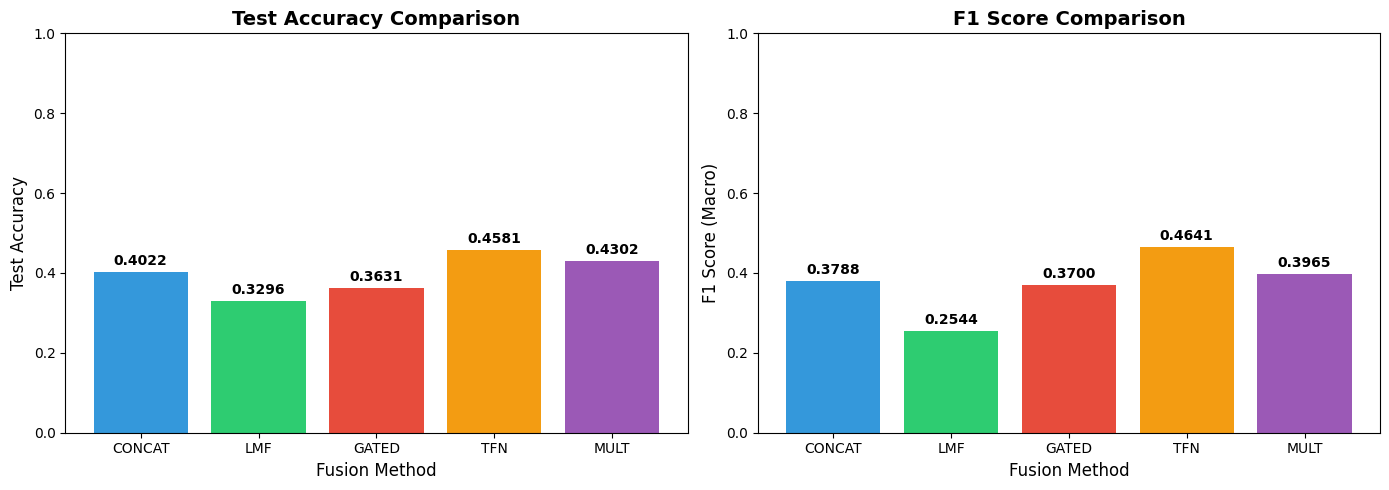

准确率对比图已保存！


In [10]:
# ========== 准确率对比图 ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = [r['method'].upper() for r in all_results.values()]
test_accs = [r['test_acc'] for r in all_results.values()]
f1_scores = [r['f1_macro'] for r in all_results.values()]

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']

# 测试准确率
bars1 = axes[0].bar(methods, test_accs, color=colors)
axes[0].set_xlabel('Fusion Method', fontsize=12)
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
for bar, acc in zip(bars1, test_accs):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{acc:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# F1分数
bars2 = axes[1].bar(methods, f1_scores, color=colors)
axes[1].set_xlabel('Fusion Method', fontsize=12)
axes[1].set_ylabel('F1 Score (Macro)', fontsize=12)
axes[1].set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
for bar, f1 in zip(bars2, f1_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{f1:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('./data2025/resm/fusion_comparison/accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("准确率对比图已保存！")

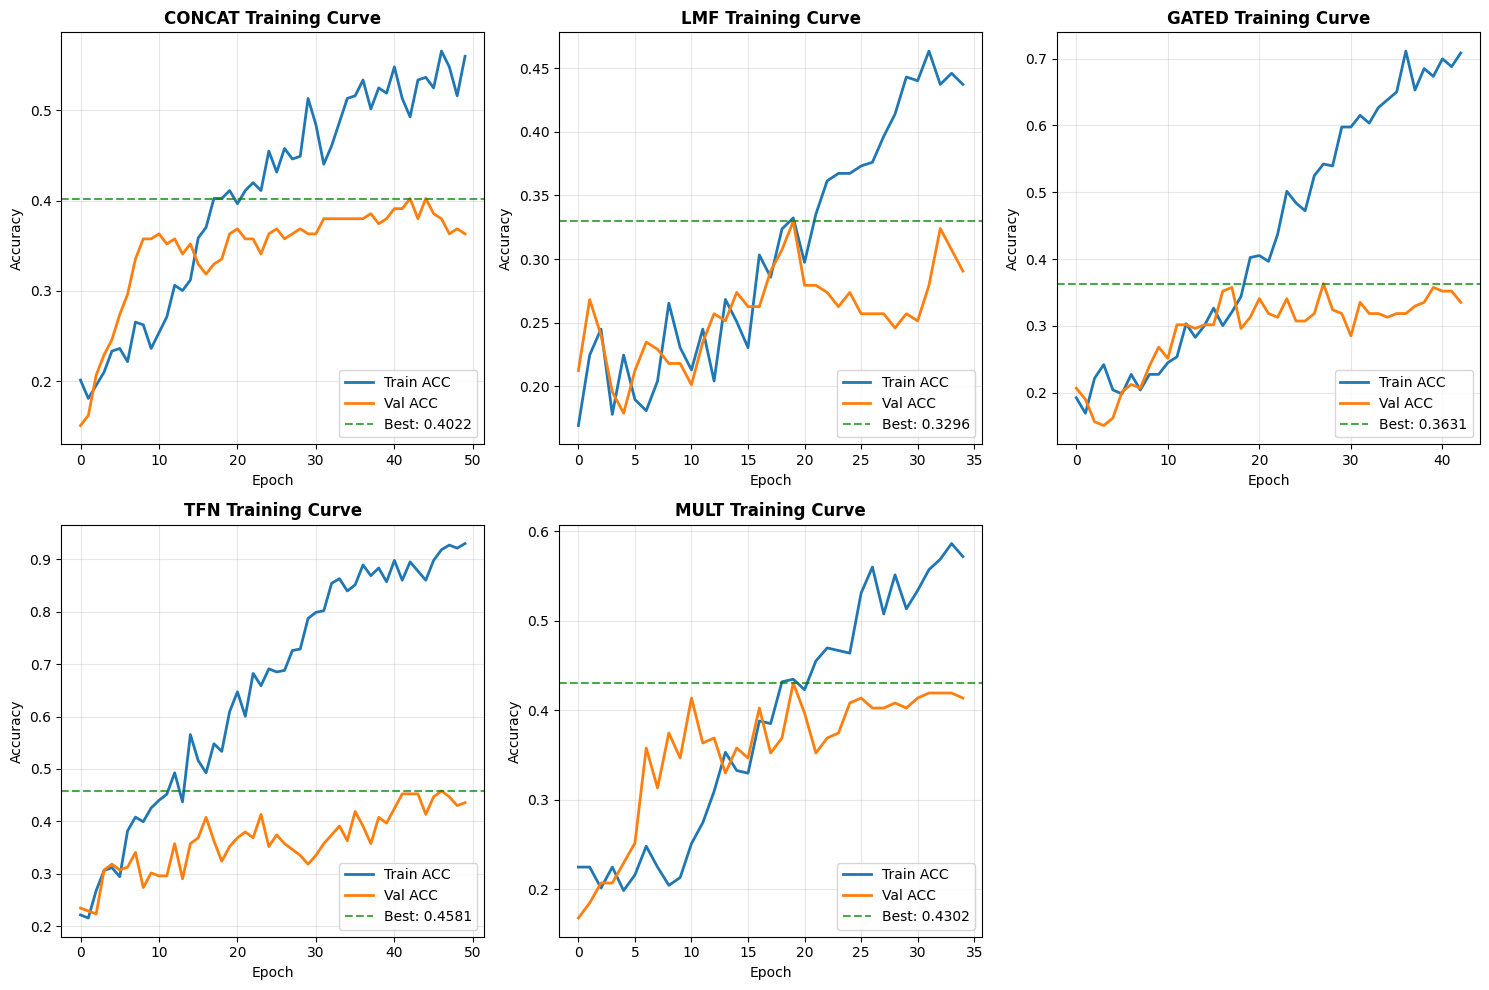

训练曲线已保存！


In [11]:
# ========== 训练曲线对比 ==========
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (method, results) in enumerate(all_results.items()):
    if idx >= 5:
        break
    ax = axes[idx]
    
    acc_key = 'acc' if 'acc' in results['history'] else 'accuracy'
    val_acc_key = 'val_acc' if 'val_acc' in results['history'] else 'val_accuracy'
    
    ax.plot(results['history'][acc_key], label='Train ACC', linewidth=2)
    ax.plot(results['history'][val_acc_key], label='Val ACC', linewidth=2)
    ax.axhline(y=results['val_acc'], color='green', linestyle='--', alpha=0.7,
               label=f'Best: {results["val_acc"]:.4f}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{method.upper()} Training Curve', fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

# 隐藏多余的子图
axes[5].axis('off')

plt.tight_layout()
plt.savefig('./data2025/resm/fusion_comparison/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("训练曲线已保存！")

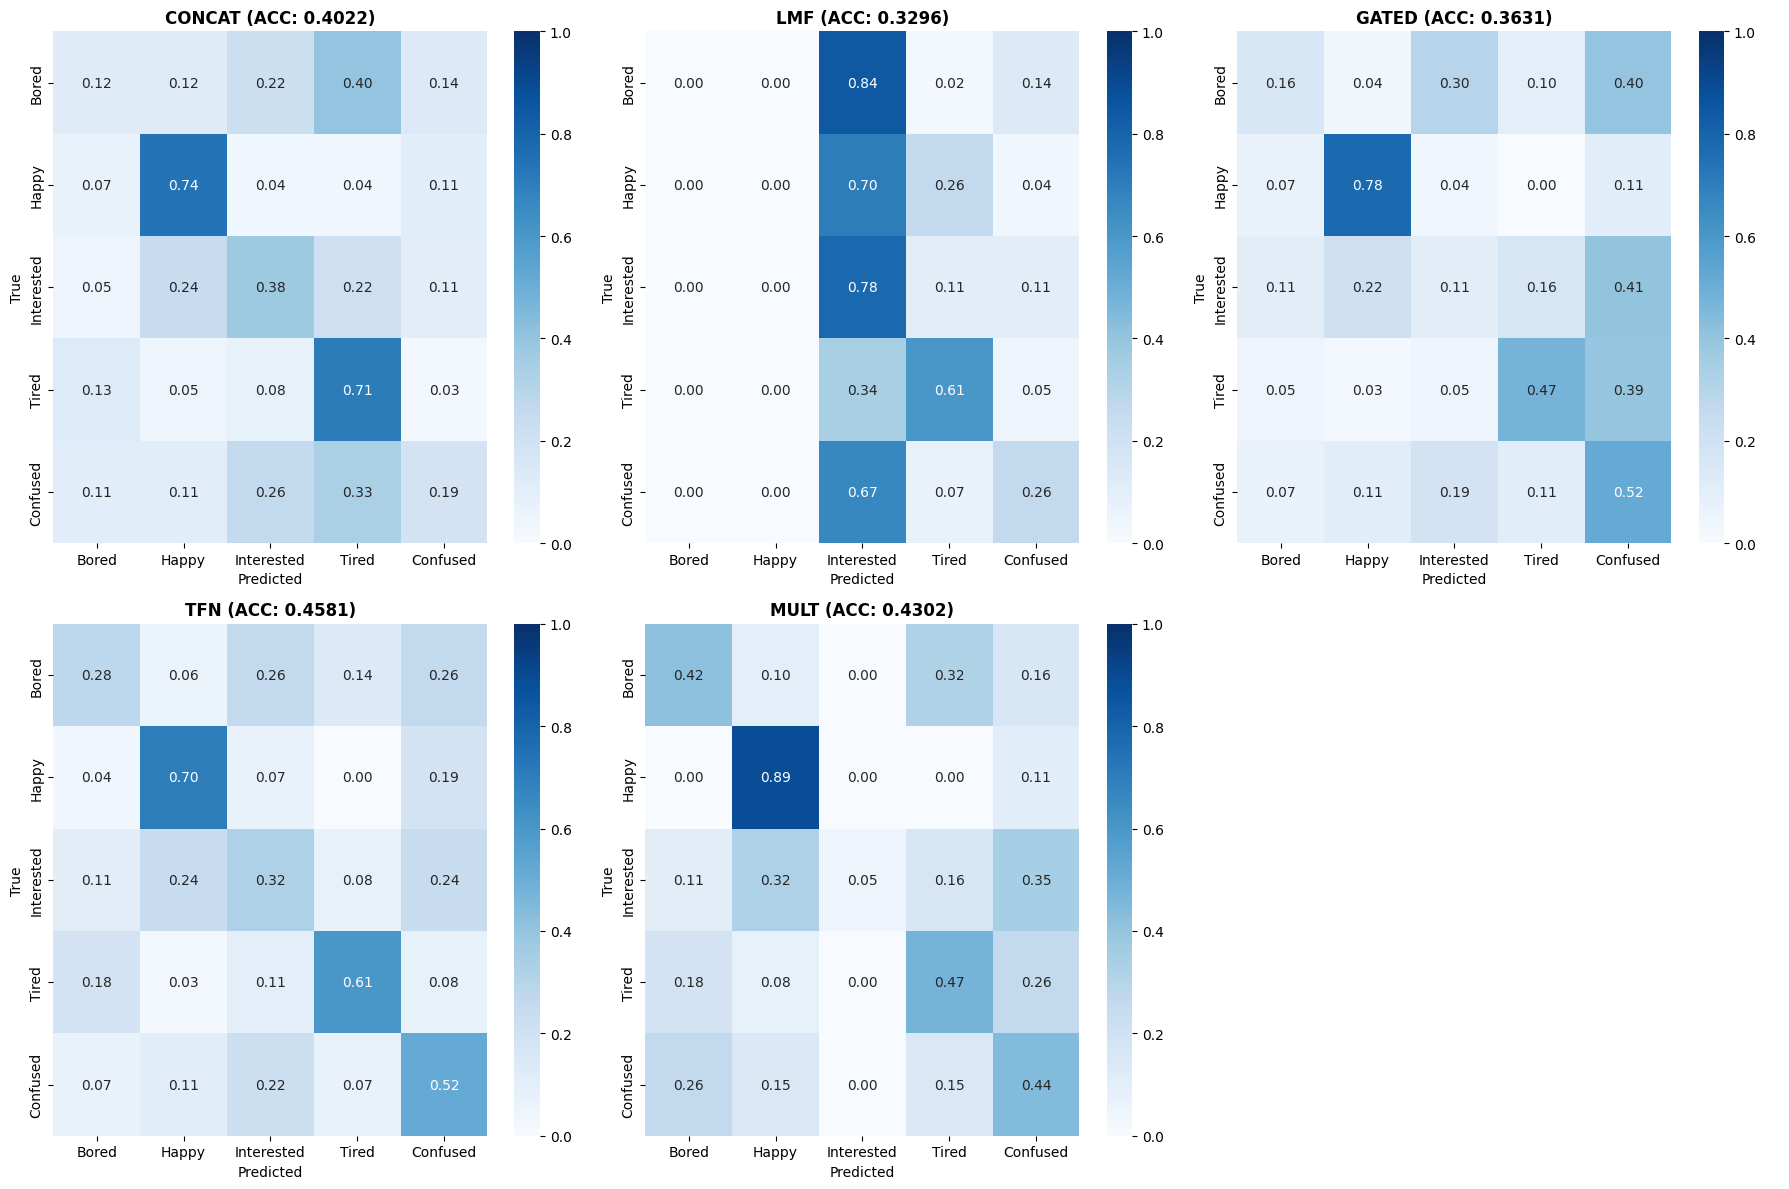

混淆矩阵已保存！


In [12]:
# ========== 混淆矩阵对比 ==========
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (method, results) in enumerate(all_results.items()):
    if idx >= 5:
        break
    ax = axes[idx]
    
    cm = results['confusion_matrix']
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels,
                ax=ax, vmin=0, vmax=1)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{method.upper()} (ACC: {results["test_acc"]:.4f})', fontweight='bold')

# 隐藏多余的子图
axes[5].axis('off')

plt.tight_layout()
plt.savefig('./data2025/resm/fusion_comparison/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("混淆矩阵已保存！")

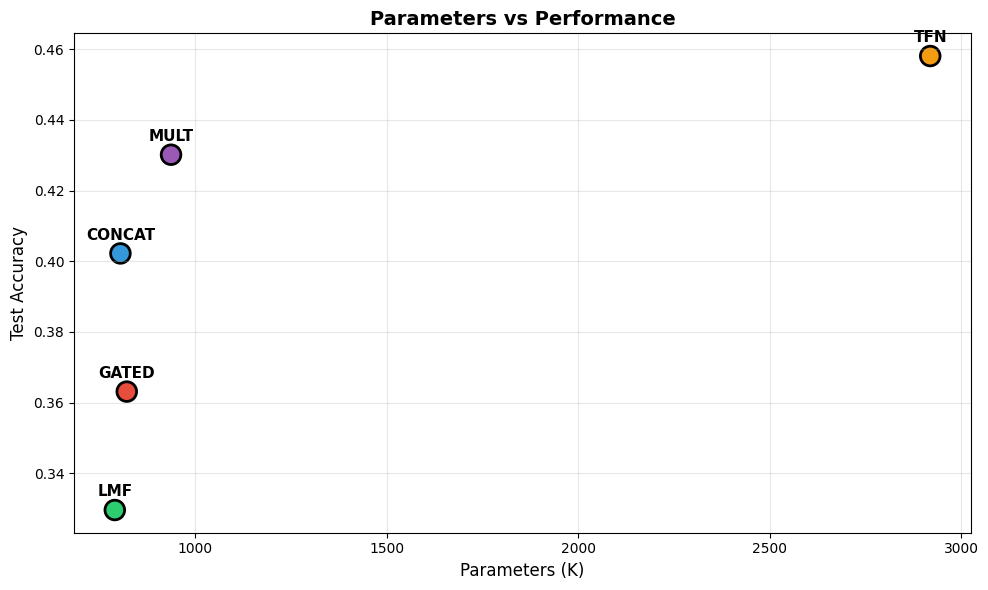

参数量与性能关系图已保存！


In [13]:
# ========== 参数量与性能关系 ==========
fig, ax = plt.subplots(figsize=(10, 6))

params = [r['params'] / 1000 for r in all_results.values()]  # 转换为K
test_accs = [r['test_acc'] for r in all_results.values()]
methods = [r['method'].upper() for r in all_results.values()]

scatter = ax.scatter(params, test_accs, c=colors, s=200, edgecolors='black', linewidth=2)

for i, method in enumerate(methods):
    ax.annotate(method, (params[i], test_accs[i]), 
                textcoords="offset points", xytext=(0, 10),
                ha='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Parameters (K)', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Parameters vs Performance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./data2025/resm/fusion_comparison/params_vs_performance.png', dpi=300, bbox_inches='tight')
plt.show()
print("参数量与性能关系图已保存！")

## 9. 最终汇总

In [14]:
# ========== 最终汇总 ==========
print("\n" + "="*70)
print("多模态融合方法对比实验 - 最终汇总")
print("="*70)

print("\n【模型配置】")
print("  视觉分支: CLIP (16, 512) → CNN + LSTM + GlobalMaxPool → 128维")
print("  文本分支: BERT (82, 768) → Attention + BiLSTM + GlobalMaxPool → 128维")

print("\n【正则化配置】")
print("  视觉分支: L2(0.001) + Dropout(0.3)")
print("  文本分支: L2(0.01) + Dropout(0.2→0.3→0.4)")
print("  分类头: L2(0.001) + Dropout(0.5, 0.3)")
print("  类别权重: 已启用 (处理类别不平衡)")
print("  学习率: 0.0001")

print("\n【融合方法对比】")
print("-" * 70)
print(f"{'方法':<15} {'Test ACC':<12} {'F1 (Macro)':<12} {'参数量':<15} {'论文来源'}")
print("-" * 70)

paper_sources = {
    'concat': 'Baseline',
    'lmf': 'ACL 2018',
    'gated': 'Custom',
    'tfn': 'EMNLP 2017',
    'mult': 'ACL 2019'
}

# 按测试准确率排序
sorted_results = sorted(all_results.items(), key=lambda x: x[1]['test_acc'], reverse=True)

for method, r in sorted_results:
    print(f"{method.upper():<15} {r['test_acc']:<12.4f} {r['f1_macro']:<12.4f} {r['params']:<15,} {paper_sources[method]}")

print("-" * 70)

# 最佳方法
best_method = sorted_results[0][0]
best_acc = sorted_results[0][1]['test_acc']

print(f"\n【最佳融合方法】: {best_method.upper()} (Test ACC: {best_acc:.4f})")

print("\n【生成文件】")
print("  1. 模型权重: ./data2025/resm/fusion_comparison/model_*.tf")
print("  2. 结果汇总: ./data2025/resm/fusion_comparison/results_summary.csv")
print("  3. 准确率对比图: ./data2025/resm/fusion_comparison/accuracy_comparison.png")
print("  4. 训练曲线: ./data2025/resm/fusion_comparison/training_curves.png")
print("  5. 混淆矩阵: ./data2025/resm/fusion_comparison/confusion_matrices.png")
print("  6. 参数性能图: ./data2025/resm/fusion_comparison/params_vs_performance.png")

print("\n" + "="*70)
print("实验完成！")
print("="*70)

# 清理内存
gc.collect()


多模态融合方法对比实验 - 最终汇总

【模型配置】
  视觉分支: CLIP (16, 512) → CNN + LSTM + GlobalMaxPool → 128维
  文本分支: BERT (82, 768) → Attention + BiLSTM + GlobalMaxPool → 128维

【正则化配置】
  视觉分支: L2(0.001) + Dropout(0.3)
  文本分支: L2(0.01) + Dropout(0.2→0.3→0.4)
  分类头: L2(0.001) + Dropout(0.5, 0.3)
  类别权重: 已启用 (处理类别不平衡)
  学习率: 0.0001

【融合方法对比】
----------------------------------------------------------------------
方法              Test ACC     F1 (Macro)   参数量             论文来源
----------------------------------------------------------------------
TFN             0.4581       0.4641       2,919,237       EMNLP 2017
MULT            0.4302       0.3965       937,541         ACL 2019
CONCAT          0.4022       0.3788       805,445         Baseline
GATED           0.3631       0.3700       821,957         Custom
LMF             0.3296       0.2544       790,733         ACL 2018
----------------------------------------------------------------------

【最佳融合方法】: TFN (Test ACC: 0.4581)

【生成文件】
  1. 模型权重: ./data2025/resm/f

39352